# Case Study Analysis Notebook: Arizona Study

The purpose of this code is to create a set of graphs based on one shapefile of many polygons.  In this way it is a little more complicated than our Casestudy_Analysis.ipynb by integrating aspects of the regional analysis code, but the principles are the same.  This produces graphs from our paper for our case study analysis of areas in Arizona.

To run this code, you need the following files in the appropriate folders:
 - Data/Input
   - Yearly_DroughtIndices_updated[your date].csv
 - Data/Output/Local
   - Master_ADWR_database_noduplicates.shp
   - Master_ADWR_database_water.shp
   - Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv
 - Data/Input/Shapefiles
   - 'AllCaseStudies.shp' which is referenced from our cyverse.

In [1]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local'

shapepath_web = 'https://data.cyverse.org/dav-anon/iplant/home/dtadych/Miscellaneous/'

Define Severe Drought Years

In [2]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [3]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


This is used for shading later

In [4]:
drought_color = "#D0CECE" #'#ffa6b8'

# Orange / Purple
cblind_diverging = ['#b35806', '#a86638', '#98745c', '#808080', '#cf98ee', '#8453b9', '#3f1374']


Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [5]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local\Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 254720 entries, 0 to 254719
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    254720 non-null  object  
 1   OBJECTID_g  45631 non-null   float64 
 2   SITE_ID     45631 non-null   object  
 3   LOCAL_ID    45631 non-null   object  
 4   REGISTRY_I  233584 non-null  object  
 5   WELL_TYPE   45631 non-null   object  
 6   DD_LAT      45631 non-null   float64 
 7   DD_LONG     45631 non-null   float64 
 8   LAT_NAD27   45631 non-null   object  
 9   LONG_NAD27  45631 non-null   object  
 10  WELL_ALT    45631 non-null   float64 
 11  WATER_USE_  45573 non-null   object  
 12  WELL_DEPTH  214498 non-null  float64 
 13  CASE_DIAM   33772 non-null   float64 
 14  WL_COUNT    45631 non-null   float64 
 15  WL_DTW      34716 non-null   float64 
 16  WL_ELEV     34716 non-null   float64 
 1

This one takes about 3-4 minutes to run

In [6]:
# Read in the database of number water wells
filename_mdb_w = 'Master_ADWR_database_water.shp'
filepath = os.path.join(outputpath, filename_mdb_w)
print(filepath)

masterdb_water = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb_water.info())

../../Data/Output/Local\Master_ADWR_database_water.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 142717 entries, 0 to 142716
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    142717 non-null  object  
 1   OBJECTID_g  45631 non-null   float64 
 2   SITE_ID     45631 non-null   object  
 3   LOCAL_ID    45631 non-null   object  
 4   REGISTRY_I  121581 non-null  object  
 5   WELL_TYPE   45631 non-null   object  
 6   DD_LAT      45631 non-null   float64 
 7   DD_LONG     45631 non-null   float64 
 8   LAT_NAD27   45631 non-null   object  
 9   LONG_NAD27  45631 non-null   object  
 10  WELL_ALT    45631 non-null   float64 
 11  WATER_USE_  45573 non-null   object  
 12  WELL_DEPTH  130667 non-null  float64 
 13  CASE_DIAM   33772 non-null   float64 
 14  WL_COUNT    45631 non-null   float64 
 15  WL_DTW      34716 non-null   float64 
 16  WL_ELEV     34716 non-null   float64 
 17  SOUR

In [7]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local\Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv


Combo_ID  1853.0  1856.0  1857.0  1860.0  1864.0  1868.0  1870.0  1871.0  \
0     60001     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1     85358     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2     85761     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3     85799     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4     85863     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   1872.0  ...  2015.0  2016.0  2017.0  2018.0  2019.0  2020.0  2021.0  \
0     NaN  ...  497.70  495.30     NaN  489.85     NaN  487.85  485.10   
1     NaN  ...     NaN  262.43  254.88  251.65  251.53     NaN     NaN   
2     NaN  ...   44.70   45.50   45.30   46.30   45.00   46.20   43.50   
3     NaN  ...   59.30   59.80   57.80   59.50   60.10   59.40   60.80   
4     NaN  ...  114.74  115.50  116.26  117.10  119.34  118.49  119.77   

   2022.0  2023.0  2024.0  
0  483.50  483.90     NaN  
1     NaN     NaN     NaN  
2   41.40   45.80     NaN  
3   62.10   62.10     NaN  
4  120.65  119.83  120.71  

[5 rows x 161 columns]

In [8]:
# Read in the drought indices

#  Input the date you downloaded the drought files
date_downloaded = "06102024"

drought_indices = pd.read_csv(f'{inputpath}/Yearly_DroughtIndices_updated{date_downloaded}.csv')
drought_indices = drought_indices.set_index('In_year')

<Axes: >

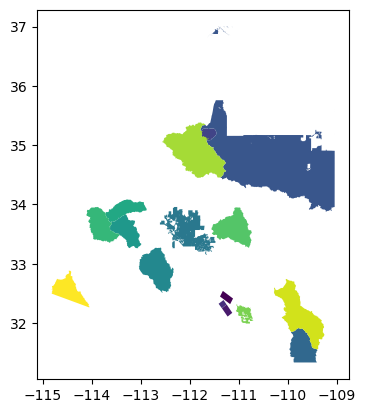

In [9]:
# Read in the shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = 'AllCaseStudies.shp'
# filepath = os.path.join(shapepath, filename_shapeile)
filepath = os.path.join(shapepath_web, filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')


In [10]:
shapefile.head()

Name   FID AMA_CODE            SUBBASIN_N NAME_ABBR  \
0    GSF/USF   NaN      NaN                   NaN       NaN   
1        USF   NaN      NaN                   NaN       NaN   
2    Control   NaN      NaN                   NaN       NaN   
3  Flagstaff 14.00      NaN                   NaN       NaN   
4  LittleCoR   NaN        A  JOSEPHCITY_LITTLECOR       JCI   

                SUBBASIN_1      SHAPEAREA               layer  \
0                      NaN            NaN    AvraValleyGSFUSF   
1                      NaN            NaN    AvraValleyGSFUSF   
2                      NaN            NaN    AvraValleyGSFUSF   
3                      NaN            NaN  Flagstaff_Buffered   
4  JOSEPHCITYINA_LITTLECoR 69171676398.62   Little Co.  River   

                                                path  \
0  /Users/danielletadych/Documents/PhD_Materials/...   
1  /Users/danielletadych/Documents/PhD_Materials/...   
2  /Users/danielletadych/Documents/PhD_Materials/...   
3  /Users/danielletadych/Documents/PhD_Materials/...   
4  /Users/danielletadych/Documents/PhD_Materials/...   

                                            geometry  
0  POLYGON Z ((-111.38373 32.44680 0.00000, -111....  
1  POLYGON Z ((-111.34431 32.24769 0.00000, -111....  
2  POLYGON Z ((-111.34573 32.24836 0.00000, -111....  
3  POLYGON Z ((-111.76613 35.19826 0.00000, -111....  
4  MULTIPOLYGON Z (((-109.04629 35.62503 0.00000,...

In [11]:
# Define some things about your file

Naming_col = "Name"

Merging the databases takes a little time - Approximately 0.1-3 minutes

In [12]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
masterdb_water = masterdb_water.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner", op='intersects')

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")

# %% For the water wells water wells
static_geo2 = gp.sjoin(masterdb_water, shapefile, how="inner", op='intersects')
static_geo2.head()
print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and AllCaseStudies.shp join complete.


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and AllCaseStudies.shp join complete.


In [13]:
static_geo

Combo_ID  OBJECTID_g          SITE_ID       LOCAL_ID REGISTRY_I  \
1        060001 12086239.00  334708112295301  B-05-02 08CCB     060001   
52       084818         NaN              NaN            NaN     084818   
75       084954         NaN              NaN            NaN     084954   
122      085006         NaN              NaN            NaN     085006   
123      085007         NaN              NaN            NaN     085007   
...         ...         ...              ...            ...        ...   
254114   930565         NaN              NaN            NaN     930565   
254244   930700         NaN              NaN            NaN     930700   
254245   930701         NaN              NaN            NaN     930701   
254246   930702         NaN              NaN            NaN     930702   
254247   930703         NaN              NaN            NaN     930703   

       WELL_TYPE  DD_LAT  DD_LONG    LAT_NAD27    LONG_NAD27  ...  \
1          INDEX   33.79  -112.50  33 47   6.2  112 29  52.1  ...   
52           NaN     NaN      NaN          NaN           NaN  ...   
75           NaN     NaN      NaN          NaN           NaN  ...   
122          NaN     NaN      NaN          NaN           NaN  ...   
123          NaN     NaN      NaN          NaN           NaN  ...   
...          ...     ...      ...          ...           ...  ...   
254114       NaN     NaN      NaN          NaN           NaN  ...   
254244       NaN     NaN      NaN          NaN           NaN  ...   
254245       NaN     NaN      NaN          NaN           NaN  ...   
254246       NaN     NaN      NaN          NaN           NaN  ...   
254247       NaN     NaN      NaN          NaN           NaN  ...   

        index_right       Name   FID  AMA_CODE  SUBBASIN_N_right  NAME_ABBR  \
1                 6    Phoenix 78.00       NaN               NaN        NaN   
52                6    Phoenix 78.00       NaN               NaN        NaN   
75                6    Phoenix 78.00       NaN               NaN        NaN   
122               6    Phoenix 78.00       NaN               NaN        NaN   
123               6    Phoenix 78.00       NaN               NaN        NaN   
...             ...        ...   ...       ...               ...        ...   
254114            3  Flagstaff 14.00       NaN               NaN        NaN   
254244            3  Flagstaff 14.00       NaN               NaN        NaN   
254245            3  Flagstaff 14.00       NaN               NaN        NaN   
254246            3  Flagstaff 14.00       NaN               NaN        NaN   
254247            3  Flagstaff 14.00       NaN               NaN        NaN   

        SUBBASIN_1 SHAPEAREA               layer  \
1              NaN       NaN     Phoenix (Urban)   
52             NaN       NaN     Phoenix (Urban)   
75             NaN       NaN     Phoenix (Urban)   
122            NaN       NaN     Phoenix (Urban)   
123            NaN       NaN     Phoenix (Urban)   
...            ...       ...                 ...   
254114         NaN       NaN  Flagstaff_Buffered   
254244         NaN       NaN  Flagstaff_Buffered   
254245         NaN       NaN  Flagstaff_Buffered   
254246         NaN       NaN  Flagstaff_Buffered   
254247         NaN       NaN  Flagstaff_Buffered   

                                                     path  
1       /Users/danielletadych/Documents/PhD_Materials/...  
52      /Users/danielletadych/Documents/PhD_Materials/...  
75      /Users/danielletadych/Documents/PhD_Materials/...  
122     /Users/danielletadych/Documents/PhD_Materials/...  
123     /Users/danielletadych/Documents/PhD_Materials/...  
...                                                   ...  
254114  /Users/danielletadych/Documents/PhD_Materials/...  
254244  /Users/danielletadych/Documents/PhD_Materials/...  
254245  /Users/danielletadych/Documents/PhD_Materials/...  
254246  /Users/danielletadych/Documents/PhD_Materials/...  
254247  /Users/danielletadych/Documents/PhD_Materials/.

In [14]:
# Pull out the columns you need
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_']]
reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

C:\Users\det19\AppData\Local\Temp\ipykernel_47704\107287575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [15]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Columns: 164 entries, Combo_ID to WELL_TYPE_
dtypes: float64(161), int64(1), object(2)
memory usage: 1011.0+ KB


In [16]:
# Grouping the appropriate column
combo_copy = combo.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'],axis=1)
cat_wl = combo_copy.groupby([Naming_col]).mean()

In [17]:
# Clean up the dataframe for graphing
cat_wl2 = cat_wl.copy()
i = cat_wl2
df = i.transpose()
df.reset_index(inplace=True)
df['index'] = pd.to_numeric(df['index'])
df['index'] = df['index'].astype(int)
df.set_index('index', inplace=True)
df.info()
cat_wl2 = df
cat_wl2

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 1853 to 2024
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Control        60 non-null     float64
 1   Douglas        78 non-null     float64
 2   Flagstaff      57 non-null     float64
 3   GSF/USF        84 non-null     float64
 4   GilaBend       74 non-null     float64
 5   Harquahala     71 non-null     float64
 6   LittleCoR      81 non-null     float64
 7   McMullen       73 non-null     float64
 8   Phoenix        92 non-null     float64
 9   RanegrasPlain  77 non-null     float64
 10  SaltRiver      41 non-null     float64
 11  Tucson         98 non-null     float64
 12  USF            75 non-null     float64
 13  Verde          71 non-null     float64
 14  Wilcox         81 non-null     float64
 15  Yuma           81 non-null     float64
dtypes: float64(16)
memory usage: 20.6 KB


Name   Control  Douglas  Flagstaff  GSF/USF  GilaBend  Harquahala  LittleCoR  \
index                                                                          
1853       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
1856       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
1857       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
1860       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
1864       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
...        ...      ...        ...      ...       ...         ...        ...   
2020    323.77   188.87     392.92   187.45    362.77      350.28     230.16   
2021       NaN   190.67     394.16   180.26    365.74      362.56     230.32   
2022    352.60   190.60     393.30   181.48    375.43      343.20     232.11   
2023    352.00   195.12     390.69   187.55    373.44      336.76     219.87   
2024    352.40    93.42     927.49   186.07    251.40      425.78     263.51   

Name   McMullen  Phoenix  RanegrasPlain  SaltRiver  Tucson    USF  Verde  \
index                                                                      
1853        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
1856        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
1857        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
1860        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
1864        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
...         ...      ...            ...        ...     ...    ...    ...   
2020     416.44   227.80         260.36       5.50  234.33 294.66 207.85   
2021     419.92   231.65         252.15       8.80  212.92 279.55 231.68   
2022     410.93   227.27         255.61      10.03  207.91 273.25 215.28   
2023     436.36   236.72         257.78      11.30  194.44 270.41 215.48   
2024     326.99   333.84         335.05        NaN  189.16 262.05  66.89   

Name   Wilcox  Yuma  
index                
1853      NaN   NaN  
1856      NaN   NaN  
1857      NaN   NaN  
1860      NaN   NaN  
1864      NaN   NaN  
...       ...   ...  
2020   255.31 62.19  
2021   281.53 68.67  
2022   287.22 70.00  
2023   282.26 70.87  
2024    59.27   NaN  

[160 rows x 16 columns]

In [18]:
# Export the dataframe
cat_wl2.to_csv(outputpath+'/Waterlevels_AllCaseStudies.csv')

### Analysis and Graphing
If the merge above went well, you can just read in the csv to fine-tune or make new graphs

In [19]:
cat_wl2 = pd.read_csv(outputpath+'/Waterlevels_AllCaseStudies.csv') 

cat_wl2 = cat_wl2.set_index('index')
cat_wl2

Control  Douglas  Flagstaff  GSF/USF  GilaBend  Harquahala  LittleCoR  \
index                                                                          
1853       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
1856       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
1857       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
1860       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
1864       NaN      NaN        NaN      NaN       NaN         NaN        NaN   
...        ...      ...        ...      ...       ...         ...        ...   
2020    323.77   188.87     392.92   187.45    362.77      350.28     230.16   
2021       NaN   190.67     394.16   180.26    365.74      362.56     230.32   
2022    352.60   190.60     393.30   181.48    375.43      343.20     232.11   
2023    352.00   195.12     390.69   187.55    373.44      336.76     219.87   
2024    352.40    93.42     927.49   186.07    251.40      425.78     263.51   

       McMullen  Phoenix  RanegrasPlain  SaltRiver  Tucson    USF  Verde  \
index                                                                      
1853        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
1856        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
1857        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
1860        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
1864        NaN      NaN            NaN        NaN     NaN    NaN    NaN   
...         ...      ...            ...        ...     ...    ...    ...   
2020     416.44   227.80         260.36       5.50  234.33 294.66 207.85   
2021     419.92   231.65         252.15       8.80  212.92 279.55 231.68   
2022     410.93   227.27         255.61      10.03  207.91 273.25 215.28   
2023     436.36   236.72         257.78      11.30  194.44 270.41 215.48   
2024     326.99   333.84         335.05        NaN  189.16 262.05  66.89   

       Wilcox  Yuma  
index                
1853      NaN   NaN  
1856      NaN   NaN  
1857      NaN   NaN  
1860      NaN   NaN  
1864      NaN   NaN  
...       ...   ...  
2020   255.31 62.19  
2021   281.53 68.67  
2022   287.22 70.00  
2023   282.26 70.87  
2024    59.27   NaN  

[160 rows x 16 columns]

In [20]:
Min_year_of_Study = 2000
Max_year_of_Study = 2022

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=Max_year_of_Study)]
drought_indices = drought_indices[(drought_indices.index>=Min_year_of_Study)&(drought_indices.index<=Max_year_of_Study)]
wlanalysis_period.head()

Control  Douglas  Flagstaff  GSF/USF  GilaBend  Harquahala  LittleCoR  \
index                                                                          
2000    365.48   153.19     228.65   230.05    228.68      341.03     272.35   
2001    360.80      NaN     344.36   225.29    233.61      334.69     273.45   
2002    358.92   150.16     244.00   220.37    237.35      347.55     283.99   
2003    358.39   157.44     226.62   208.78    250.58      333.66     289.72   
2004    352.46   158.20     227.84   203.33    261.80      338.58     288.18   

       McMullen  Phoenix  RanegrasPlain  SaltRiver  Tucson    USF  Verde  \
index                                                                      
2000     379.45   263.68         218.20      11.60  261.14 384.72 241.87   
2001     399.00   238.13         194.17      11.94  233.79 384.55 225.21   
2002     373.91   243.70         220.15      13.34  264.70 405.21 191.56   
2003     398.44   260.86         230.36      13.59  253.96 398.33 201.37   
2004     415.38   240.87         241.20      12.86  258.13 399.26 212.18   

       Wilcox  Yuma  
index                
2000   222.65 57.05  
2001   226.71 76.49  
2002   216.27 48.99  
2003   226.31 50.26  
2004   220.62 51.22

Look at your data to see if there are any NaN's

In [21]:
wlanalysis_period

Control  Douglas  Flagstaff  GSF/USF  GilaBend  Harquahala  LittleCoR  \
index                                                                          
2000    365.48   153.19     228.65   230.05    228.68      341.03     272.35   
2001    360.80      NaN     344.36   225.29    233.61      334.69     273.45   
2002    358.92   150.16     244.00   220.37    237.35      347.55     283.99   
2003    358.39   157.44     226.62   208.78    250.58      333.66     289.72   
2004    352.46   158.20     227.84   203.33    261.80      338.58     288.18   
2005    355.26   153.11     215.10   200.56    212.51      329.43     297.27   
2006    351.20   158.01     217.40   196.25    254.31      334.05     284.69   
2007    328.66   162.29     224.03   190.43    275.91      328.62     225.36   
2008    353.90   181.19     373.43   188.03    283.52      268.72     181.58   
2009    339.31   164.33     375.98   190.69    287.48      338.54     227.50   
2010    348.10   176.62     369.47   188.22    271.54      345.92     222.93   
2011    339.79   167.38     371.23   189.81    282.74      339.30     221.36   
2012    338.66   173.03     370.05   192.79    294.48      343.67     233.38   
2013    337.48   173.96     344.09   192.28    291.61      341.91     226.96   
2014    337.23    78.16     342.19   196.31    279.73      343.37     217.08   
2015    335.34   173.50     341.37   193.87    288.59      350.10     213.30   
2016    333.49   183.75     345.83   193.52    320.58      357.60     191.21   
2017    332.15   193.79     336.53   190.95    294.40      318.24     199.09   
2018    329.89   197.08     366.31   192.36    331.32      318.52     219.68   
2019    323.55   182.54     391.59   188.08    322.84      325.88     219.86   
2020    323.77   188.87     392.92   187.45    362.77      350.28     230.16   
2021       NaN   190.67     394.16   180.26    365.74      362.56     230.32   
2022    352.60   190.60     393.30   181.48    375.43      343.20     232.11   

       McMullen  Phoenix  RanegrasPlain  SaltRiver  Tucson    USF  Verde  \
index                                                                      
2000     379.45   263.68         218.20      11.60  261.14 384.72 241.87   
2001     399.00   238.13         194.17      11.94  233.79 384.55 225.21   
2002     373.91   243.70         220.15      13.34  264.70 405.21 191.56   
2003     398.44   260.86         230.36      13.59  253.96 398.33 201.37   
2004     415.38   240.87         241.20      12.86  258.13 399.26 212.18   
2005     395.91   263.32         234.60      10.59  249.63 406.86 199.98   
2006     399.45   251.14         232.93      10.78  242.43 398.24 201.02   
2007     392.10   249.24         231.53      11.48  259.99 393.63 193.69   
2008     415.61   234.43         214.39        NaN  251.79 393.84 178.03   
2009     404.26   240.18         249.30       8.34  255.05 380.25 195.09   
2010     394.69   236.83         239.24       3.20  241.59 376.03 196.40   
2011     406.61   255.77         242.61       4.45  239.46 372.09 185.43   
2012     404.48   230.54         261.97       6.20  238.07 375.97 209.74   
2013     408.50   233.94         239.14       5.30  234.91 362.71 204.88   
2014     401.51   241.61         246.89       8.89  237.41 346.20 180.37   
2015     402.30   248.51         247.29      15.30  208.02 346.77 196.53   
2016     389.30   239.64         241.92      13.10  231.32 300.27 199.26   
2017     411.79   228.23         243.54      11.80  244.30 309.25 206.40   
2018     413.81   244.52         253.88      13.80  230.18 278.19 211.79   
2019     402.27   226.44         246.75       9.60  228.41 294.39 210.45   
2020     416.44   227.80         260.36       5.50  234.33 294.66 207.85   
2021     419.92   231.65         252.15       8.80  212.92 279.55 231.68   
2022     410.93   227.27         255.61      10.03  207.91 273.25 215.28   

       Wilcox  Yuma  
index                
2000   222.65 57.05  
2001   226.71 76.49  
2002   216.27 48.

This is helpful if you're missing values and it won't calculate statistics

In [22]:
df_interpolated = wlanalysis_period.interpolate(method='linear', axis=0)
df_interpolated

Control  Douglas  Flagstaff  GSF/USF  GilaBend  Harquahala  LittleCoR  \
index                                                                          
2000    365.48   153.19     228.65   230.05    228.68      341.03     272.35   
2001    360.80   151.68     344.36   225.29    233.61      334.69     273.45   
2002    358.92   150.16     244.00   220.37    237.35      347.55     283.99   
2003    358.39   157.44     226.62   208.78    250.58      333.66     289.72   
2004    352.46   158.20     227.84   203.33    261.80      338.58     288.18   
2005    355.26   153.11     215.10   200.56    212.51      329.43     297.27   
2006    351.20   158.01     217.40   196.25    254.31      334.05     284.69   
2007    328.66   162.29     224.03   190.43    275.91      328.62     225.36   
2008    353.90   181.19     373.43   188.03    283.52      268.72     181.58   
2009    339.31   164.33     375.98   190.69    287.48      338.54     227.50   
2010    348.10   176.62     369.47   188.22    271.54      345.92     222.93   
2011    339.79   167.38     371.23   189.81    282.74      339.30     221.36   
2012    338.66   173.03     370.05   192.79    294.48      343.67     233.38   
2013    337.48   173.96     344.09   192.28    291.61      341.91     226.96   
2014    337.23    78.16     342.19   196.31    279.73      343.37     217.08   
2015    335.34   173.50     341.37   193.87    288.59      350.10     213.30   
2016    333.49   183.75     345.83   193.52    320.58      357.60     191.21   
2017    332.15   193.79     336.53   190.95    294.40      318.24     199.09   
2018    329.89   197.08     366.31   192.36    331.32      318.52     219.68   
2019    323.55   182.54     391.59   188.08    322.84      325.88     219.86   
2020    323.77   188.87     392.92   187.45    362.77      350.28     230.16   
2021    338.18   190.67     394.16   180.26    365.74      362.56     230.32   
2022    352.60   190.60     393.30   181.48    375.43      343.20     232.11   

       McMullen  Phoenix  RanegrasPlain  SaltRiver  Tucson    USF  Verde  \
index                                                                      
2000     379.45   263.68         218.20      11.60  261.14 384.72 241.87   
2001     399.00   238.13         194.17      11.94  233.79 384.55 225.21   
2002     373.91   243.70         220.15      13.34  264.70 405.21 191.56   
2003     398.44   260.86         230.36      13.59  253.96 398.33 201.37   
2004     415.38   240.87         241.20      12.86  258.13 399.26 212.18   
2005     395.91   263.32         234.60      10.59  249.63 406.86 199.98   
2006     399.45   251.14         232.93      10.78  242.43 398.24 201.02   
2007     392.10   249.24         231.53      11.48  259.99 393.63 193.69   
2008     415.61   234.43         214.39       9.91  251.79 393.84 178.03   
2009     404.26   240.18         249.30       8.34  255.05 380.25 195.09   
2010     394.69   236.83         239.24       3.20  241.59 376.03 196.40   
2011     406.61   255.77         242.61       4.45  239.46 372.09 185.43   
2012     404.48   230.54         261.97       6.20  238.07 375.97 209.74   
2013     408.50   233.94         239.14       5.30  234.91 362.71 204.88   
2014     401.51   241.61         246.89       8.89  237.41 346.20 180.37   
2015     402.30   248.51         247.29      15.30  208.02 346.77 196.53   
2016     389.30   239.64         241.92      13.10  231.32 300.27 199.26   
2017     411.79   228.23         243.54      11.80  244.30 309.25 206.40   
2018     413.81   244.52         253.88      13.80  230.18 278.19 211.79   
2019     402.27   226.44         246.75       9.60  228.41 294.39 210.45   
2020     416.44   227.80         260.36       5.50  234.33 294.66 207.85   
2021     419.92   231.65         252.15       8.80  212.92 279.55 231.68   
2022     410.93   227.27         255.61      10.03  207.91 273.25 215.28   

       Wilcox  Yuma  
index                
2000   222.65 57.05  
2001   226.71 76.49  
2002   216.27 48.

We have 3 different sets of graphs in our paper:
1. Phoenix & Tucson
2. Gila Bend & Verde groundwater subbasins
3. Yuma groundwater subbasin

In [23]:
StudyArea = 'Phoenix & Tucson'

In [24]:
cblind_diverging

['#b35806', '#a86638', '#98745c', '#808080', '#cf98ee', '#8453b9', '#3f1374']

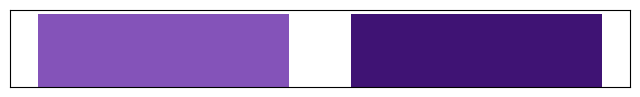

In [25]:
# This is to delete some columns as needed
columns_to_delete = ['Control','GSF/USF','USF'
                     ,'Harquahala'
                     ,'SaltRiver'
                     ,'Douglas'
                     ,'Verde','GilaBend'
                    #  ,'Tucson','Phoenix'
                     ,'McMullen'
                     ,'RanegrasPlain'
                     ,'Flagstaff'
                     ,'LittleCoR'
                     ,'Yuma'
                    ,'Wilcox'
                    ]
df = df_interpolated.drop(columns=columns_to_delete)

# Colors for Tucson and Phoenix
refined_cblind_colors = [cblind_diverging[5], cblind_diverging[6]]

# Create a bar plot to visualize colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(refined_cblind_colors)), height=1, color=refined_cblind_colors)

# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])

# Show the plot
plt.show()

In [26]:
# Reorder the dataframe
test = pd.DataFrame()
test['Phoenix'] = df['Phoenix']
test['Tucson'] = df['Tucson']
test.head()

Phoenix  Tucson
index                 
2000    263.68  261.14
2001    238.13  233.79
2002    243.70  264.70
2003    260.86  253.96
2004    240.87  258.13

         slope     int  rsq  p_val  std_err   mean    var     sum
Phoenix  -1.11 2480.17 0.43   0.00     0.28 241.67 126.89 5558.33
Tucson   -1.83 3916.00 0.60   0.00     0.33 239.98 246.29 5519.44


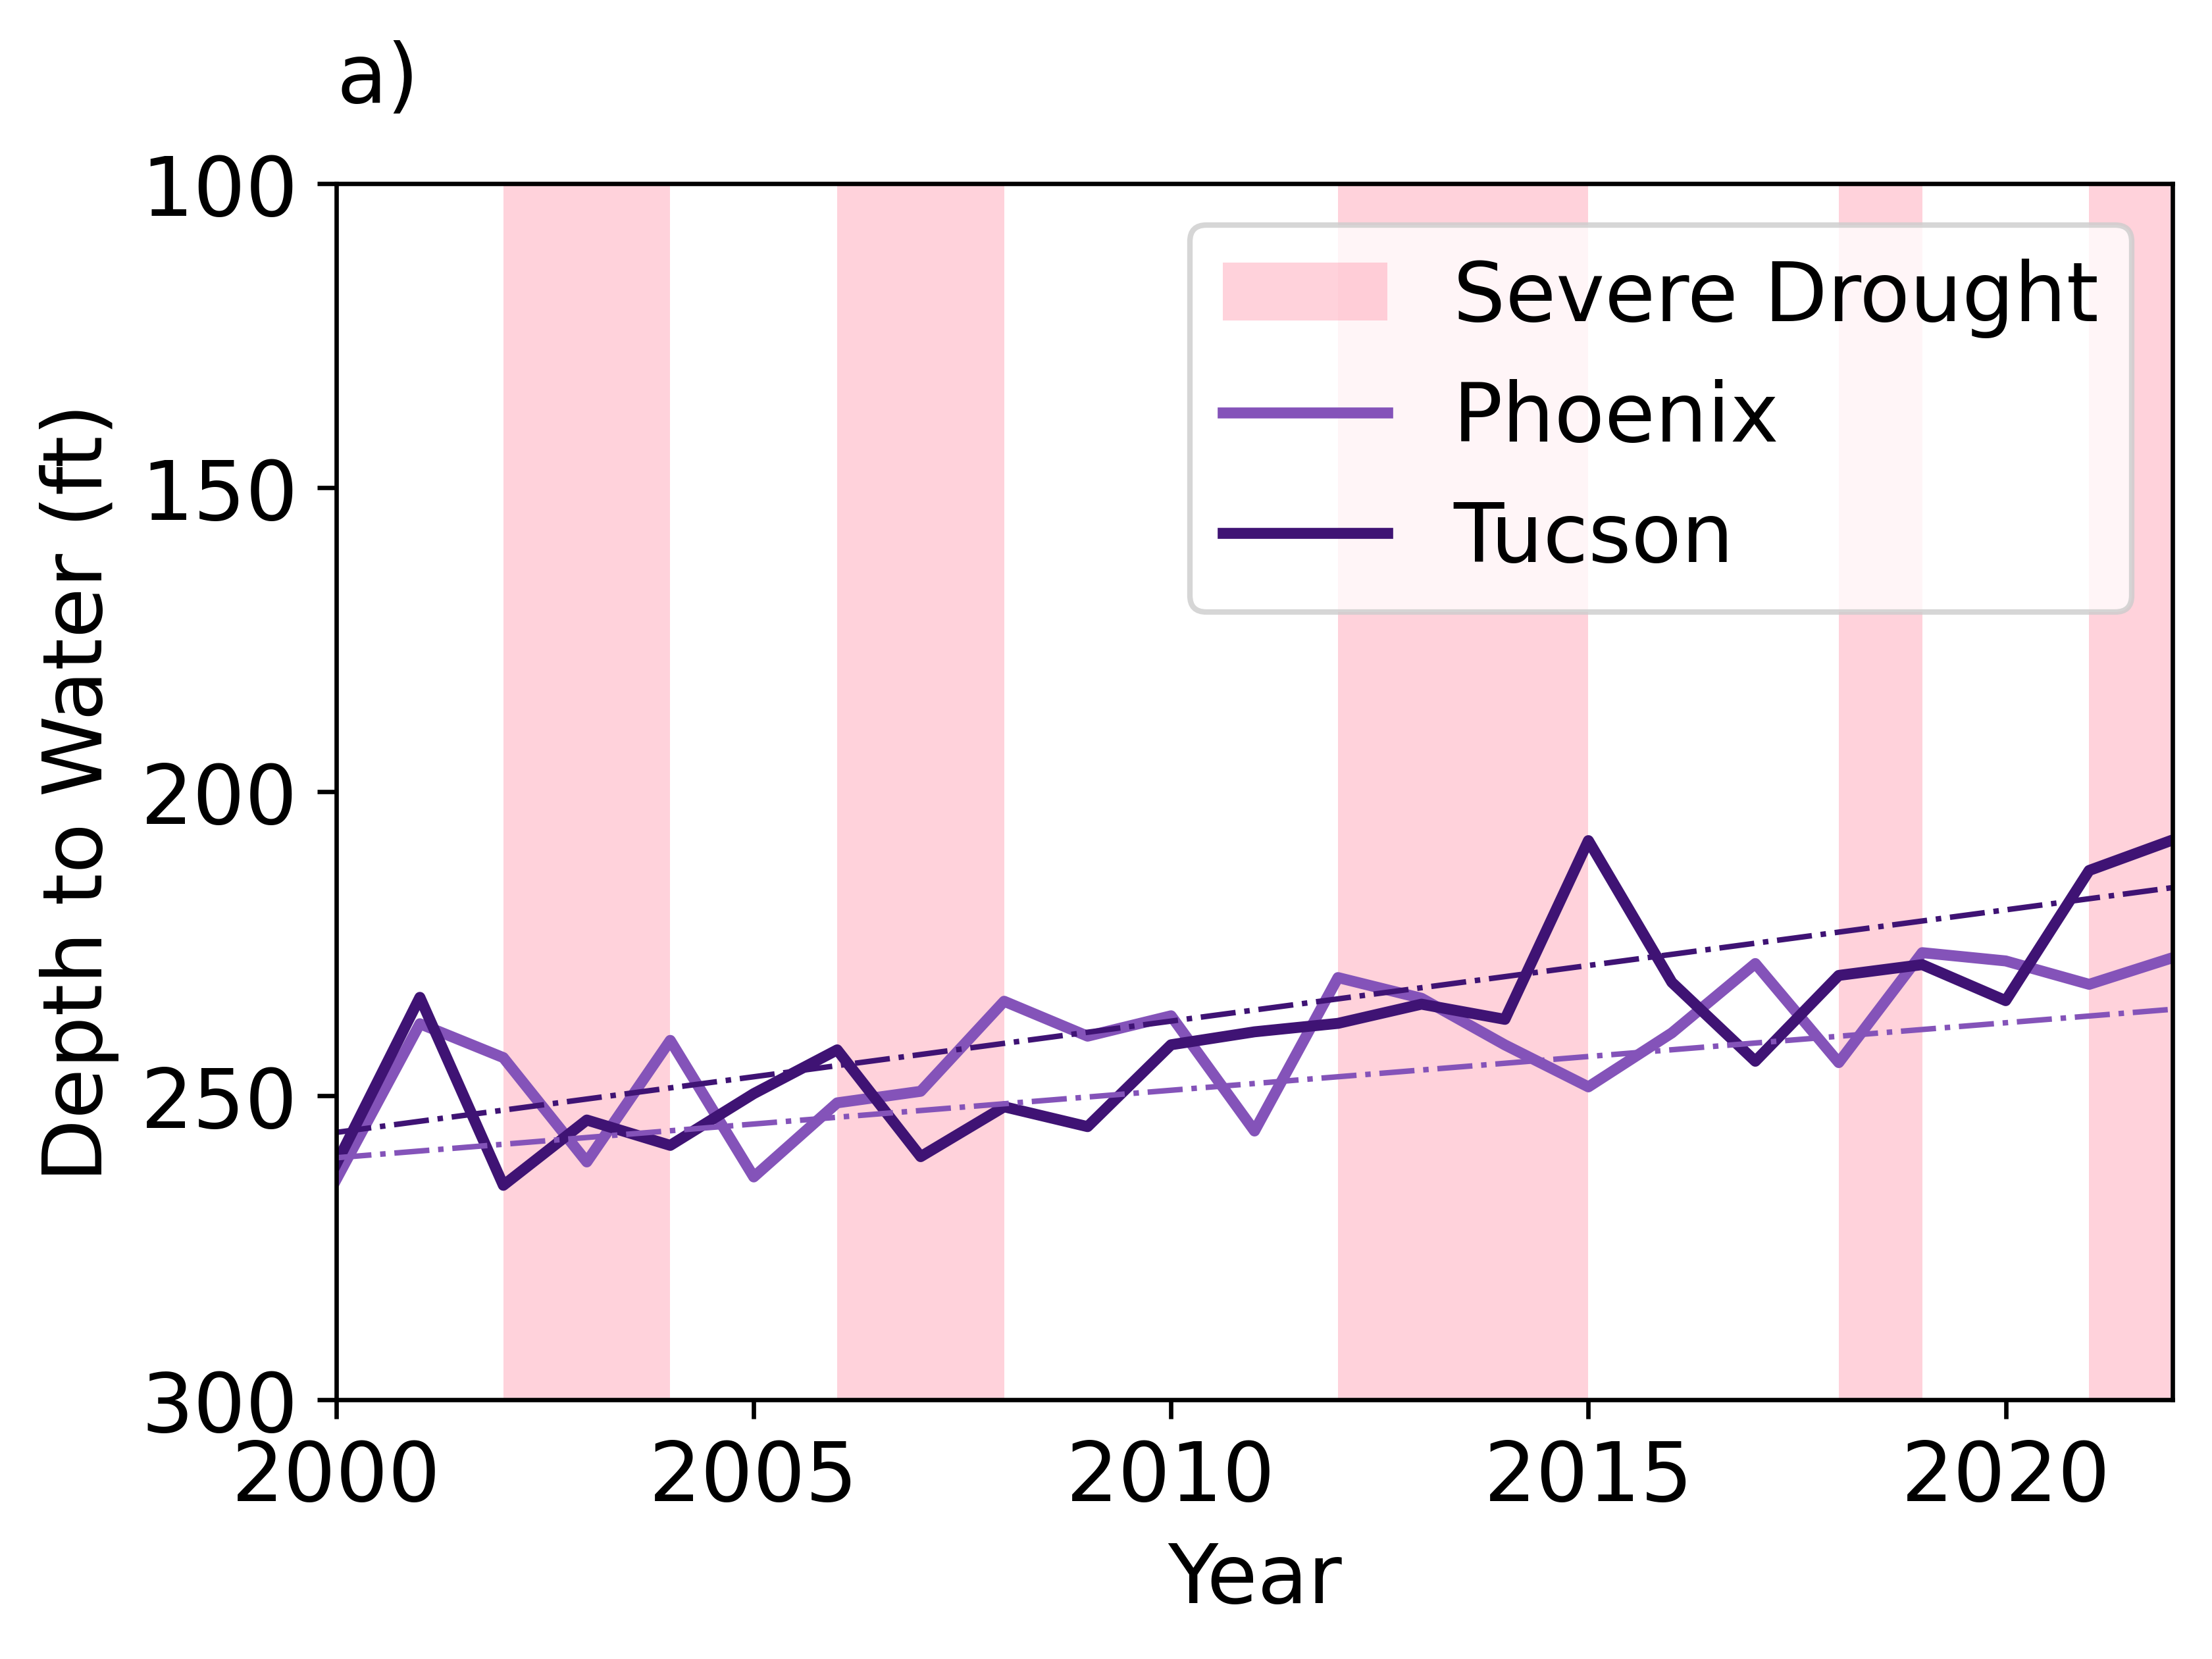

In [27]:
# Creating a timeseries plot of depth to water
# Customize this
Name = "mean_"+StudyArea
min_yr = 2000
mx_yr = 2022
min_y = 100
max_y = 300
fsize = 15

# Starting the plot
ds = test
betterlabels = ds.columns.tolist()

period = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = period[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats = stats.sort_values(by='slope', ascending=False)
stats1 = stats.transpose()
print(stats)
# stats.to_csv(outputpath+'Stats_'+StudyArea+'.csv')

# -- Data visualization --

fig, ax = plt.subplots(1, 1, figsize = (6,4))

# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Ensure that the labels are integers
ax.set_xticklabels(map(int, xticks))

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought")
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

# Plotting the data
for i,j in zip(stats1.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()

# Plotting Trendlines
for i,j in zip(stats1.columns,refined_cblind_colors):
        m1 = round(stats1.loc['slope',i], 2)
        yint1 = round(stats1.loc['int',i], 2)
        pval1 = round(stats1.loc['p_val',i], 4)
        yf1 = (m1*xf)+yint1
        ax.plot(xf1, yf1,"-.",color=j, lw=1)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(max_y,min_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='y', labelsize=fsize)
ax.tick_params(axis='x', labelsize = fsize, rotation=0)
fig.set_dpi(600.0)
ax.set_title('a)',loc='left',pad=15, fontsize=fsize)
ax.legend(loc='upper right',fontsize = fsize)
# ax.legend(loc=[1.1,0.5])


plt.savefig(figurepath+'/Figure8a', bbox_inches = 'tight')

In [28]:
# Anomaly's
# Need to redo this line for some reason
df = df_interpolated.drop(columns=columns_to_delete)
ds = df.copy()
column_list = df.columns.tolist()
trend_df = df.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        dataframe = ds[i]
        y=np.array(dataframe.values, dtype=float)
        x=np.array(pd.to_datetime(dataframe).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        trend_df[i] = (df.index*slope) + intercept
        dtw_anomalys[i] = df[i] - trend_df[i]

dtw_anomalys.head()

Phoenix  Tucson
index                 
2000      9.77    1.05
2001    -14.66  -24.46
2002     -7.98    8.27
2003     10.29   -0.64
2004     -8.59    5.36

Text(2000.5, 38, 'Dry')

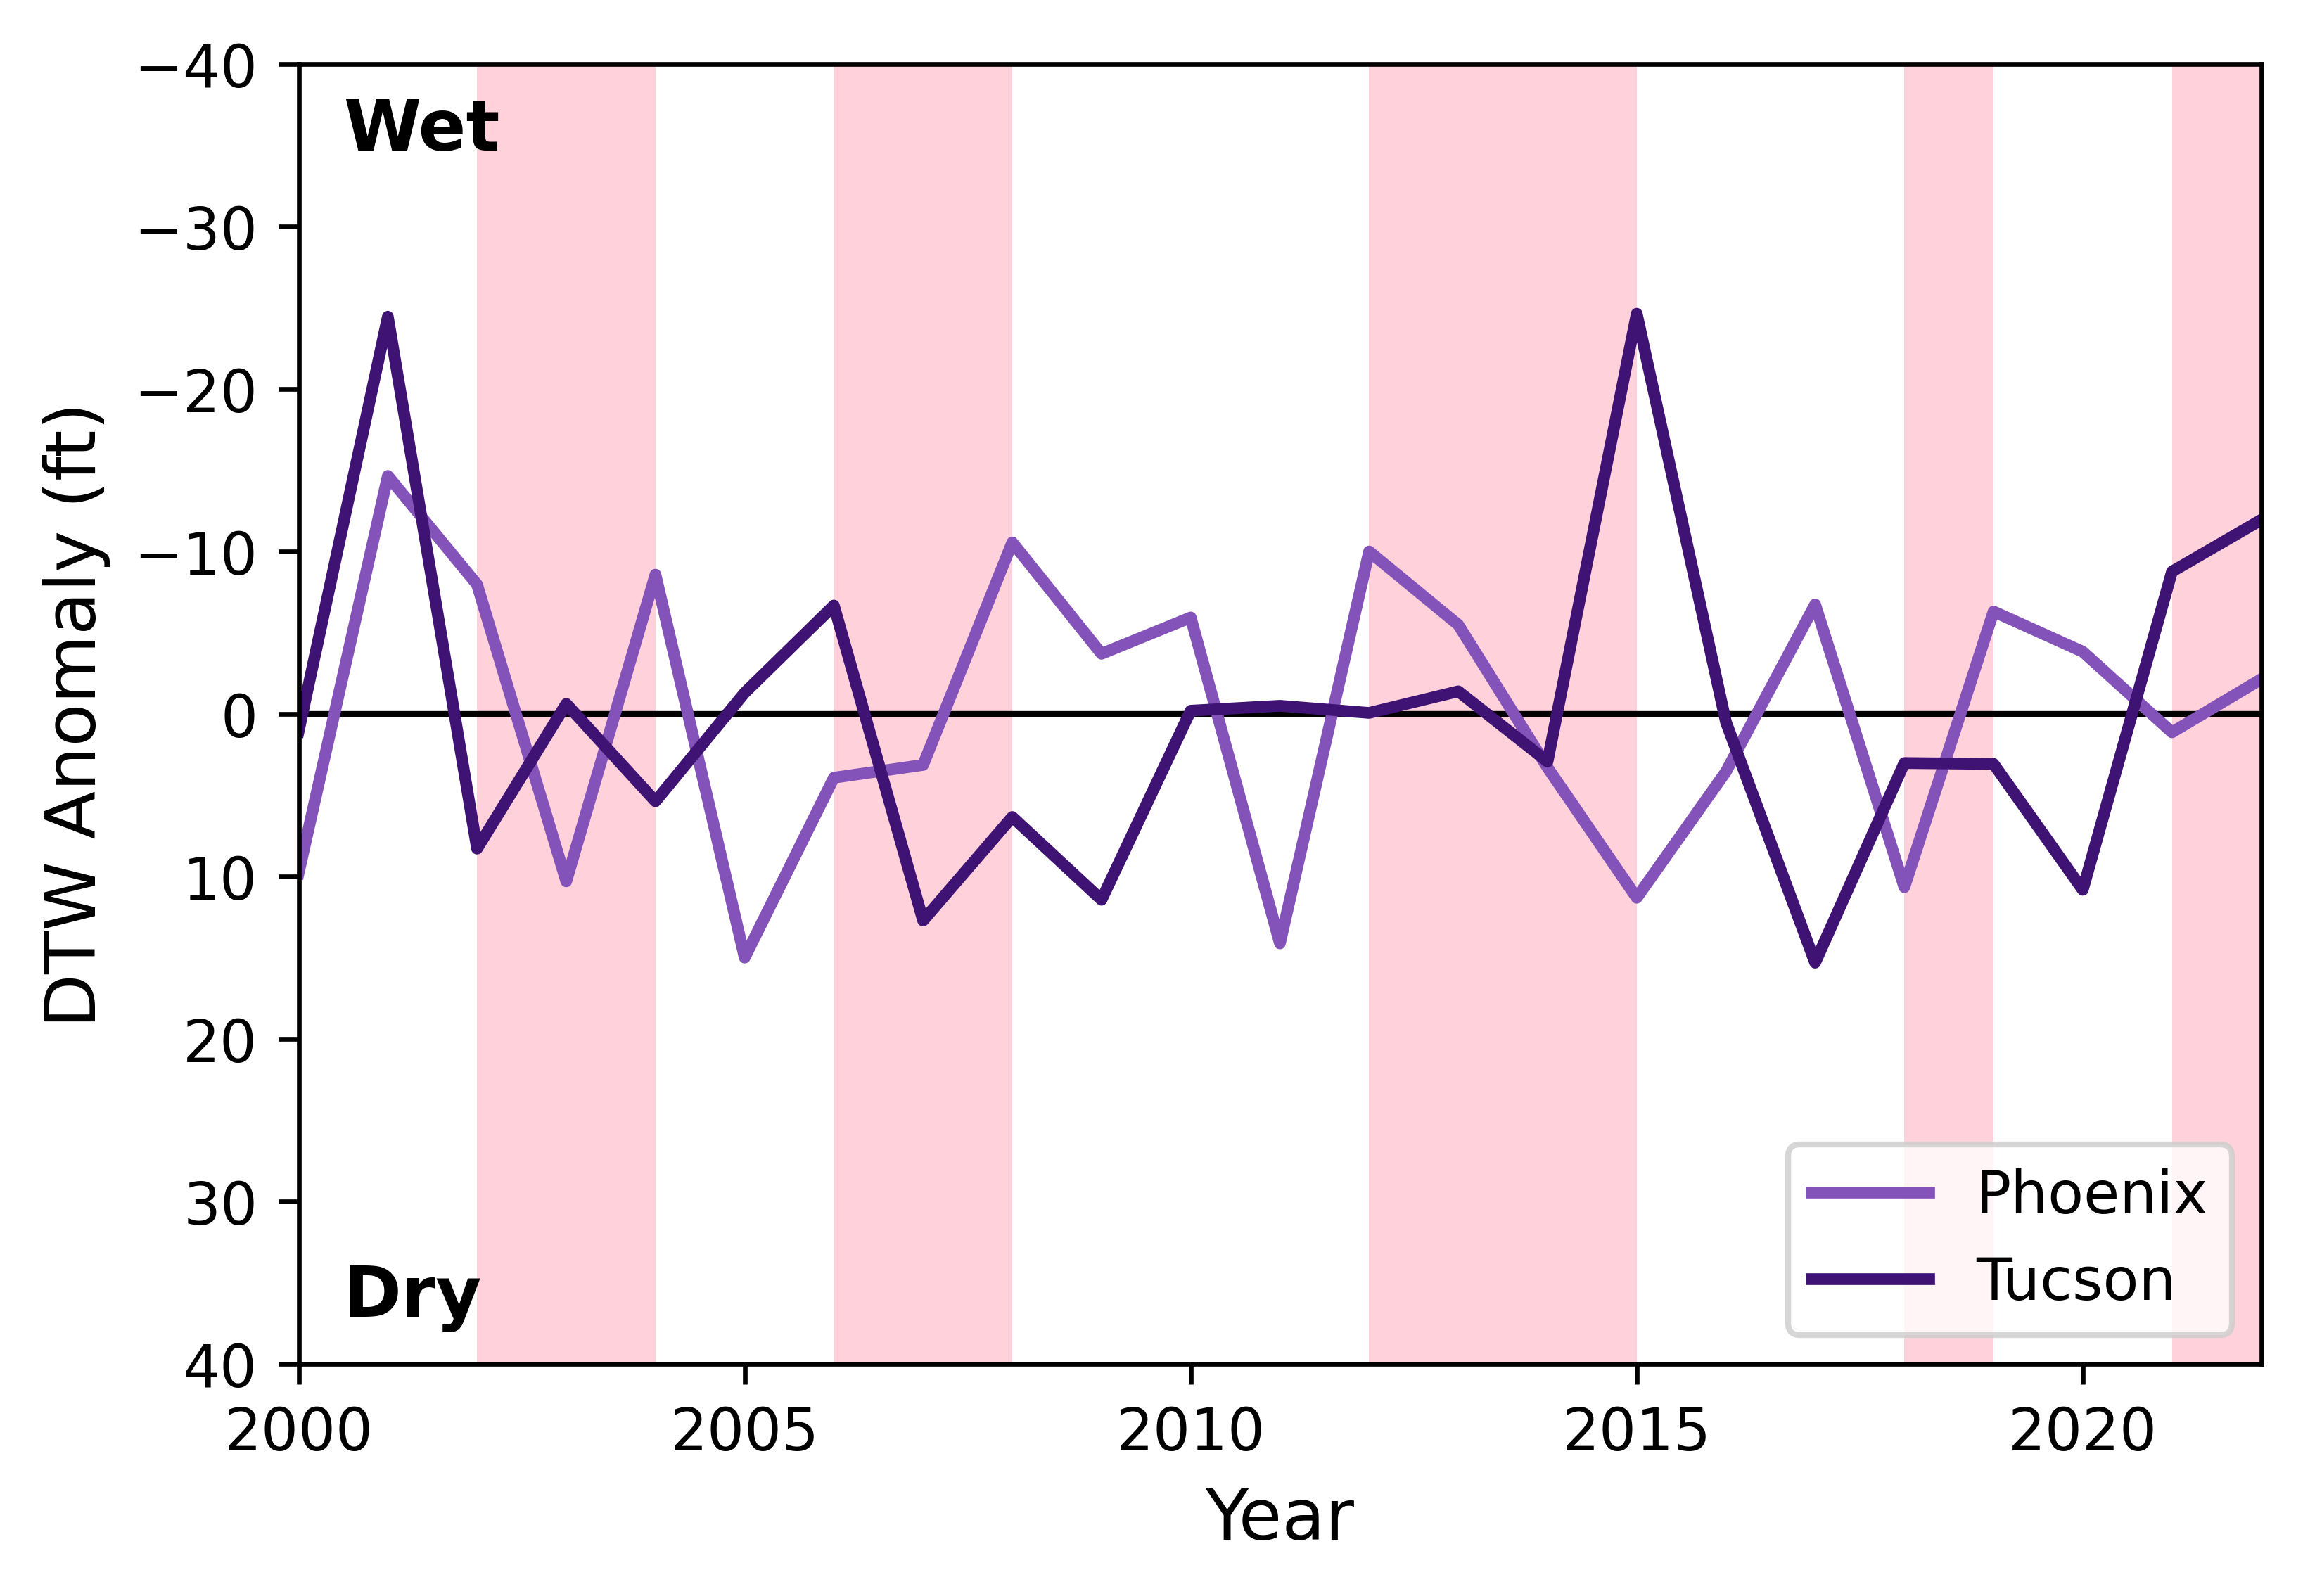

In [29]:
# For Depth to Water by regulation
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ylim = 40
fsize = 12
# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

plt.axhspan(0,0,color='black',lw=1)

for i,j in zip(ds.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(ylim,-ylim)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=0)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='lower right')

# Adding text inside the plot
ax.text(min_yr+0.5, 2-ylim, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, ylim-2, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# plt.savefig(figurepath+'/Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

Results for Phoenix & Tucson (2000-2022):
Kendall Correlation coefficient
 Phoenix:
  tau = -0.075
  pval = 0.6382
 Tucson:
  tau = -0.091
  pval = 0.5653
Spearman Correlation coefficient
 Phoenix:
  rho = -0.104
  pval = 0.6376
 Tucson:
  rho = -0.172
  pval = 0.4328
Pearson Correlation coefficient
 Phoenix:
  rsq = 0.004
  pval = 0.7648
 Tucson:
  rsq = 0.072
  pval = 0.217



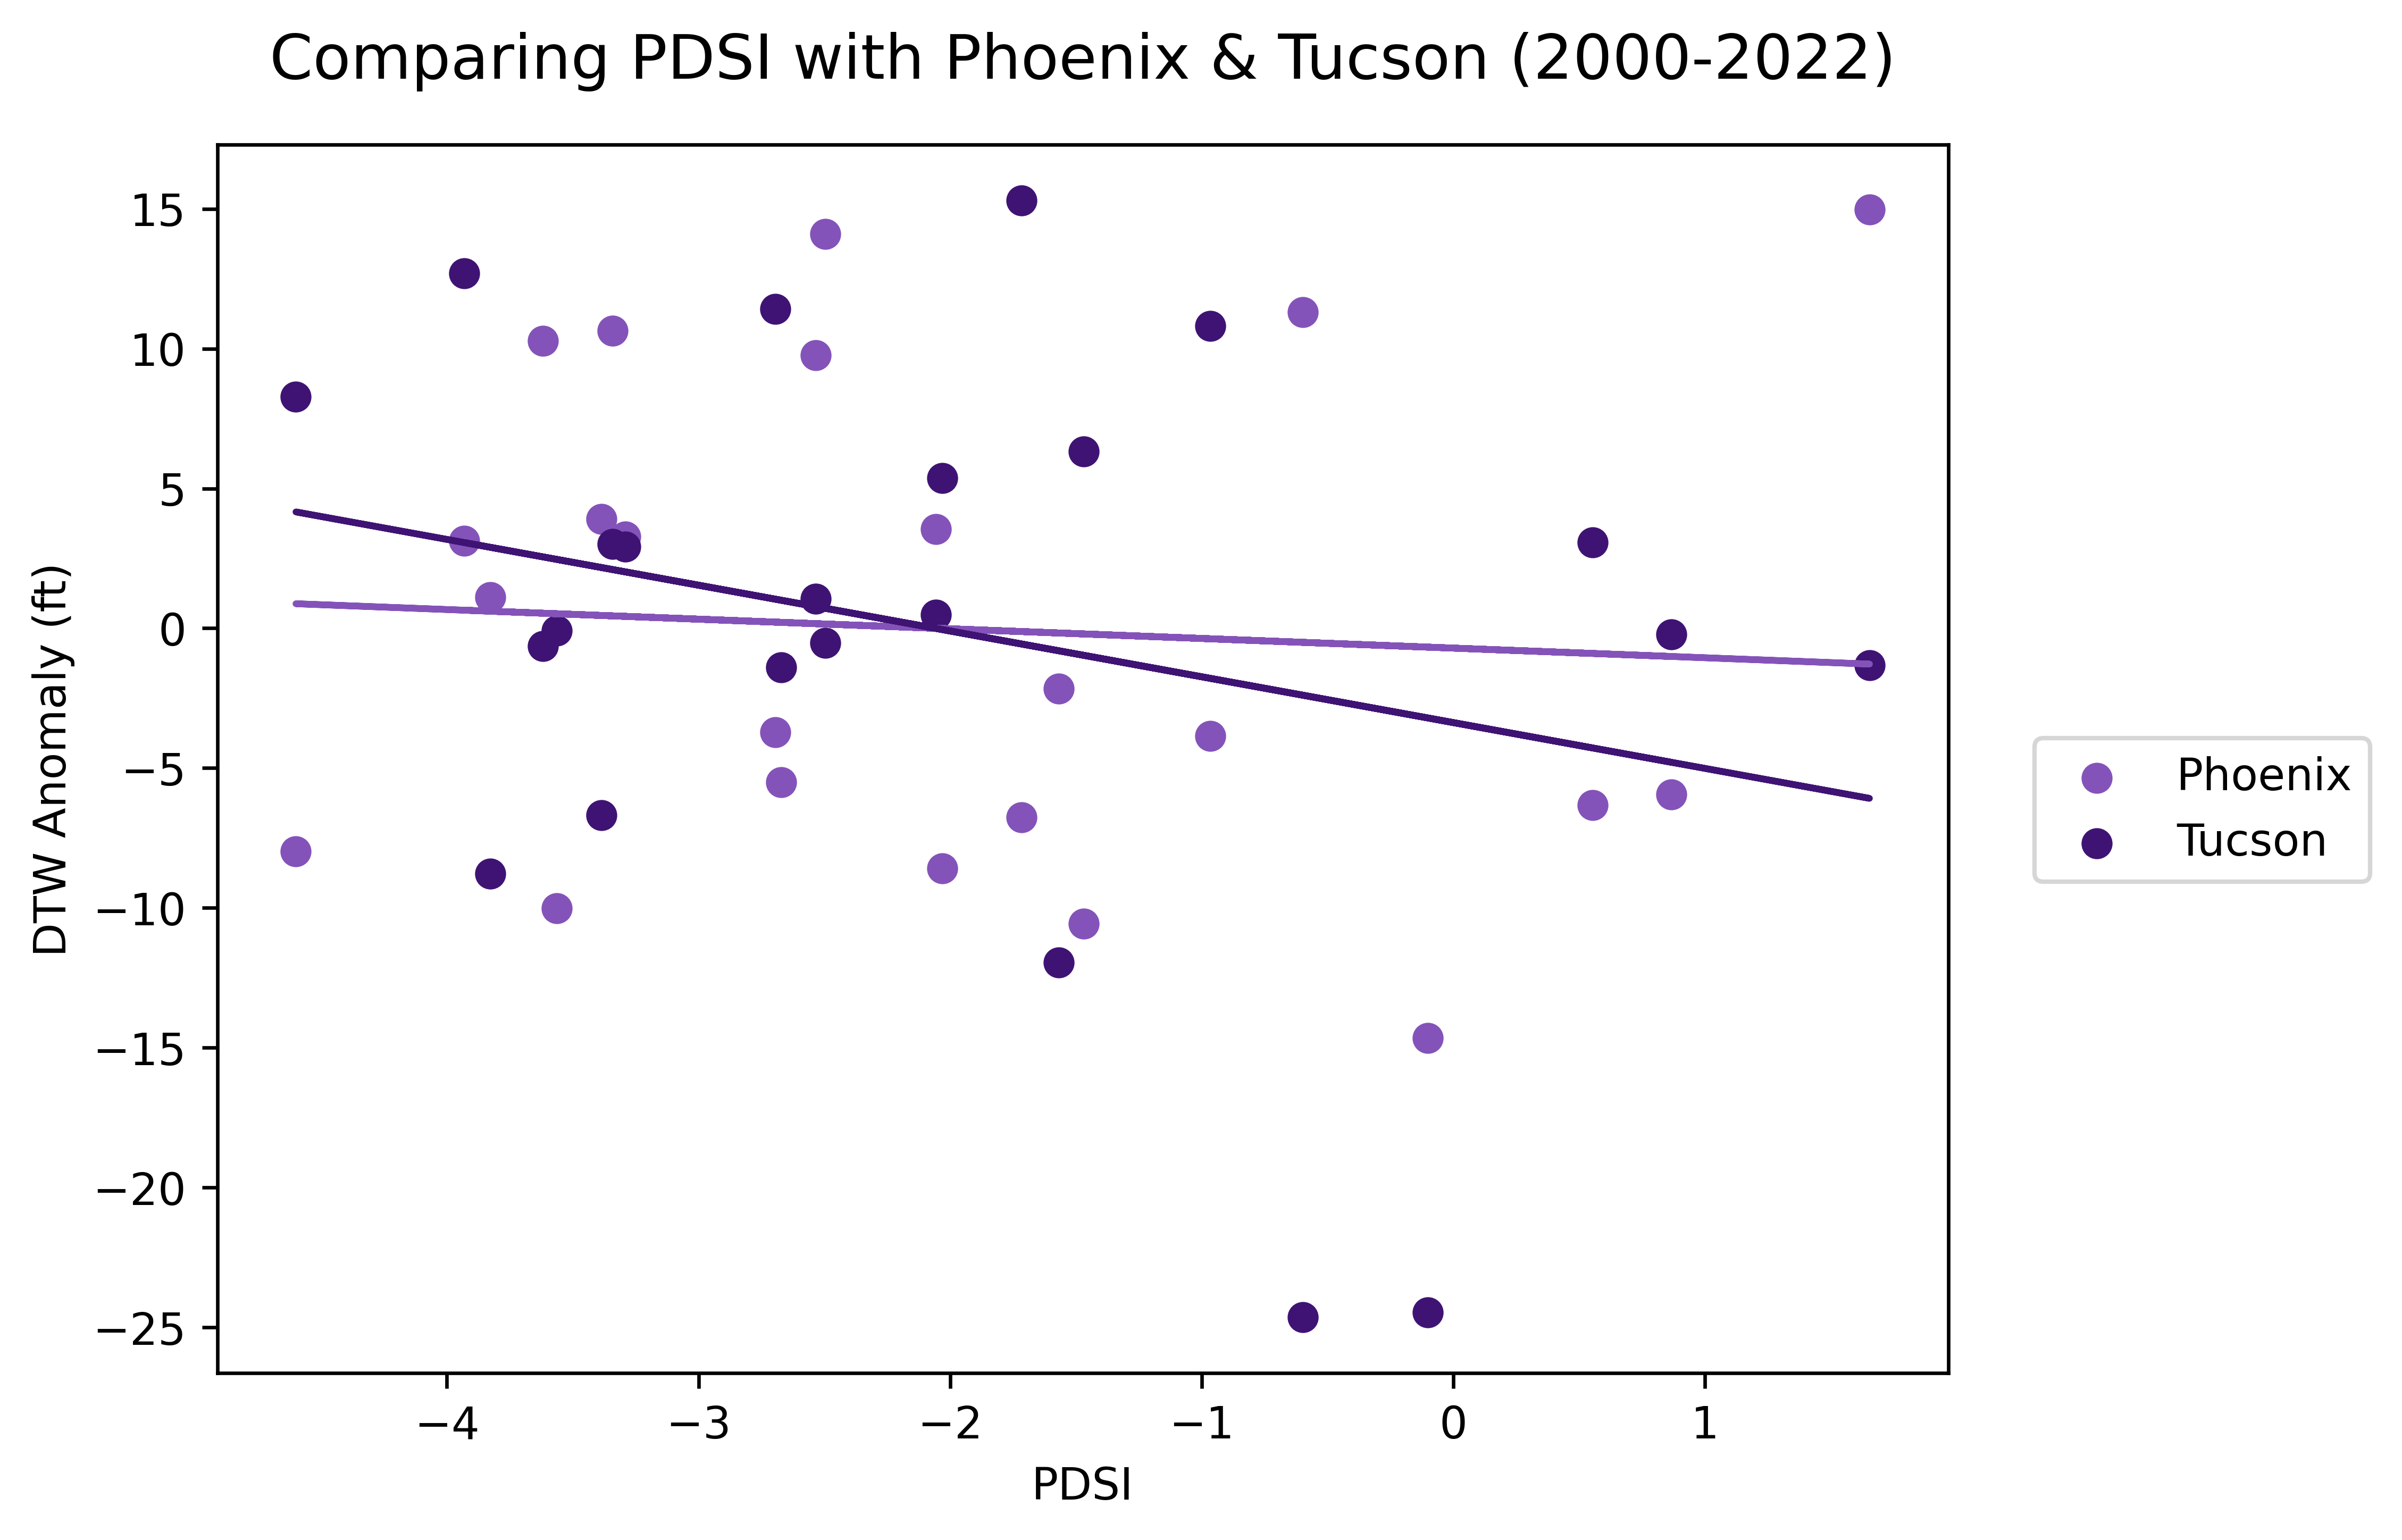

In [30]:
test_name = StudyArea+" ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices
lag = 0
indice = 'PDSI'

vert_axis = "DTW Anomaly (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,refined_cblind_colors,betterlabels,vert_axis)
print(result)

Results for Phoenix & Tucson (2000-2022):
Kendall Correlation coefficient
 Phoenix:
  tau = -0.146
  pval = 0.3457
 Tucson:
  tau = -0.067
  pval = 0.676
Spearman Correlation coefficient
 Phoenix:
  rho = -0.149
  pval = 0.4968
 Tucson:
  rho = -0.118
  pval = 0.5931
Pearson Correlation coefficient
 Phoenix:
  rsq = 0.0
  pval = 0.9218
 Tucson:
  rsq = 0.019
  pval = 0.536



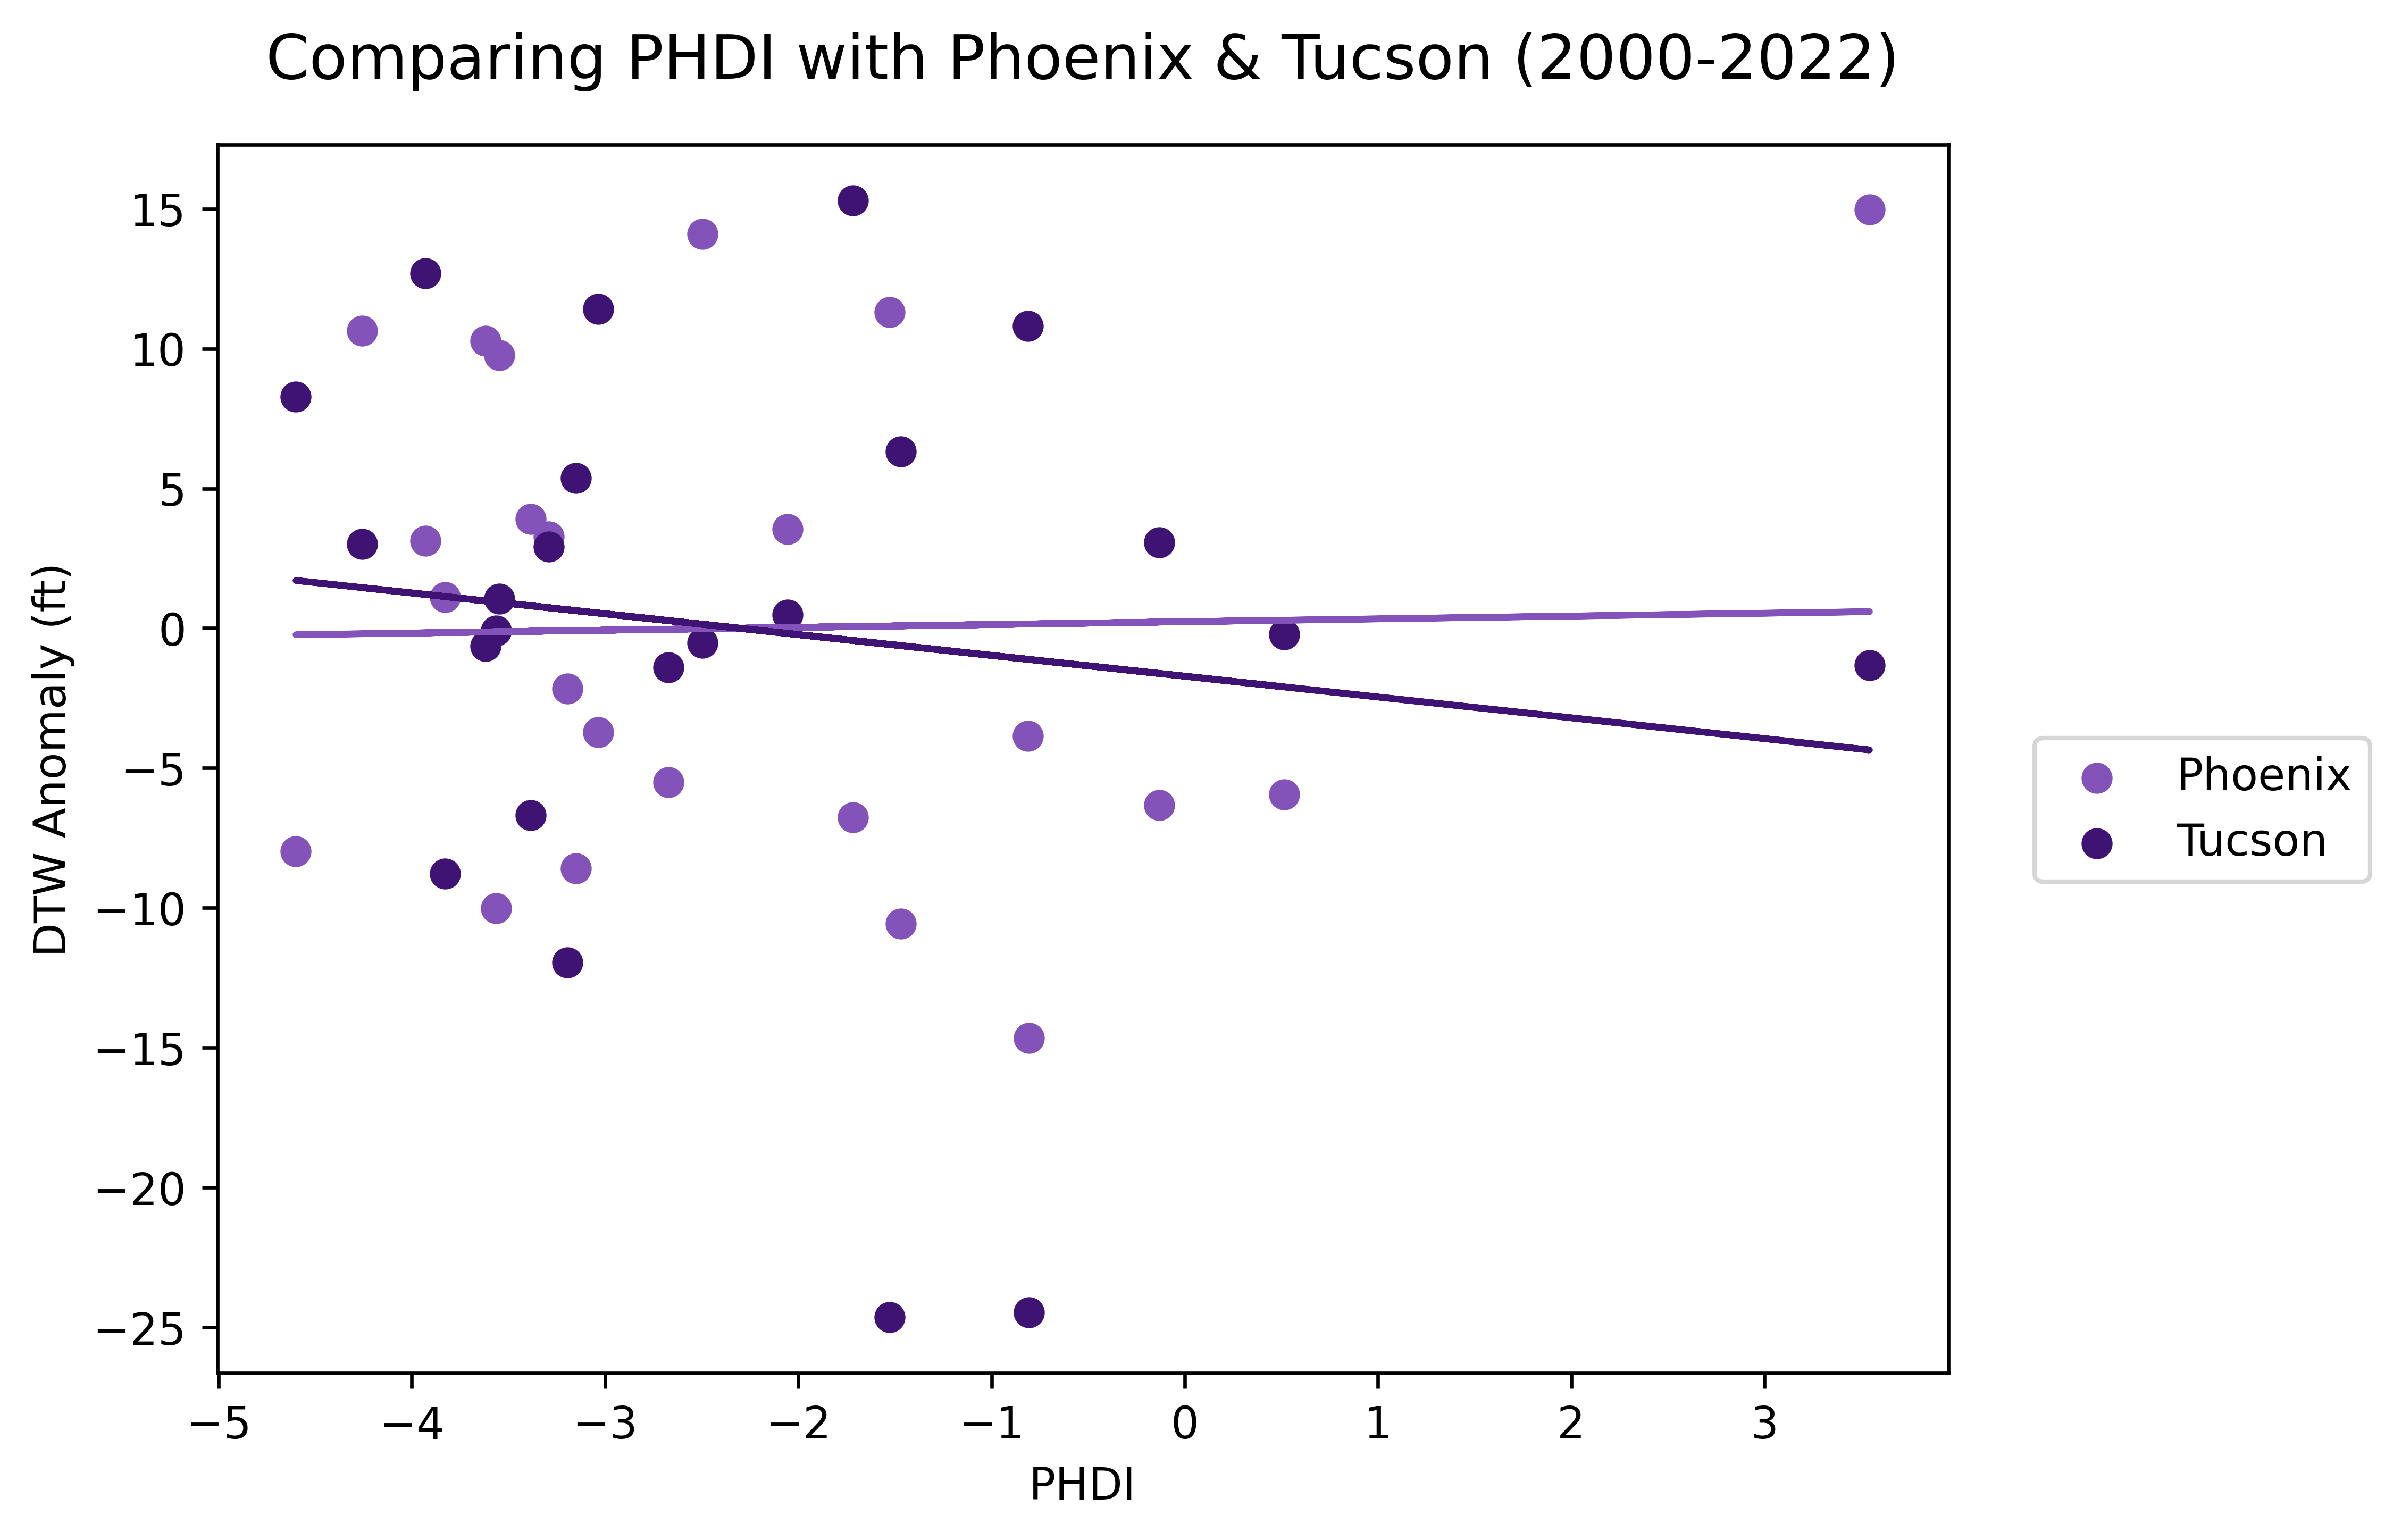

In [31]:
test_name = StudyArea+" ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices
lag = 0
indice = 'PHDI'

vert_axis = "DTW Anomaly (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,refined_cblind_colors,betterlabels,vert_axis)
print(result)

Calculating Max Drawdown (maximum anomaly in the drought period)

In [32]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

Phoenix  Tucson
Status                     
Drought 3     10.29    8.27
Drought 4      3.91   12.70
Drought 5      3.29    2.92
Drought 6     10.65    3.00
Drought 7      1.12   -8.77
Normal-Wet    14.98   15.29

In [33]:
# Reorder the dataframe

test = pd.DataFrame()
test['Phoenix'] = dtw_max_anomalies['Phoenix']
test['Tucson'] = dtw_max_anomalies['Tucson']
test

Phoenix  Tucson
Status                     
Drought 3     10.29    8.27
Drought 4      3.91   12.70
Drought 5      3.29    2.92
Drought 6     10.65    3.00
Drought 7      1.12   -8.77
Normal-Wet    14.98   15.29

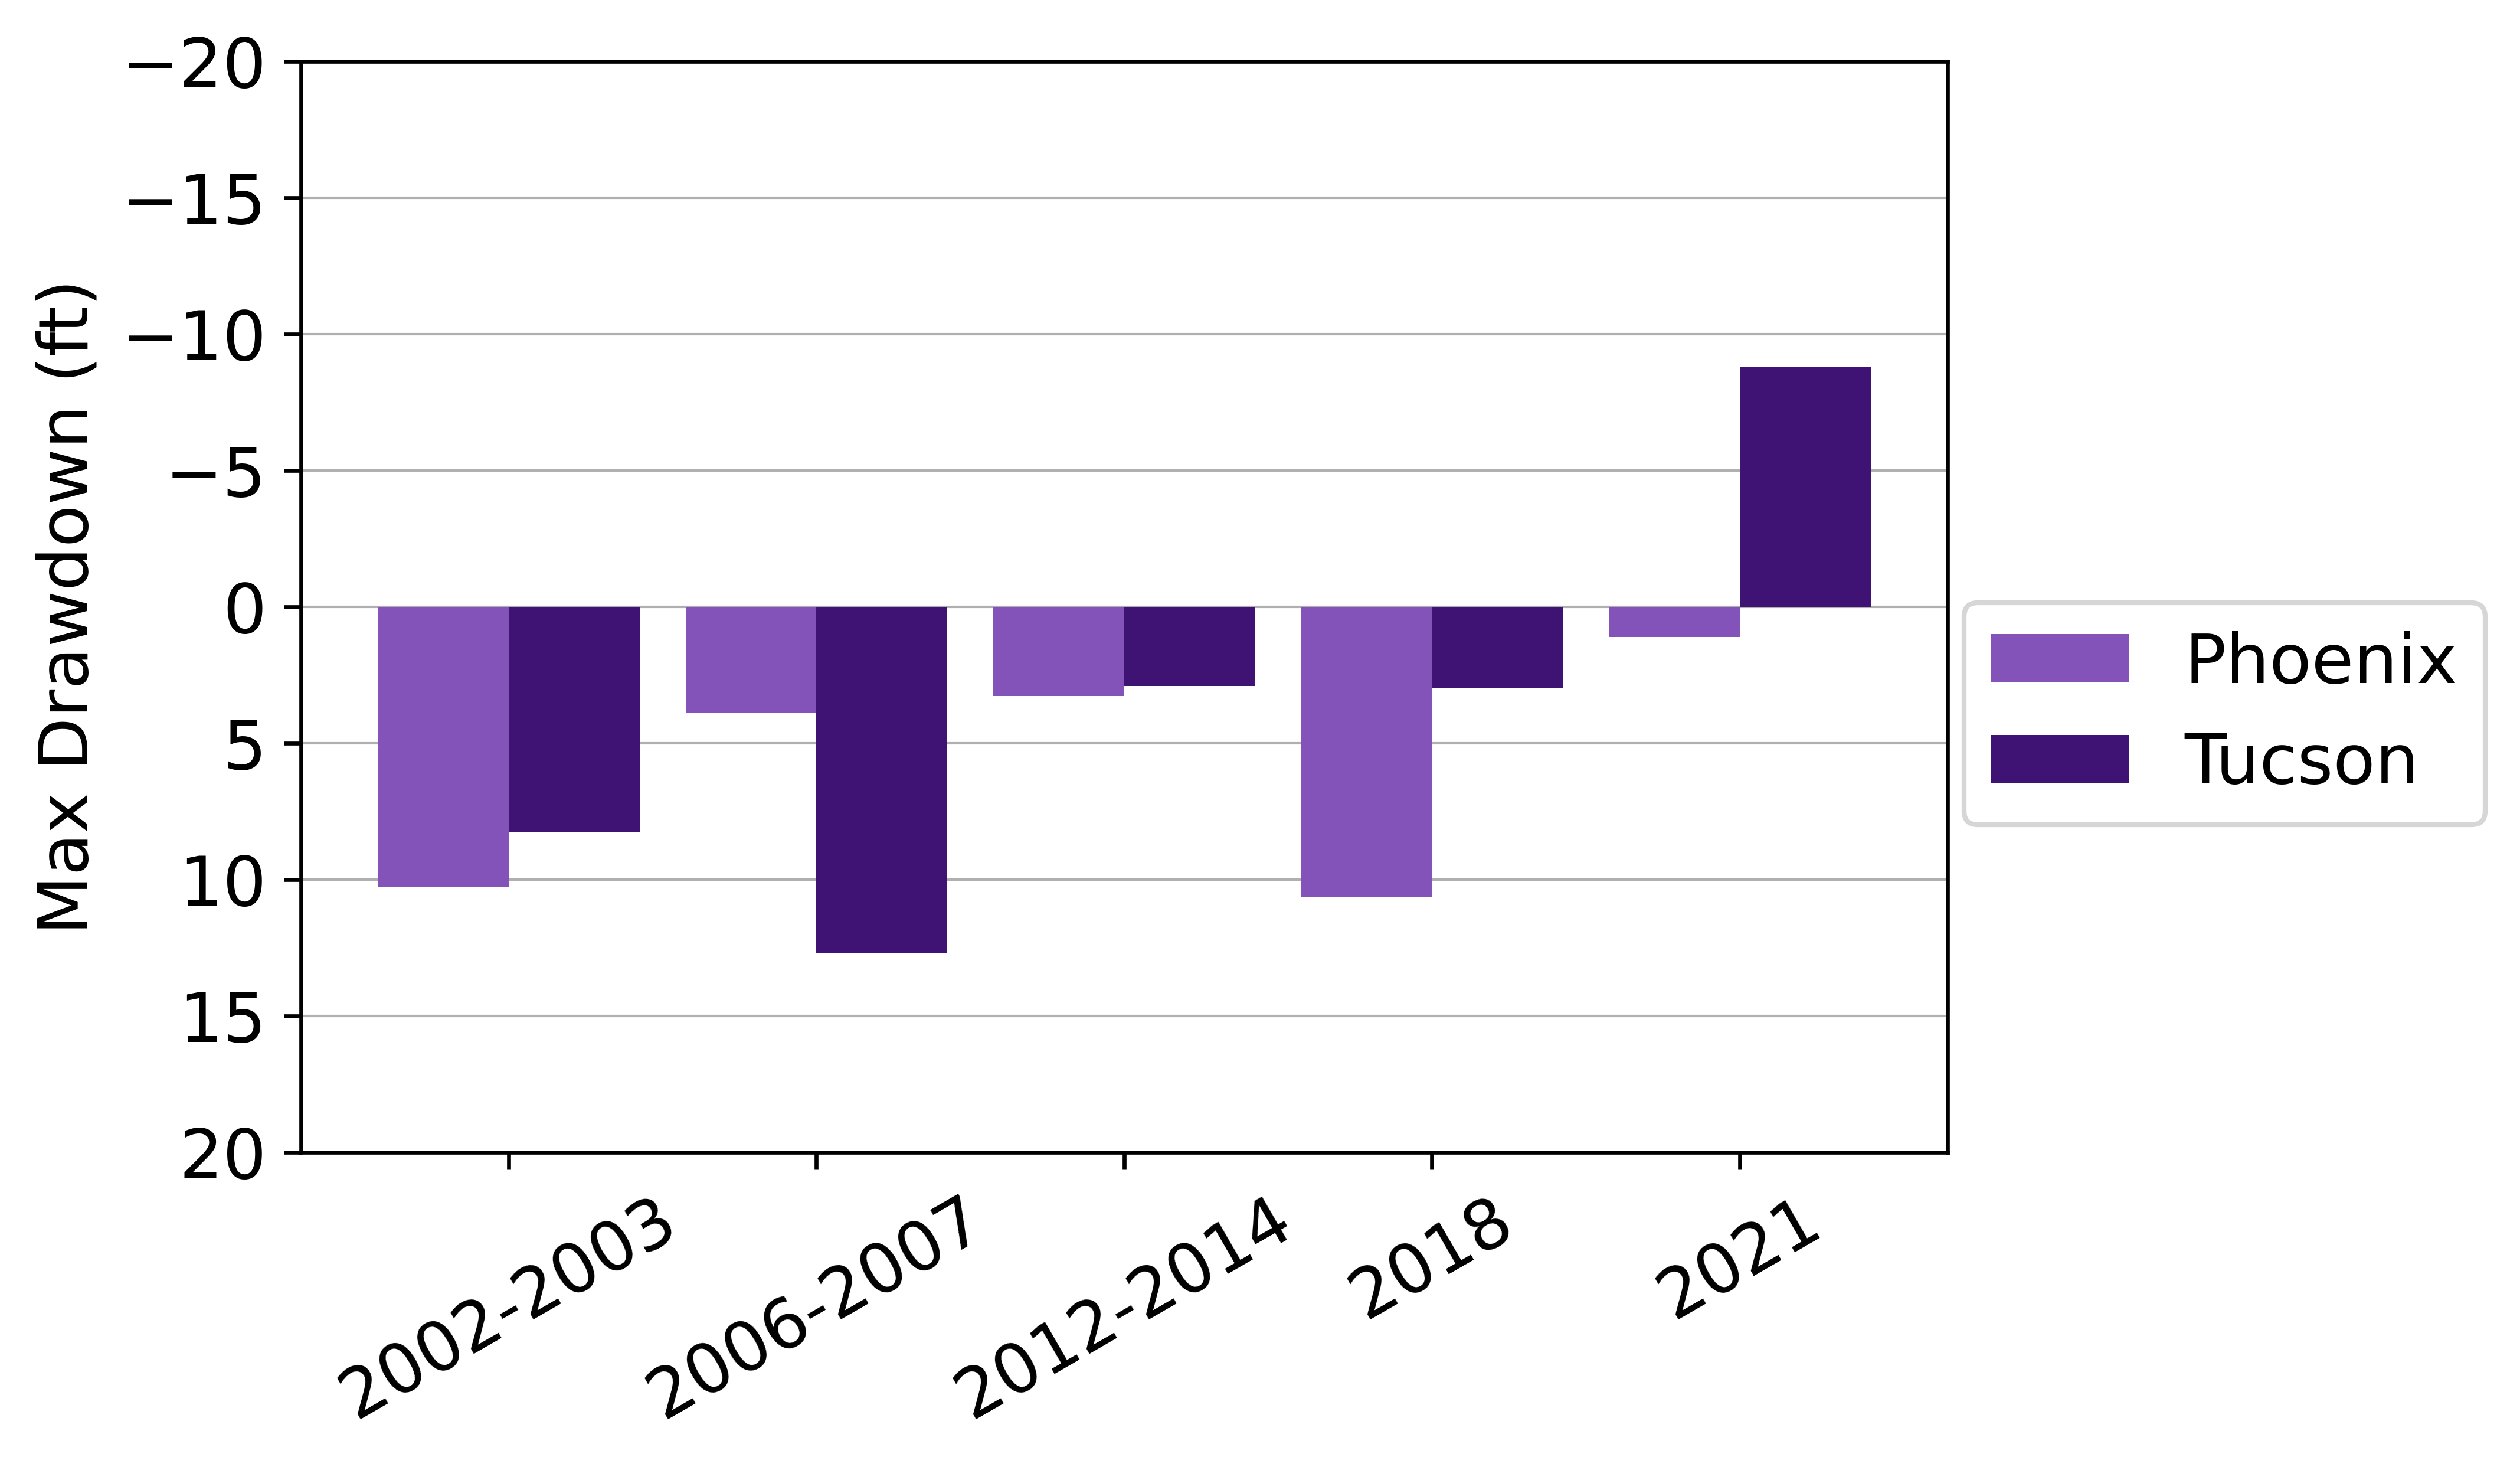

In [34]:
# Customize this
name = 'Max Drawdown by Drought Period for '+StudyArea
ylim = 20
vertlabel = 'Max Drawdown (ft)'
fsize = 14

# Starting the plot
ds = test
yearlabels = [
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
betterlabels = ds.columns.tolist()

ds.index = yearlabels
ds = ds.transpose()
ds.index = betterlabels
del ds['Normal/Wet Years']
ds = ds.transpose()

group_colors =refined_cblind_colors

plt.rcParams["figure.dpi"] = 600
ds.plot(figsize = (6,4),
        kind='bar',
        stacked=False,
        # title=name,
        # color = group_colors,
        color = refined_cblind_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
# plt.title(name, fontsize = (fsize+2))
plt.ylim([ylim,-ylim])
plt.ylabel(vertlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+'/Figure8b', bbox_inches = 'tight')

In [35]:
# New wells

static_geo2['INSTALLED'] = pd.to_datetime(static_geo2['INSTALLED'])

static_geo2['In_year'] = static_geo2['INSTALLED'].dt.year
new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col], values=["INSTALLED"], dropna=False, aggfunc=len)

new_wells.to_csv(outputpath+'/Final_NewWells_'+StudyArea+'.csv')

In [36]:
# To get it formatted correctly
all_columns = wlanalysis_period.columns.tolist()
new_wells2 = pd.read_csv(outputpath+'/Final_NewWells_'+StudyArea+'.csv',
                        header=2,
                        names = all_columns
                        , index_col=0
                        )
new_wells2

Control  Douglas  Flagstaff  GSF/USF  GilaBend  Harquahala  \
1900.00      NaN     1.00       1.00      NaN       NaN         NaN   
1910.00      NaN      NaN        NaN      NaN       NaN         NaN   
1915.00      NaN      NaN        NaN      NaN       NaN         NaN   
1916.00      NaN      NaN        NaN      NaN       NaN         NaN   
1917.00      NaN      NaN        NaN      NaN       NaN         NaN   
...          ...      ...        ...      ...       ...         ...   
2020.00      NaN    19.00      11.00     5.00      2.00        4.00   
2021.00     3.00    27.00      11.00     1.00      3.00        1.00   
2022.00     1.00    24.00      13.00     3.00      1.00        2.00   
2023.00     1.00    15.00       9.00     1.00      4.00         NaN   
2024.00      NaN      NaN       4.00      NaN      3.00        1.00   

         LittleCoR  McMullen  Phoenix  RanegrasPlain  SaltRiver  Tucson  USF  \
1900.00        NaN       NaN     1.00            NaN        NaN     NaN  NaN   
1910.00       1.00       NaN      NaN            NaN        NaN     NaN  NaN   
1915.00        NaN       NaN      NaN            NaN        NaN    2.00  NaN   
1916.00       1.00       NaN      NaN            NaN        NaN     NaN  NaN   
1917.00       1.00       NaN      NaN            NaN        NaN     NaN  NaN   
...            ...       ...      ...            ...        ...     ...  ...   
2020.00      93.00     10.00    62.00           7.00      10.00   28.00  NaN   
2021.00      77.00     11.00    49.00           6.00      29.00   17.00 2.00   
2022.00      69.00      8.00    53.00           8.00       6.00   23.00  NaN   
2023.00      50.00      7.00    39.00           3.00       5.00   12.00 4.00   
2024.00       4.00      2.00     6.00           1.00        NaN    6.00  NaN   

         Verde  Wilcox  Yuma  
1900.00    NaN    1.00   NaN  
1910.00    NaN     NaN   NaN  
1915.00    NaN     NaN   NaN  
1916.00    NaN     NaN   NaN  
1917.00    NaN     NaN   NaN  
...        ...     ...   ...  
2020.00  42.00   73.00 43.00  
2021.00  38.00   66.00 71.00  
2022.00  28.00   72.00 40.00  
2023.00   3.00   23.00 30.00  
2024.00   4.00    6.00   NaN  

[107 rows x 16 columns]

In [37]:
new_wells2 = new_wells2.drop(columns=columns_to_delete)
new_wells2.to_csv(outputpath+'/Final_NewWells_'+StudyArea+'.csv')
new_wells2

Phoenix  Tucson
1900.00     1.00     NaN
1910.00      NaN     NaN
1915.00      NaN    2.00
1916.00      NaN     NaN
1917.00      NaN     NaN
...          ...     ...
2020.00    62.00   28.00
2021.00    49.00   17.00
2022.00    53.00   23.00
2023.00    39.00   12.00
2024.00     6.00    6.00

[107 rows x 2 columns]

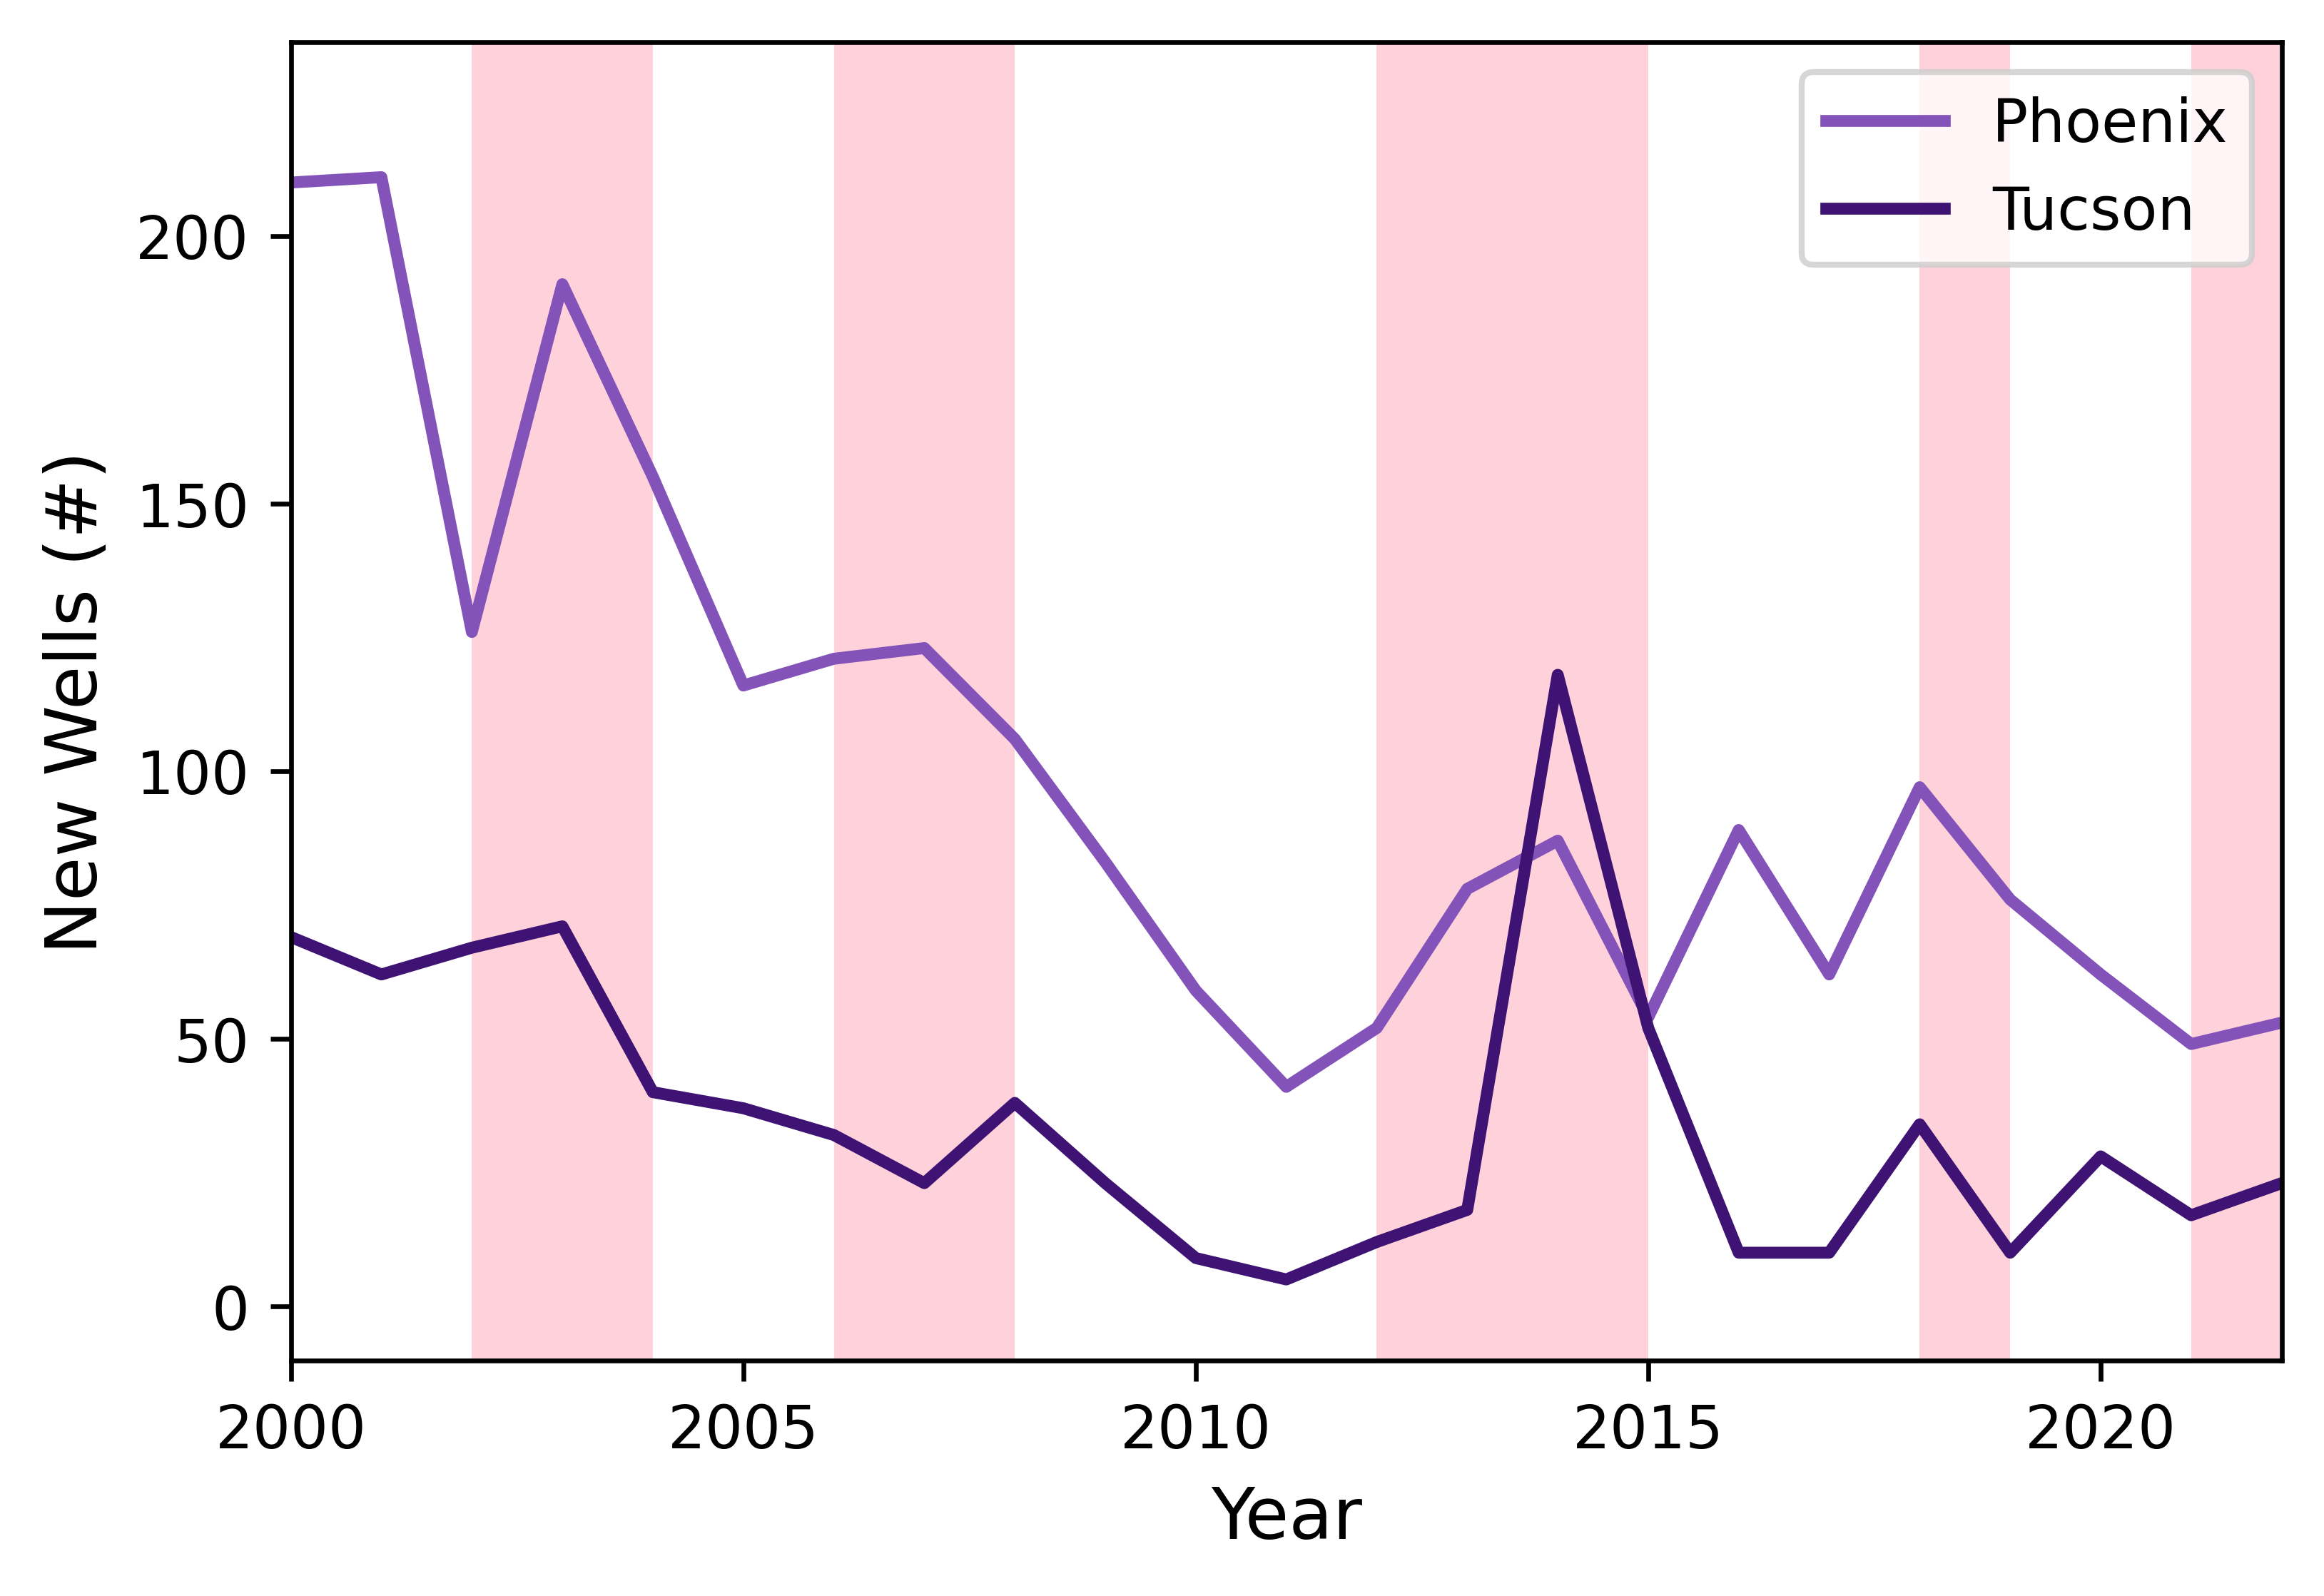

In [38]:
# Customize this
ds = new_wells2
min_yr = 2000
mx_yr = 2022
min_y = -12
max_y = 15
fsize = 12

# Starting the plot
columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

for i,j in zip(ds.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
        
ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel('New Wells (#)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# plt.savefig(figurepath+'Timeseries of New Wells for '+StudyArea, bbox_inches = 'tight')

Now for Gila Bend & Verde

In [39]:
StudyArea = 'Gila Bend & Verde'

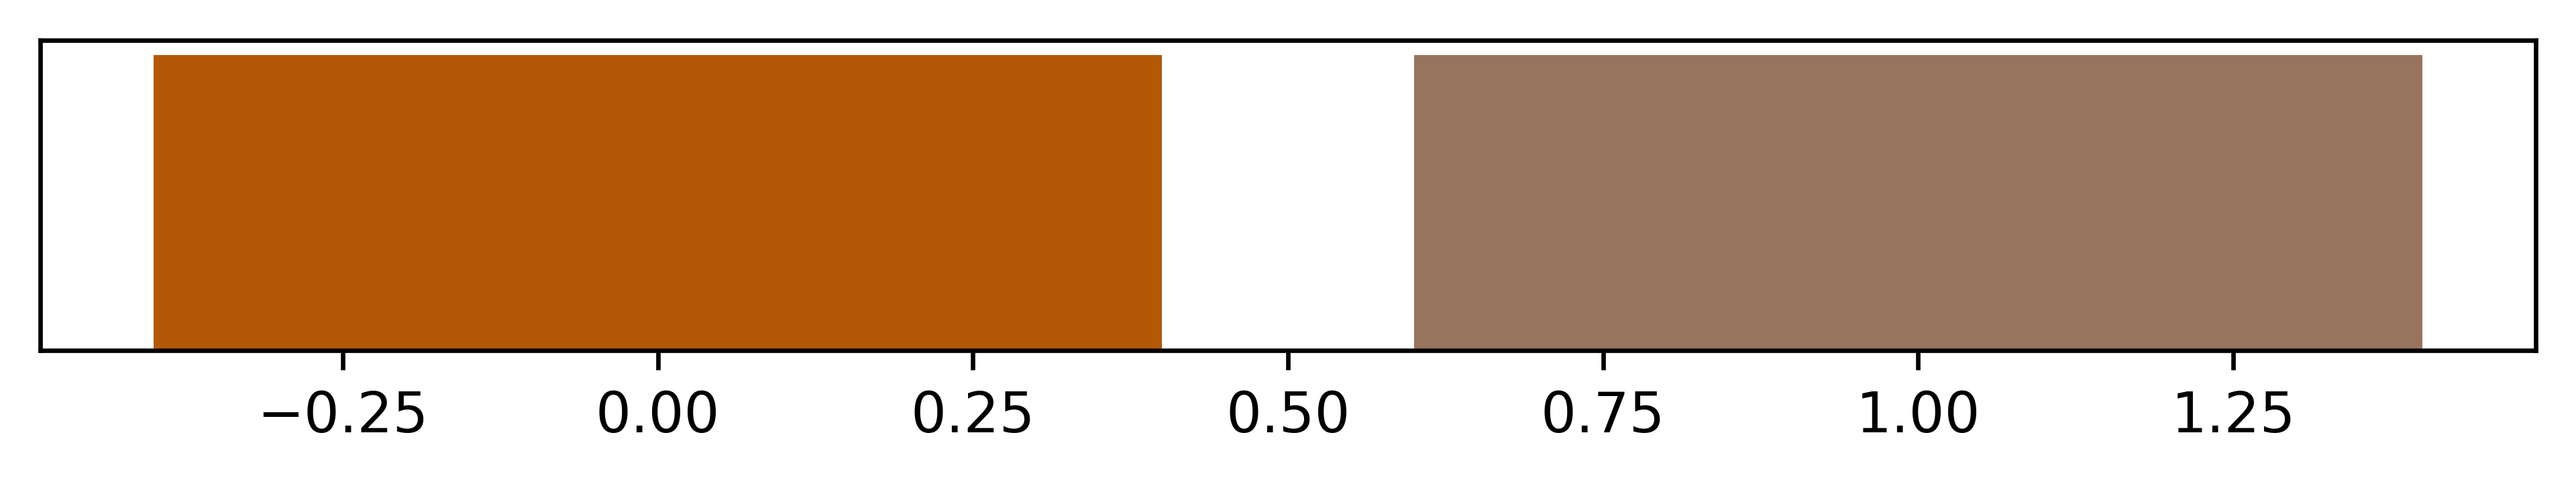

In [40]:
# This is to delete some columns as needed
columns_to_delete = ['Control','GSF/USF','USF'
                     ,'Harquahala'
                     ,'SaltRiver'
                     ,'Douglas'
                    #  ,'Verde','GilaBend'
                     ,'Tucson','Phoenix'
                     ,'McMullen'
                     ,'RanegrasPlain'
                     ,'Flagstaff'
                     ,'LittleCoR'
                     ,'Yuma'
                    ,'Wilcox'
                    ]
df = df_interpolated.drop(columns=columns_to_delete)

# Colors for Gilabend and Verde
refined_cblind_colors = ['#b35806', '#98745c']

# Create a bar plot to visualize colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(refined_cblind_colors)), height=1, color=refined_cblind_colors)

# Remove y-axis
ax.set_yticks([])

# Show the plot
plt.show()

In [41]:
# Reorder the dataframe

test = pd.DataFrame()
test['Verde'] = df['Verde']
test['Gila Bend'] = df['GilaBend']
test

Verde  Gila Bend
index                  
2000  241.87     228.68
2001  225.21     233.61
2002  191.56     237.35
2003  201.37     250.58
2004  212.18     261.80
2005  199.98     212.51
2006  201.02     254.31
2007  193.69     275.91
2008  178.03     283.52
2009  195.09     287.48
2010  196.40     271.54
2011  185.43     282.74
2012  209.74     294.48
2013  204.88     291.61
2014  180.37     279.73
2015  196.53     288.59
2016  199.26     320.58
2017  206.40     294.40
2018  211.79     331.32
2019  210.45     322.84
2020  207.85     362.77
2021  231.68     365.74
2022  215.28     375.43

           slope       int  rsq  p_val  std_err   mean     var     sum
Gila Bend   5.95 -11680.01 0.85   0.00     0.54 287.28 1826.59 6607.52
Verde       0.07     65.65 0.00   0.89     0.49 204.18  221.13 4696.04


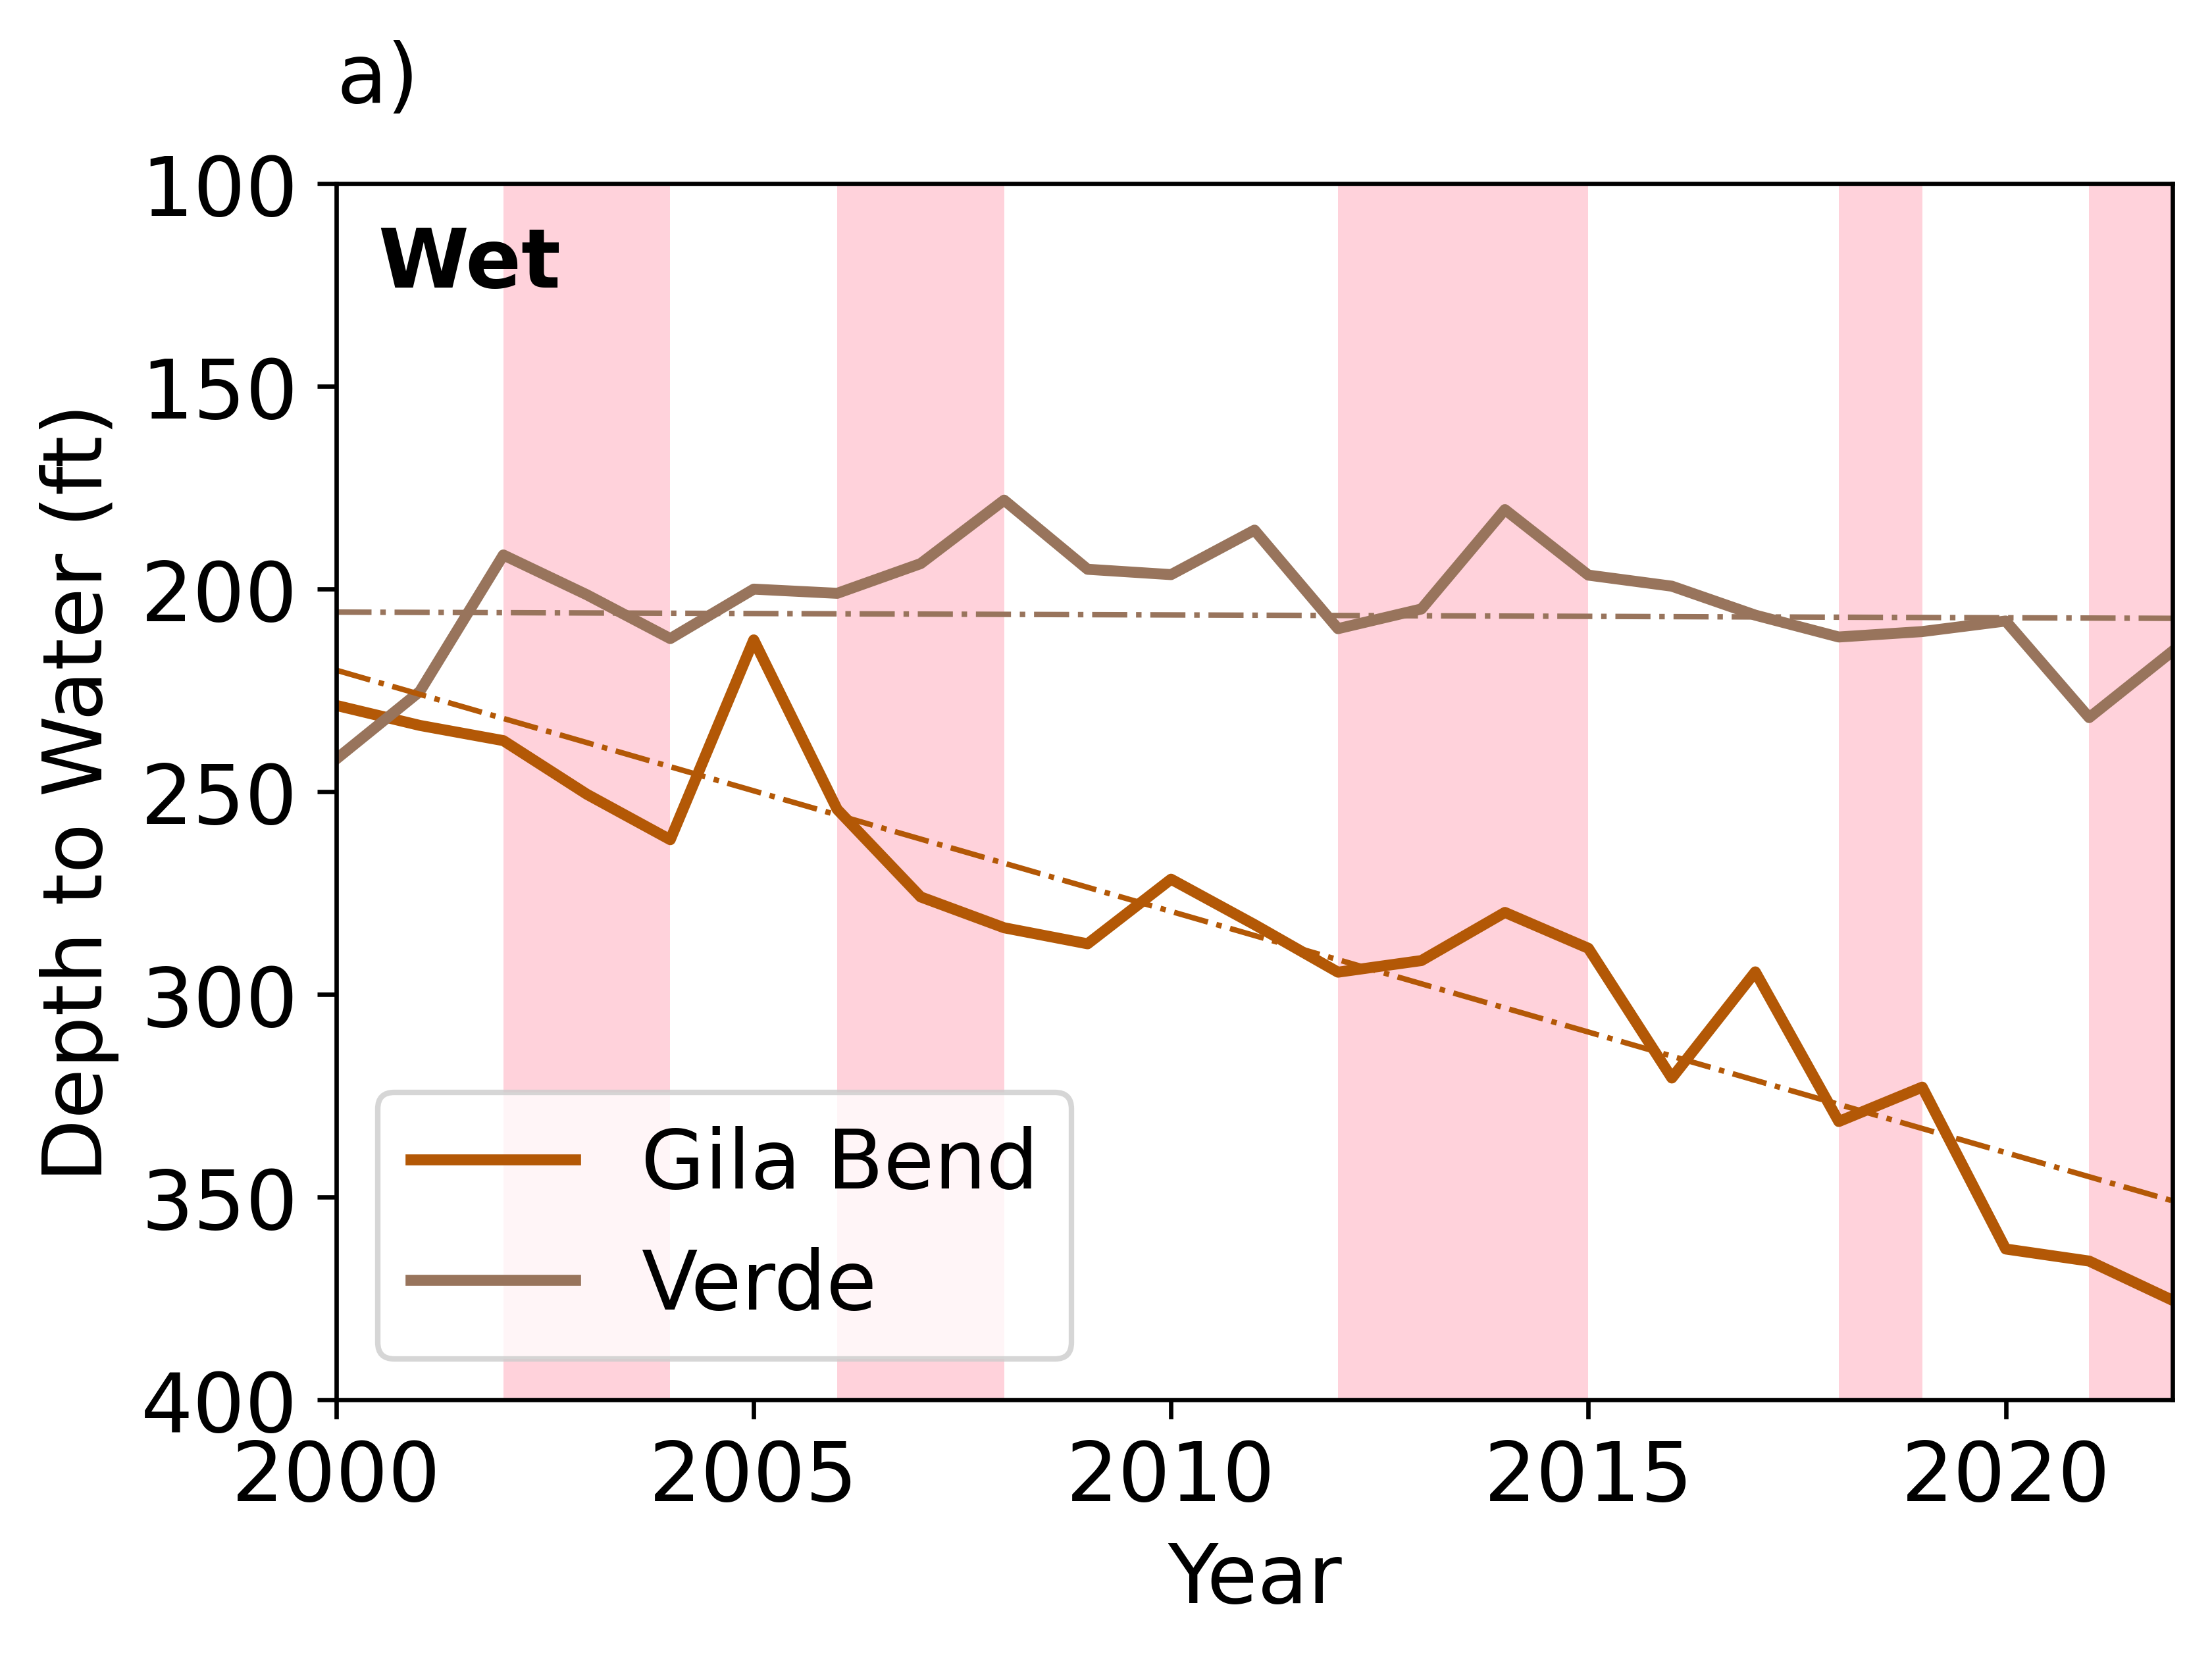

In [42]:
# For Depth to Water for all Case Studies
ds = test
# ds = secondary
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea
betterlabels = ds.columns.tolist()

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats = stats.sort_values(by='slope', ascending=False)
stats1 = stats.transpose()
print(stats)
# stats.to_csv(outputpath+'Stats_'+StudyArea+'.csv')

# -- Data visualization --

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = 100
max_y = 400
fsize = 15

# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Ensure that the labels are integers
ax.set_xticklabels(map(int, xticks))

# Severe Drought Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

# Plotting the data
for i,j in zip(stats1.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()

# Plotting Trendlines
for i,j in zip(stats1.columns,refined_cblind_colors):
        #xf1 = pd.to_datetime(xf1)
        m1 = round(stats1.loc['slope',i], 2)
        yint1 = round(stats1.loc['int',i], 2)
        pval1 = round(stats1.loc['p_val',i], 4)
        yf1 = (m1*xf)+yint1
        ax.plot(xf1, yf1,"-.",color=j, lw=1)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(max_y,min_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='y', labelsize=fsize)
ax.tick_params(axis='x', labelsize = fsize, rotation=0)
fig.set_dpi(600.0)
ax.set_title('a)',loc='left',pad=15, fontsize = fsize)
ax.legend(loc='lower left',fontsize = fsize)
# ax.legend(loc=[1.1,0.5])

# Adding text inside the plot
ax.text(min_yr+0.5, min_y+10, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
# ax.text(min_yr+0.5, max_y-10, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

plt.savefig(figurepath+'/Figure9a', bbox_inches = 'tight')

In [43]:
# Anomaly's
# Need to redo this line for some reason
# df = df_interpolated.drop(columns=columns_to_delete)
df = test
ds = df.copy()
column_list = df.columns.tolist()
trend_df = df.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        dataframe = ds[i]
        y=np.array(dataframe.values, dtype=float)
        x=np.array(pd.to_datetime(dataframe).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        trend_df[i] = (df.index*slope) + intercept
        dtw_anomalys[i] = df[i] - trend_df[i]

dtw_anomalys.head()

Verde  Gila Bend
index                  
2000   38.45       6.86
2001   21.72       5.83
2002  -12.00       3.63
2003   -2.26      10.90
2004    8.49      16.17

In [44]:
# Running this because it started flipping my colors
refined_cblind_colors.reverse()

Text(2000.5, 48, 'Dry')

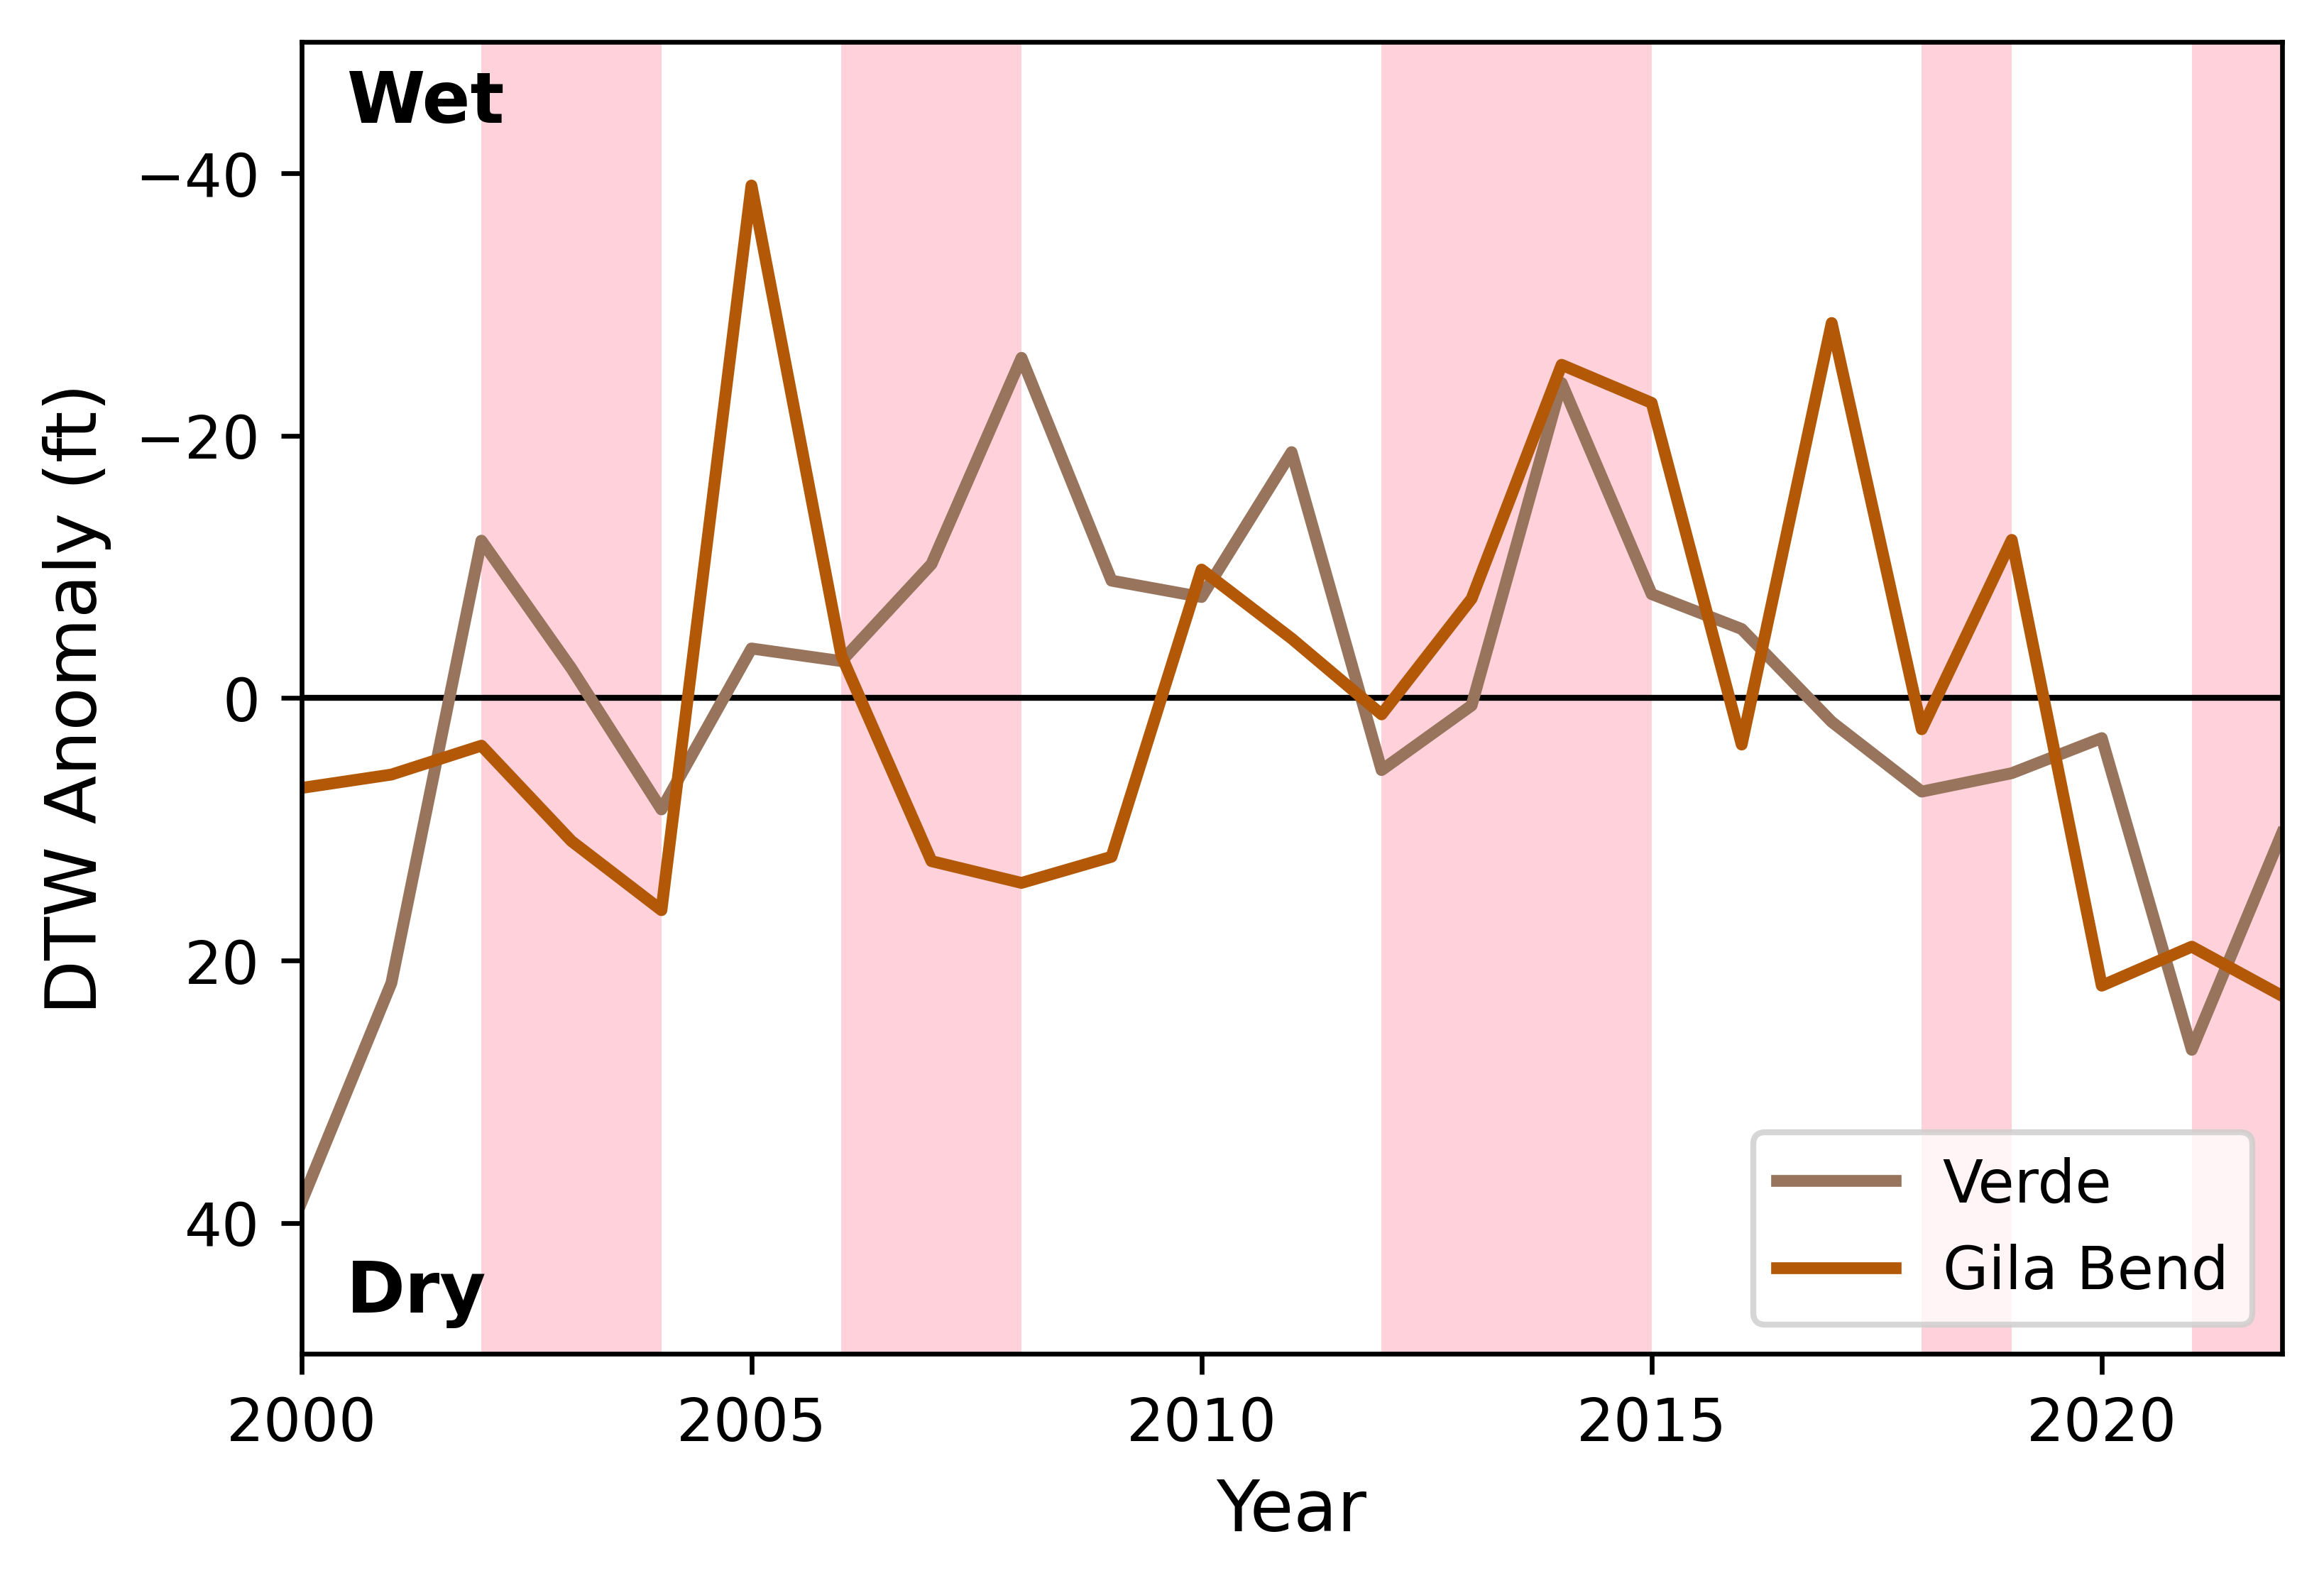

In [45]:
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ylim = 50
fsize = 12
# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

plt.axhspan(0,0,color='black',lw=1)

for i,j in zip(ds.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
# ax.plot(ds[column_list[0]], color=water_designation, lw=1.5)
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(ylim,-ylim)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=0)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='lower right')

# Adding text inside the plot
ax.text(min_yr+0.5, 2-ylim, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, ylim-2, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# plt.savefig(figurepath+'Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

Results for Gila Bend & Verde (2000-2022):
Kendall Correlation coefficient
 Verde:
  tau = 0.083
  pval = 0.6013
 Gila Bend:
  tau = -0.194
  pval = 0.2074
Spearman Correlation coefficient
 Verde:
  rho = 0.092
  pval = 0.6767
 Gila Bend:
  rho = -0.275
  pval = 0.2046
Pearson Correlation coefficient
 Verde:
  rsq = 0.001
  pval = 0.8695
 Gila Bend:
  rsq = 0.165
  pval = 0.0543



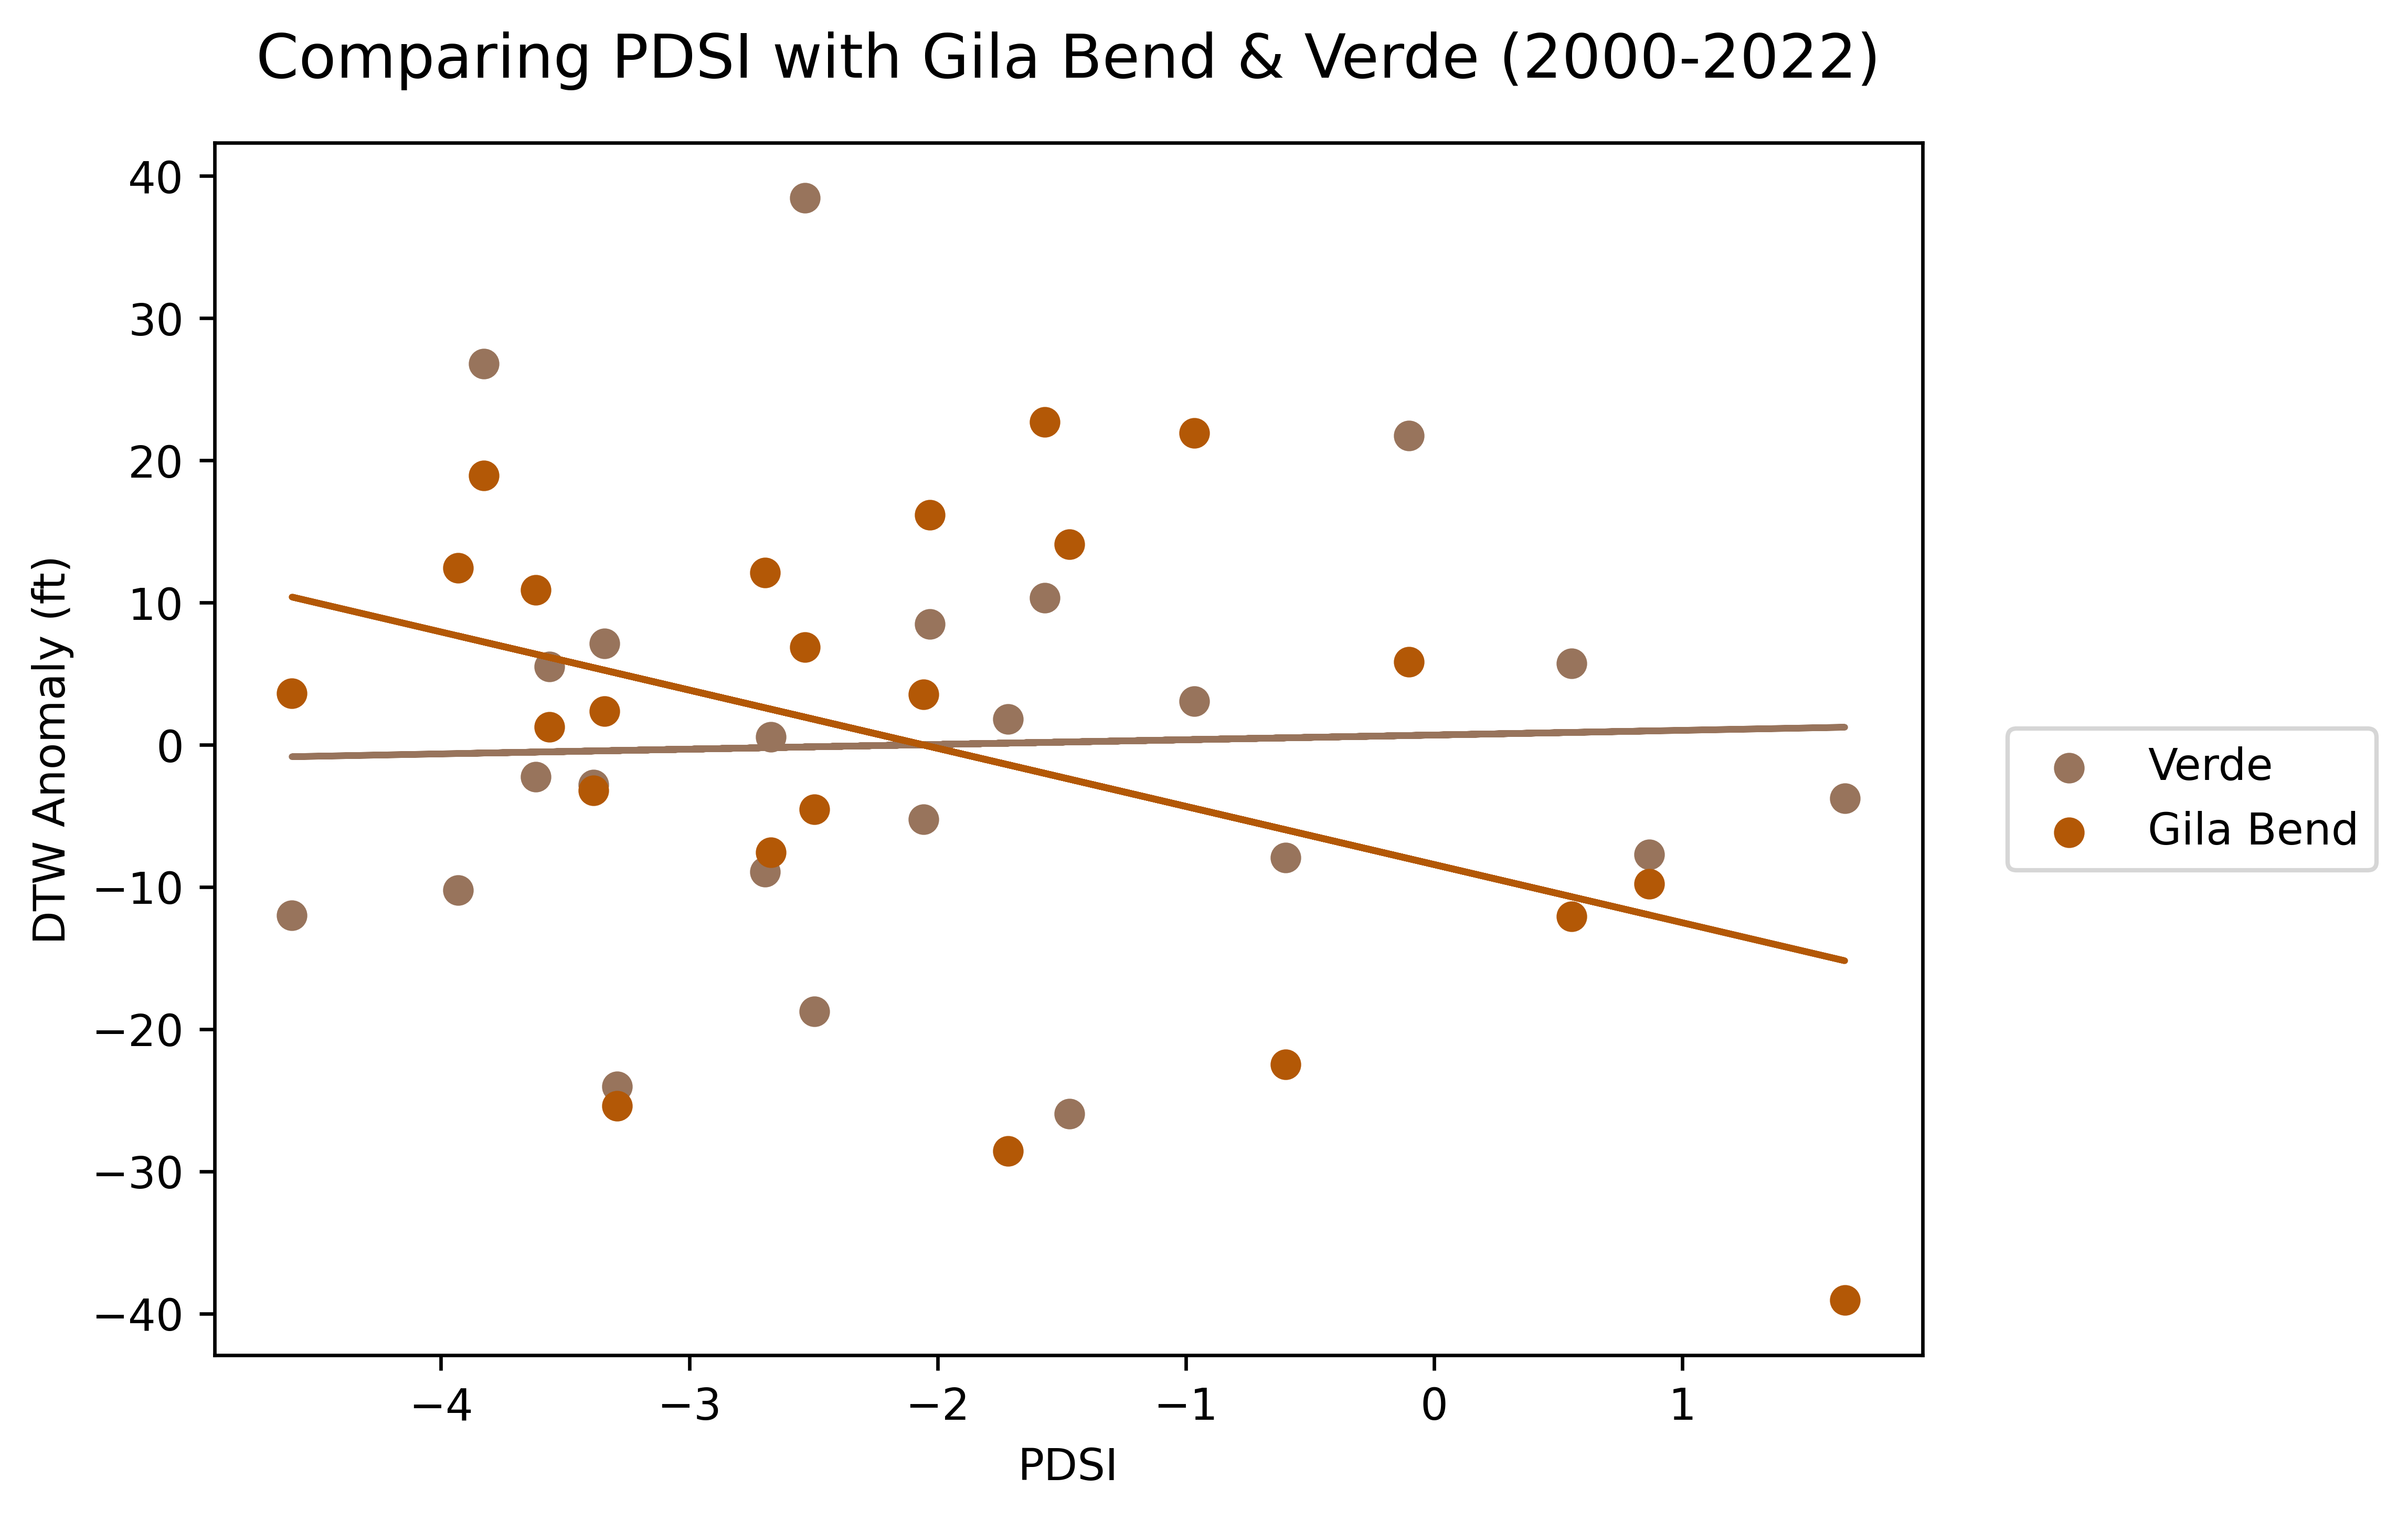

In [46]:
test_name = StudyArea+" ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
# ds = test
drought = drought_indices
lag = 0
indice = 'PDSI'

vert_axis = "DTW Anomaly (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,refined_cblind_colors,betterlabels,vert_axis)
print(result)

Results for Gila Bend & Verde (2000-2022):
Kendall Correlation coefficient
 Verde:
  tau = -0.051
  pval = 0.754
 Gila Bend:
  tau = -0.265
  pval = 0.0812
Spearman Correlation coefficient
 Verde:
  rho = -0.089
  pval = 0.6866
 Gila Bend:
  rho = -0.354
  pval = 0.0977
Pearson Correlation coefficient
 Verde:
  rsq = 0.011
  pval = 0.6388
 Gila Bend:
  rsq = 0.274
  pval = 0.0103



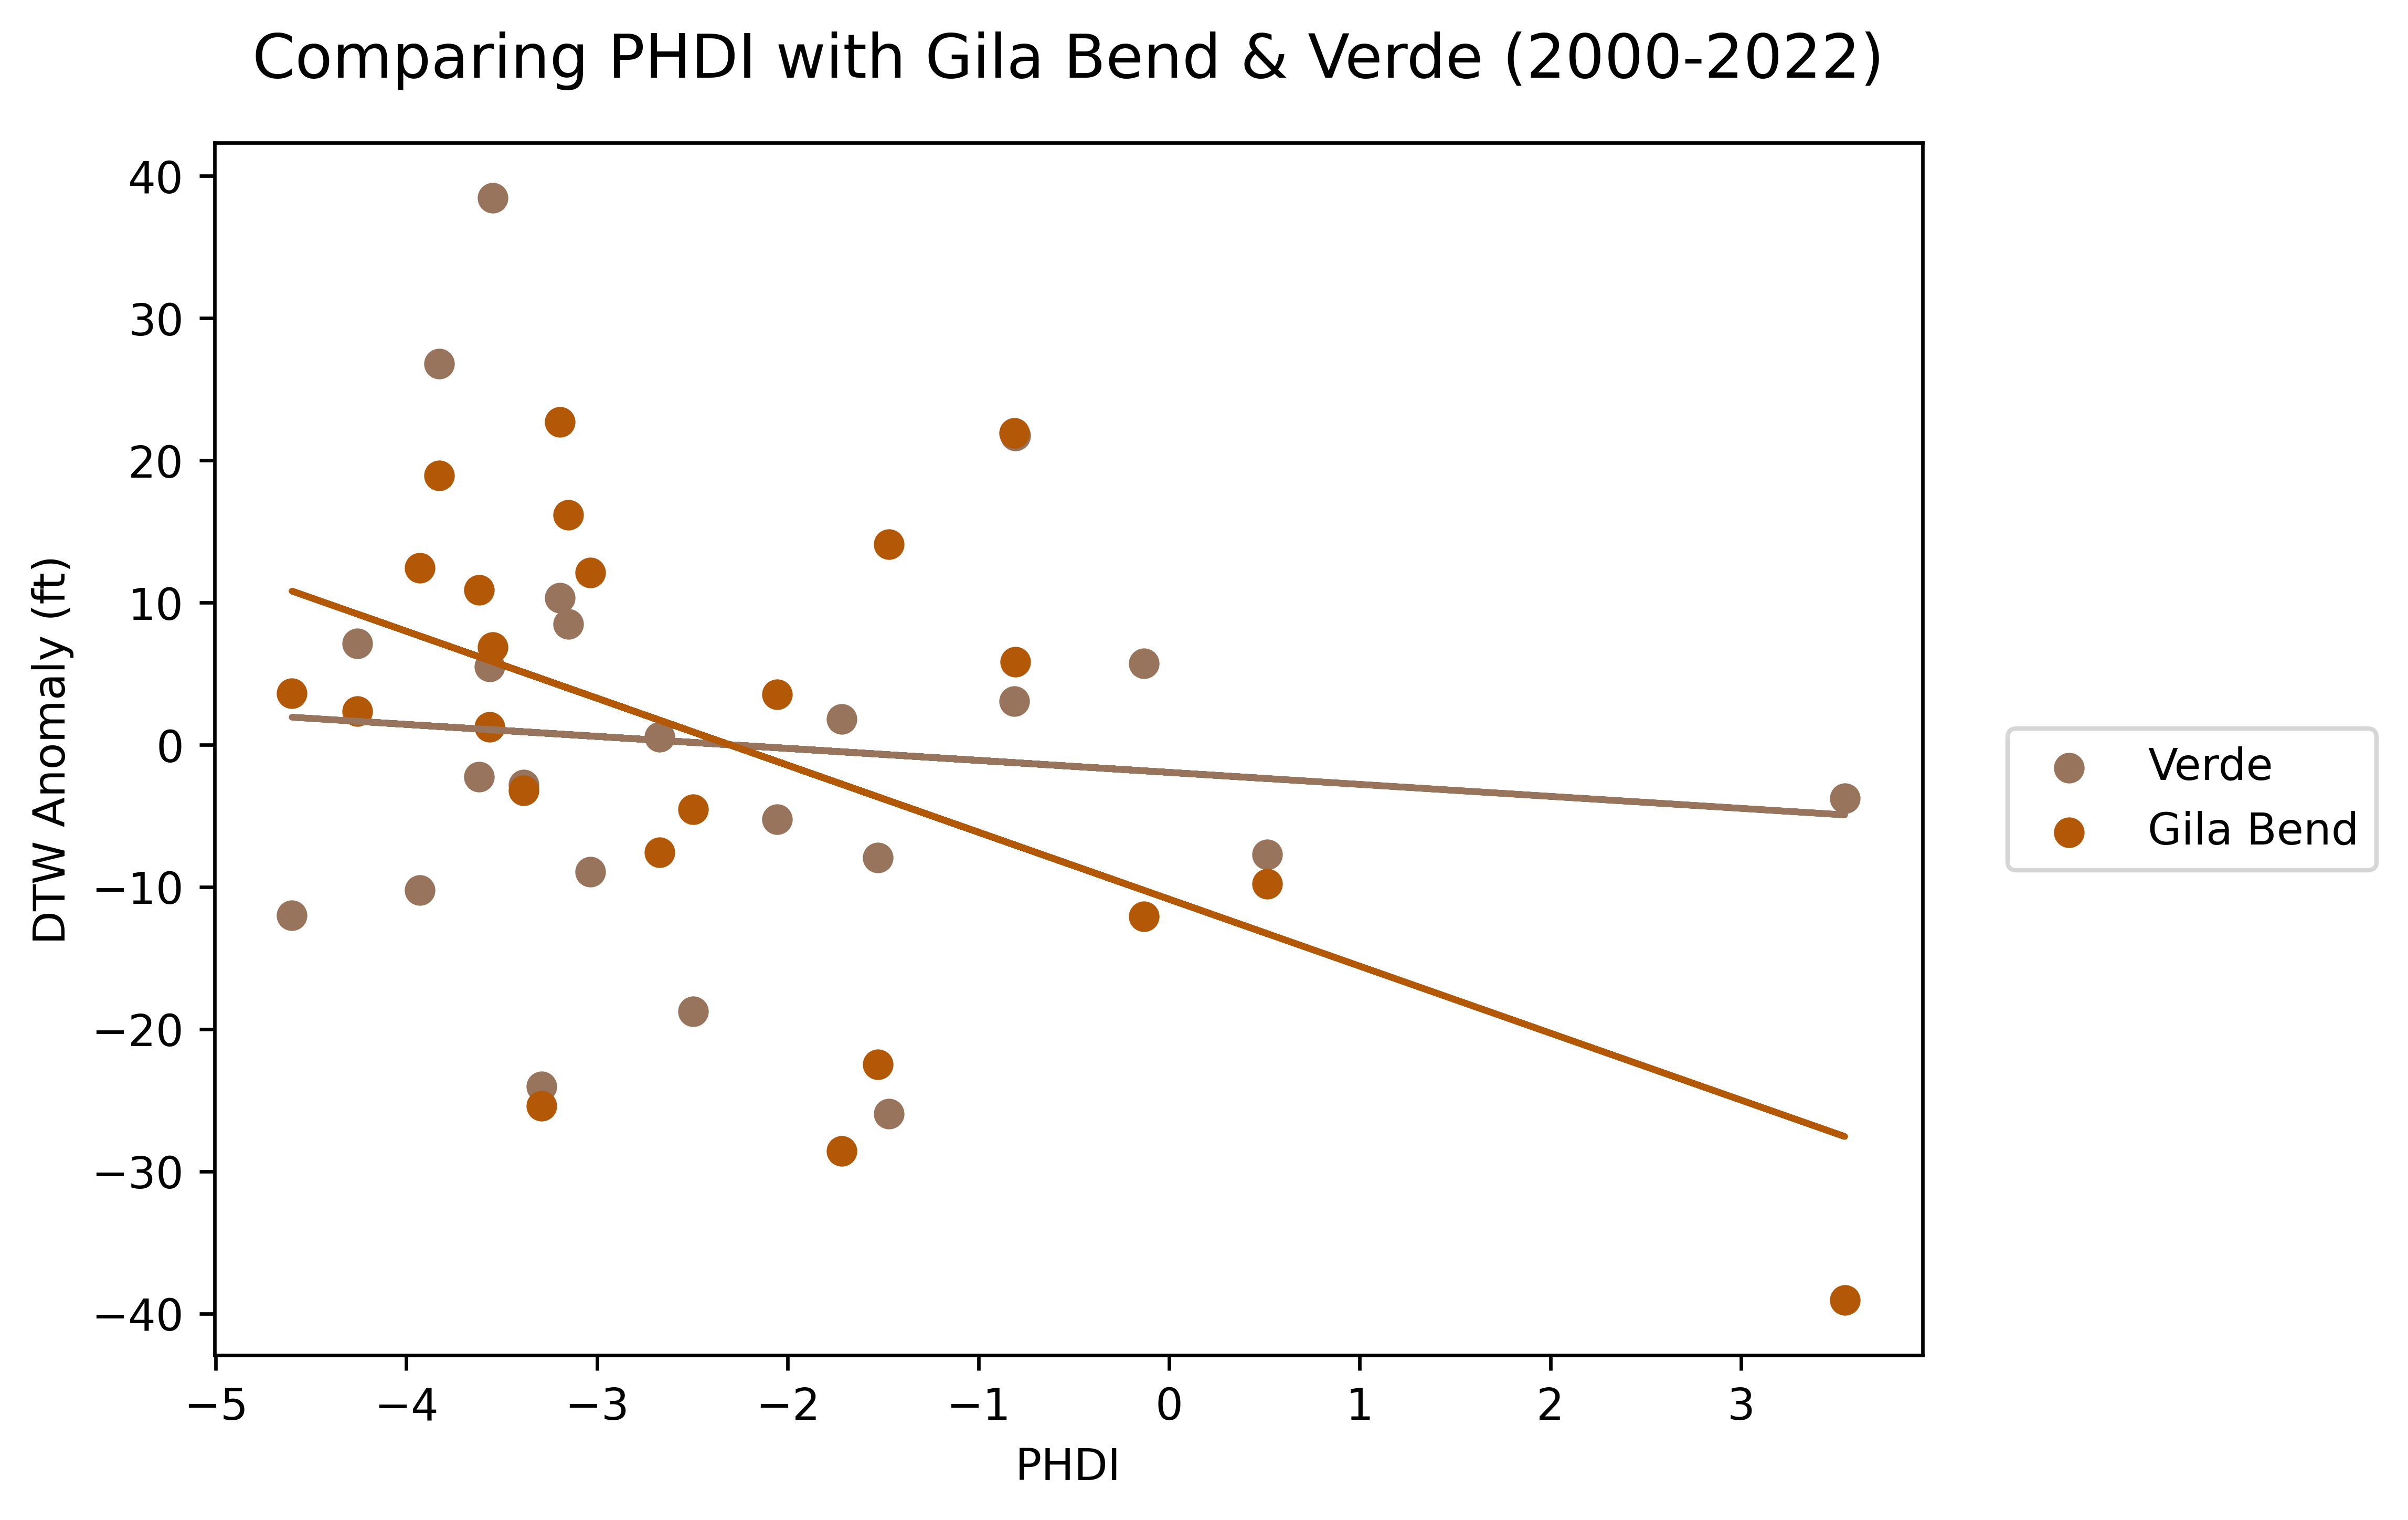

In [47]:
test_name = StudyArea+" ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices
lag = 0
indice = 'PHDI'

vert_axis = "DTW Anomaly (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,refined_cblind_colors,betterlabels,vert_axis)
print(result)

Calculating Max Drawdown (maximum anomaly in the drought period)

In [48]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

Verde  Gila Bend
Status                      
Drought 3   -2.26      10.90
Drought 4   -2.81      12.43
Drought 5    5.49       1.24
Drought 6    7.13       2.38
Drought 7   26.81      18.95
Normal-Wet  38.45      22.69

In [49]:
# Reorder the dataframe

test = pd.DataFrame()
test['Gila Bend'] = dtw_max_anomalies['Gila Bend']
test['Verde'] = dtw_max_anomalies['Verde']
test

Gila Bend  Verde
Status                      
Drought 3       10.90  -2.26
Drought 4       12.43  -2.81
Drought 5        1.24   5.49
Drought 6        2.38   7.13
Drought 7       18.95  26.81
Normal-Wet      22.69  38.45

In [50]:
# Running this because it started flipping my colors
refined_cblind_colors.reverse()

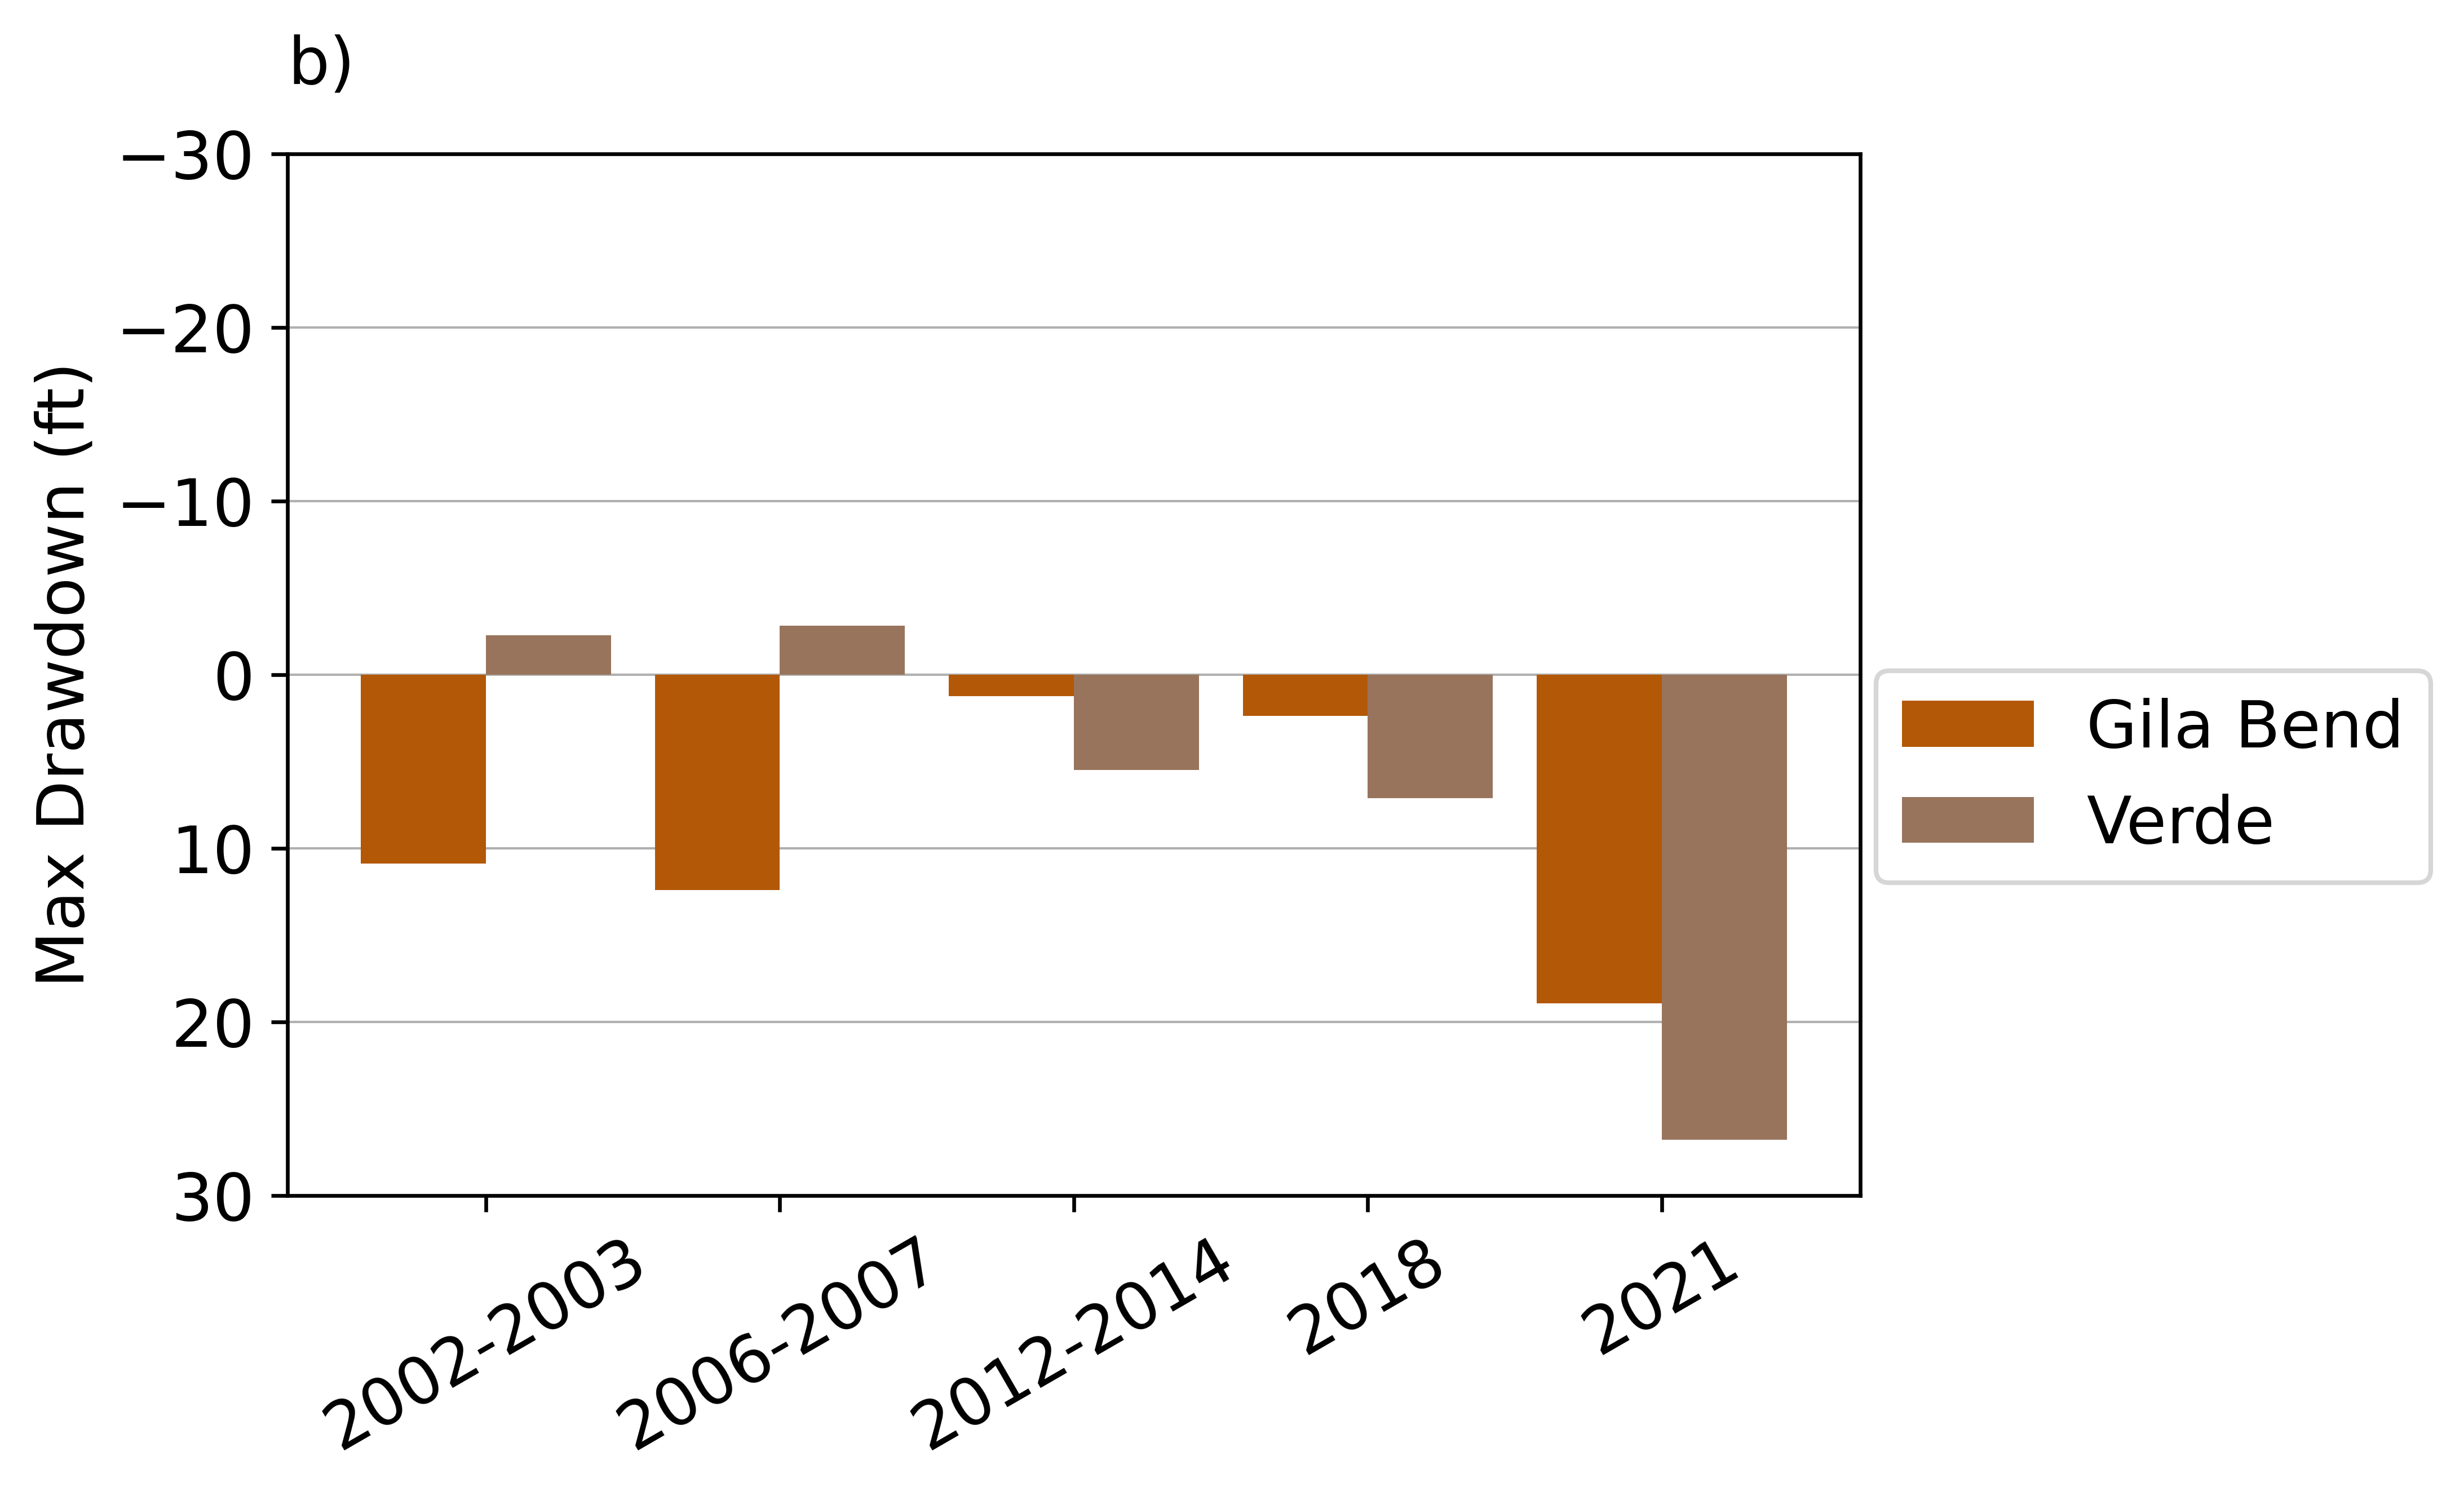

In [51]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Max Drawdown by Drought Period for '+StudyArea

ds = test

ylim = 30

yearlabels = [
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]

betterlabels = ds.columns.tolist()

ds.index = yearlabels
ds = ds.transpose()

ds.index = betterlabels
del ds['Normal/Wet Years']
ds = ds.transpose()

group_colors = refined_cblind_colors

vertlabel = 'Max Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
ds.plot(figsize = (6,4),
        kind='bar',
        stacked=False,
        # title=name,
        # color = group_colors,
        color = refined_cblind_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title('b)', fontsize = fsize, pad = 15, loc='left')
plt.ylim([ylim,-ylim])
plt.ylabel(vertlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+'/Figure9b', bbox_inches = 'tight')

In [52]:
# New wells

static_geo2['INSTALLED'] = pd.to_datetime(static_geo2['INSTALLED'])
# static_geo2['INSTALLED'].describe()

static_geo2['In_year'] = static_geo2['INSTALLED'].dt.year
# new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col+"_right"], values=["INSTALLED"], dropna=False, aggfunc=len)
new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = new_wells.reset_index()

new_wells.to_csv(outputpath+'/Final_NewWells_'+StudyArea+'.csv')

In [53]:
# To get it formatted correctly
all_columns = wlanalysis_period.columns.tolist()
new_wells2 = pd.read_csv(outputpath+'/Final_NewWells_'+StudyArea+'.csv',
                        header=2,
                        # names = ['R','Res','U']
                        names = all_columns
                        # names = [StudyArea]
                        , index_col=0
                        )
new_wells2

Control  Douglas  Flagstaff  GSF/USF  GilaBend  Harquahala  \
1900.00      NaN     1.00       1.00      NaN       NaN         NaN   
1910.00      NaN      NaN        NaN      NaN       NaN         NaN   
1915.00      NaN      NaN        NaN      NaN       NaN         NaN   
1916.00      NaN      NaN        NaN      NaN       NaN         NaN   
1917.00      NaN      NaN        NaN      NaN       NaN         NaN   
...          ...      ...        ...      ...       ...         ...   
2020.00      NaN    19.00      11.00     5.00      2.00        4.00   
2021.00     3.00    27.00      11.00     1.00      3.00        1.00   
2022.00     1.00    24.00      13.00     3.00      1.00        2.00   
2023.00     1.00    15.00       9.00     1.00      4.00         NaN   
2024.00      NaN      NaN       4.00      NaN      3.00        1.00   

         LittleCoR  McMullen  Phoenix  RanegrasPlain  SaltRiver  Tucson  USF  \
1900.00        NaN       NaN     1.00            NaN        NaN     NaN  NaN   
1910.00       1.00       NaN      NaN            NaN        NaN     NaN  NaN   
1915.00        NaN       NaN      NaN            NaN        NaN    2.00  NaN   
1916.00       1.00       NaN      NaN            NaN        NaN     NaN  NaN   
1917.00       1.00       NaN      NaN            NaN        NaN     NaN  NaN   
...            ...       ...      ...            ...        ...     ...  ...   
2020.00      93.00     10.00    62.00           7.00      10.00   28.00  NaN   
2021.00      77.00     11.00    49.00           6.00      29.00   17.00 2.00   
2022.00      69.00      8.00    53.00           8.00       6.00   23.00  NaN   
2023.00      50.00      7.00    39.00           3.00       5.00   12.00 4.00   
2024.00       4.00      2.00     6.00           1.00        NaN    6.00  NaN   

         Verde  Wilcox  Yuma  
1900.00    NaN    1.00   NaN  
1910.00    NaN     NaN   NaN  
1915.00    NaN     NaN   NaN  
1916.00    NaN     NaN   NaN  
1917.00    NaN     NaN   NaN  
...        ...     ...   ...  
2020.00  42.00   73.00 43.00  
2021.00  38.00   66.00 71.00  
2022.00  28.00   72.00 40.00  
2023.00   3.00   23.00 30.00  
2024.00   4.00    6.00   NaN  

[107 rows x 16 columns]

In [54]:
new_wells2 = new_wells2.drop(columns=columns_to_delete)
new_wells2.to_csv(outputpath+'/Final_NewWells_'+StudyArea+'.csv')
new_wells2

GilaBend  Verde
1900.00       NaN    NaN
1910.00       NaN    NaN
1915.00       NaN    NaN
1916.00       NaN    NaN
1917.00       NaN    NaN
...           ...    ...
2020.00      2.00  42.00
2021.00      3.00  38.00
2022.00      1.00  28.00
2023.00      4.00   3.00
2024.00      3.00   4.00

[107 rows x 2 columns]

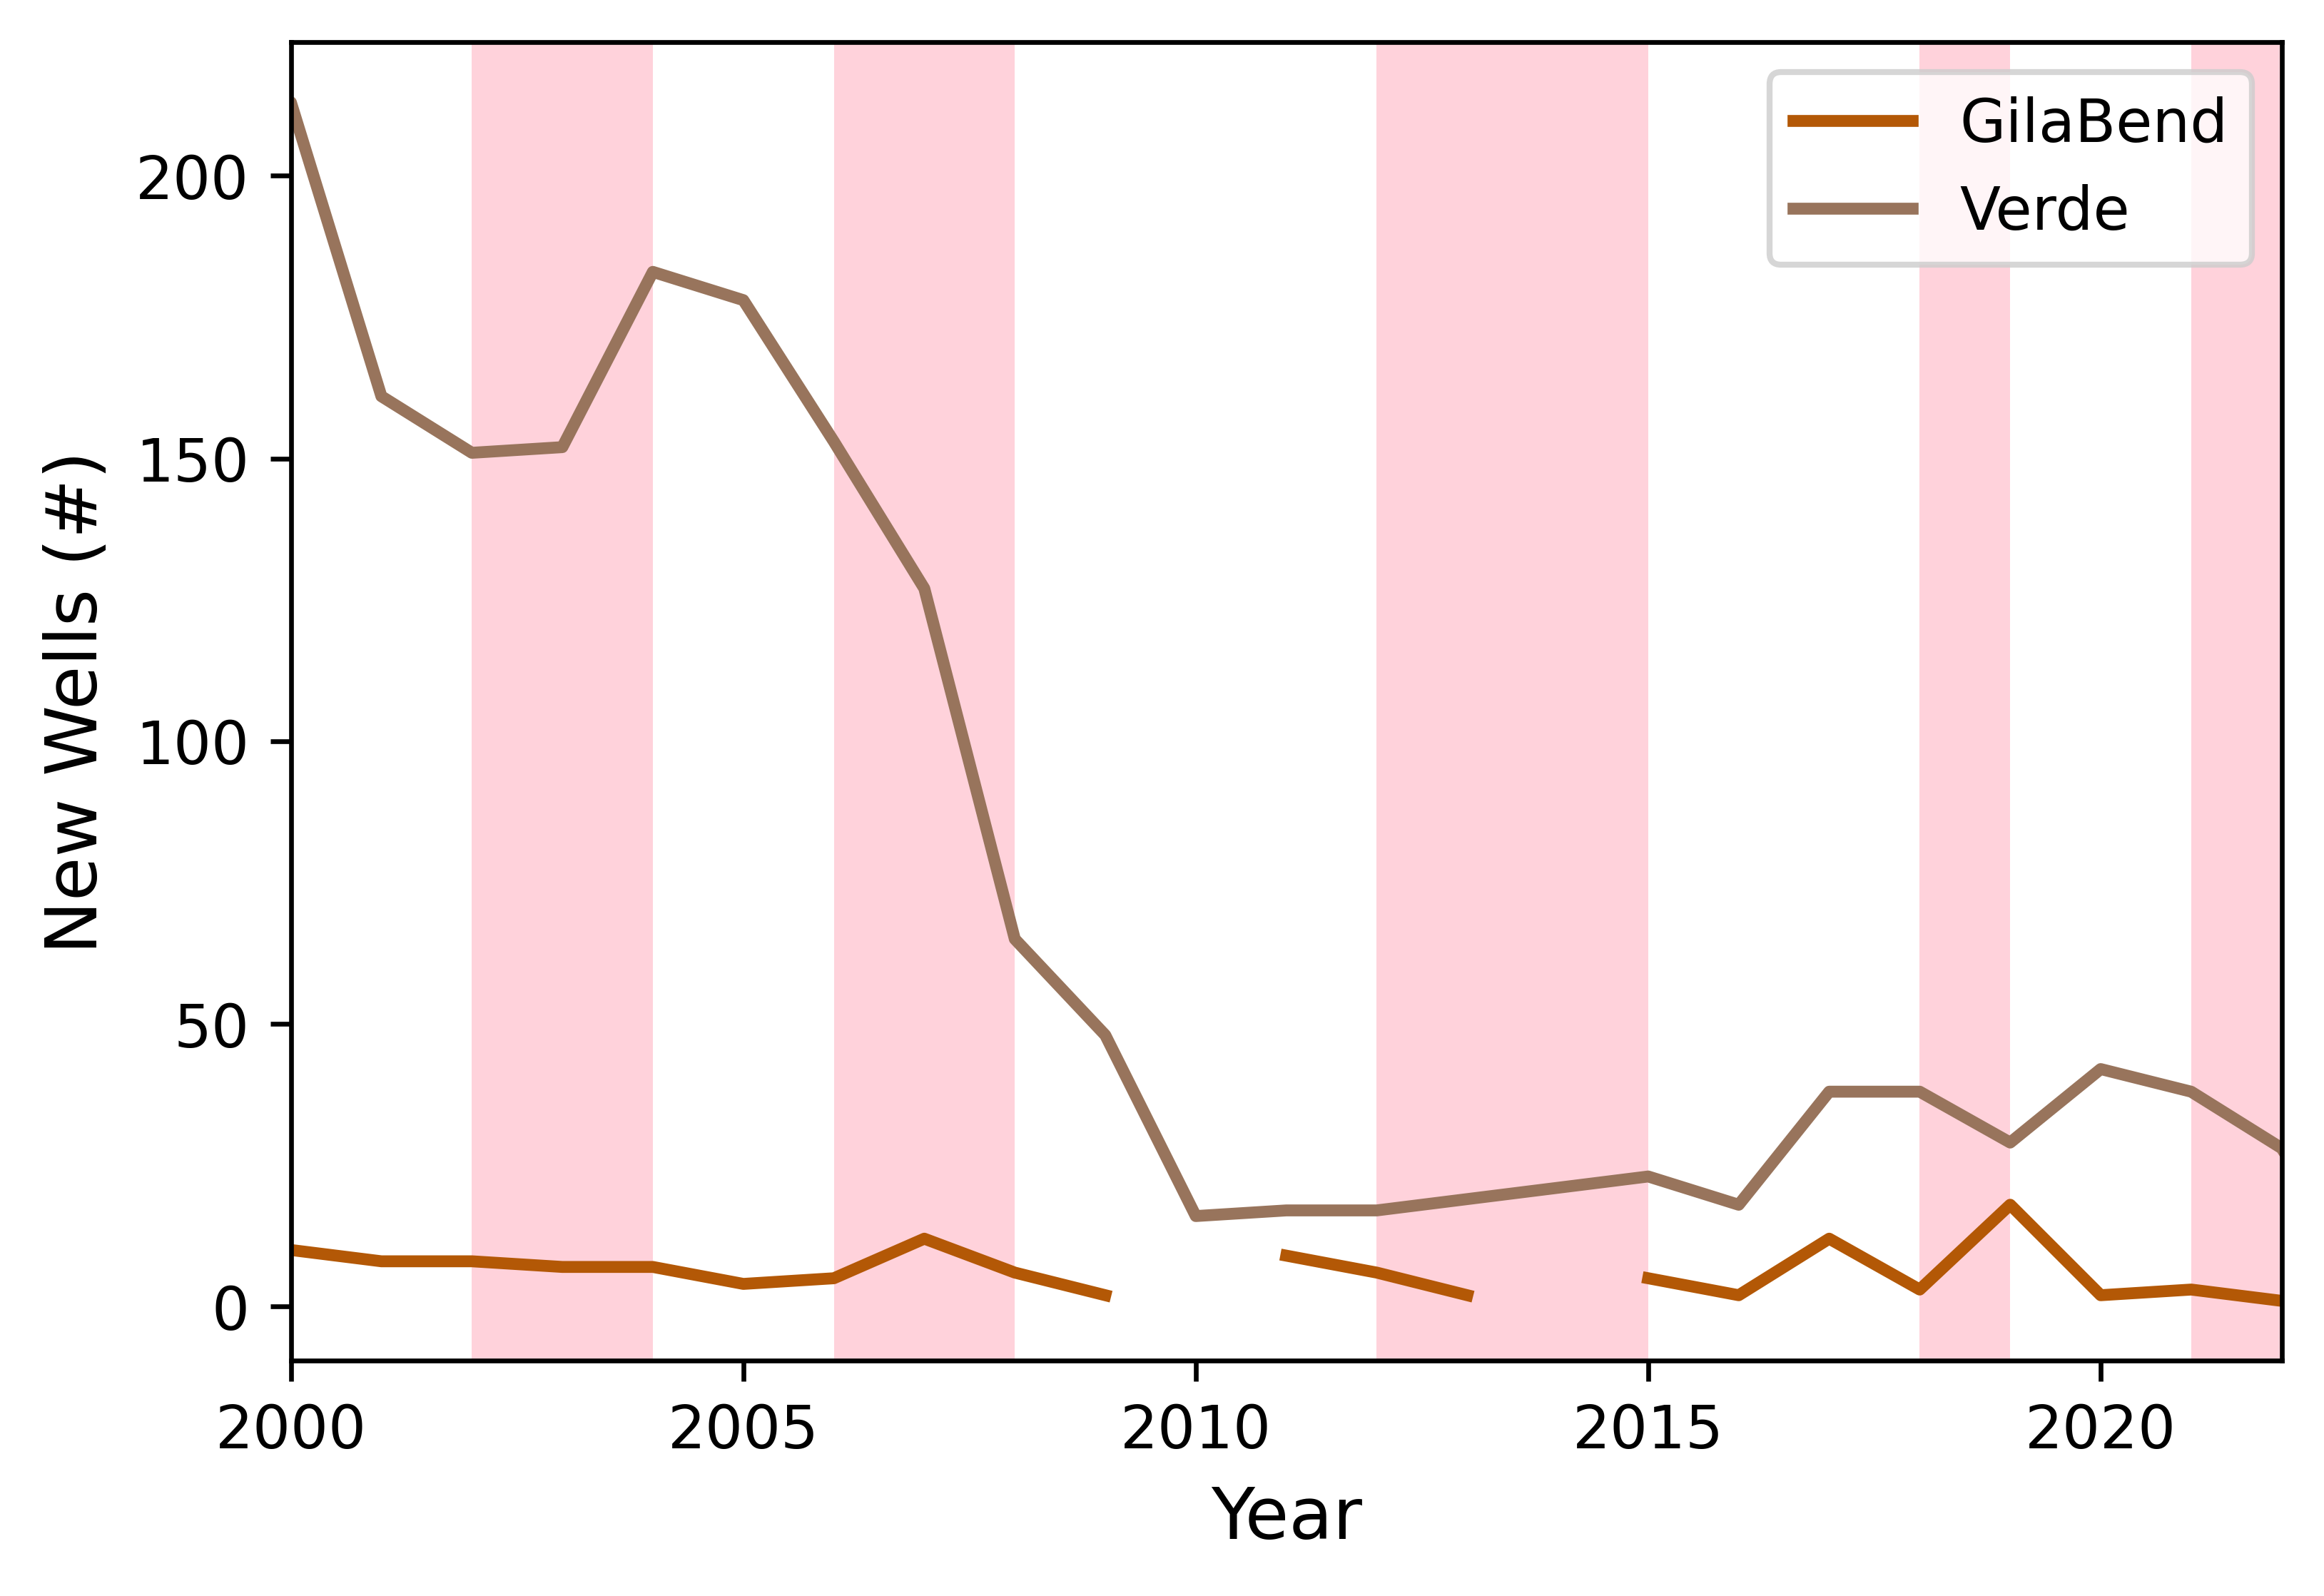

In [55]:
ds = new_wells2
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = -12
max_y = 15
fsize = 12
# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

for i,j in zip(ds.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel('New Wells (#)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# plt.savefig(figurepath+'Timeseries of New Wells for '+StudyArea, bbox_inches = 'tight')

Now for Quick McMullen

In [69]:
StudyArea = 'McMullen'

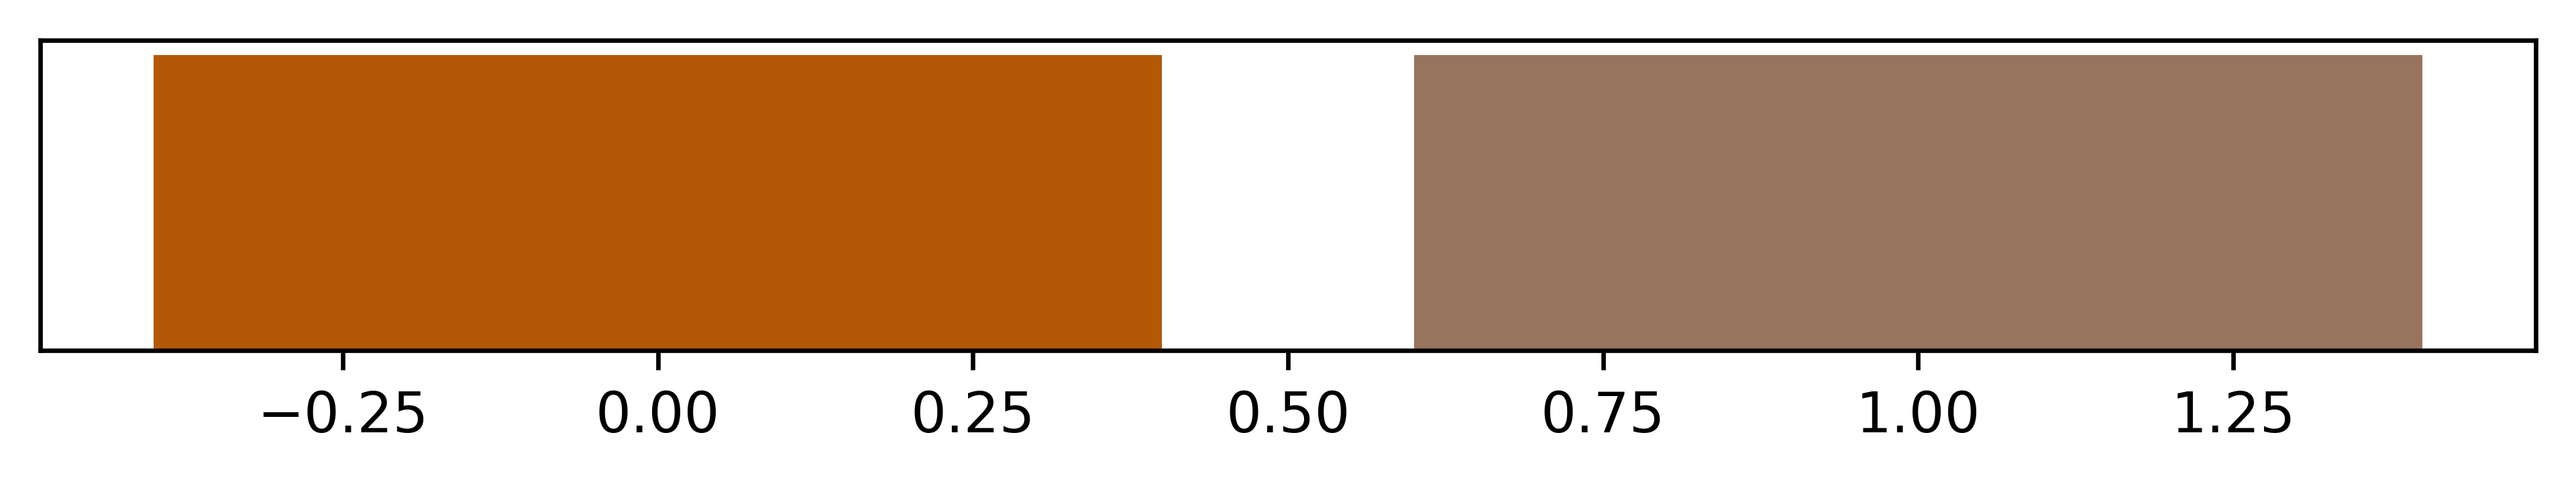

In [70]:
# This is to delete some columns as needed
columns_to_delete = ['Control','GSF/USF','USF'
                     ,'Harquahala'
                     ,'SaltRiver'
                     ,'Douglas'
                     ,'Verde','GilaBend'
                     ,'Tucson','Phoenix'
                    #  ,'McMullen'
                     ,'RanegrasPlain'
                     ,'Flagstaff'
                     ,'LittleCoR'
                     ,'Yuma'
                    ,'Wilcox'
                    ]
df = df_interpolated.drop(columns=columns_to_delete)

# Colors for Gilabend and Verde
refined_cblind_colors = ['#b35806', '#98745c']

# Create a bar plot to visualize colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(refined_cblind_colors)), height=1, color=refined_cblind_colors)

# Remove y-axis
ax.set_yticks([])

# Show the plot
plt.show()

In [71]:
# Reorder the dataframe

test = pd.DataFrame()
test['McMullen'] = df['McMullen']
# test['Gila Bend'] = df['GilaBend']
test

McMullen
index          
2000     379.45
2001     399.00
2002     373.91
2003     398.44
2004     415.38
2005     395.91
2006     399.45
2007     392.10
2008     415.61
2009     404.26
2010     394.69
2011     406.61
2012     404.48
2013     408.50
2014     401.51
2015     402.30
2016     389.30
2017     411.79
2018     413.81
2019     402.27
2020     416.44
2021     419.92
2022     410.93

          slope      int  rsq  p_val  std_err   mean    var     sum
McMullen   1.01 -1622.54 0.35   0.00     0.30 402.44 128.47 9256.05


Text(2000.5, 110, 'Wet')

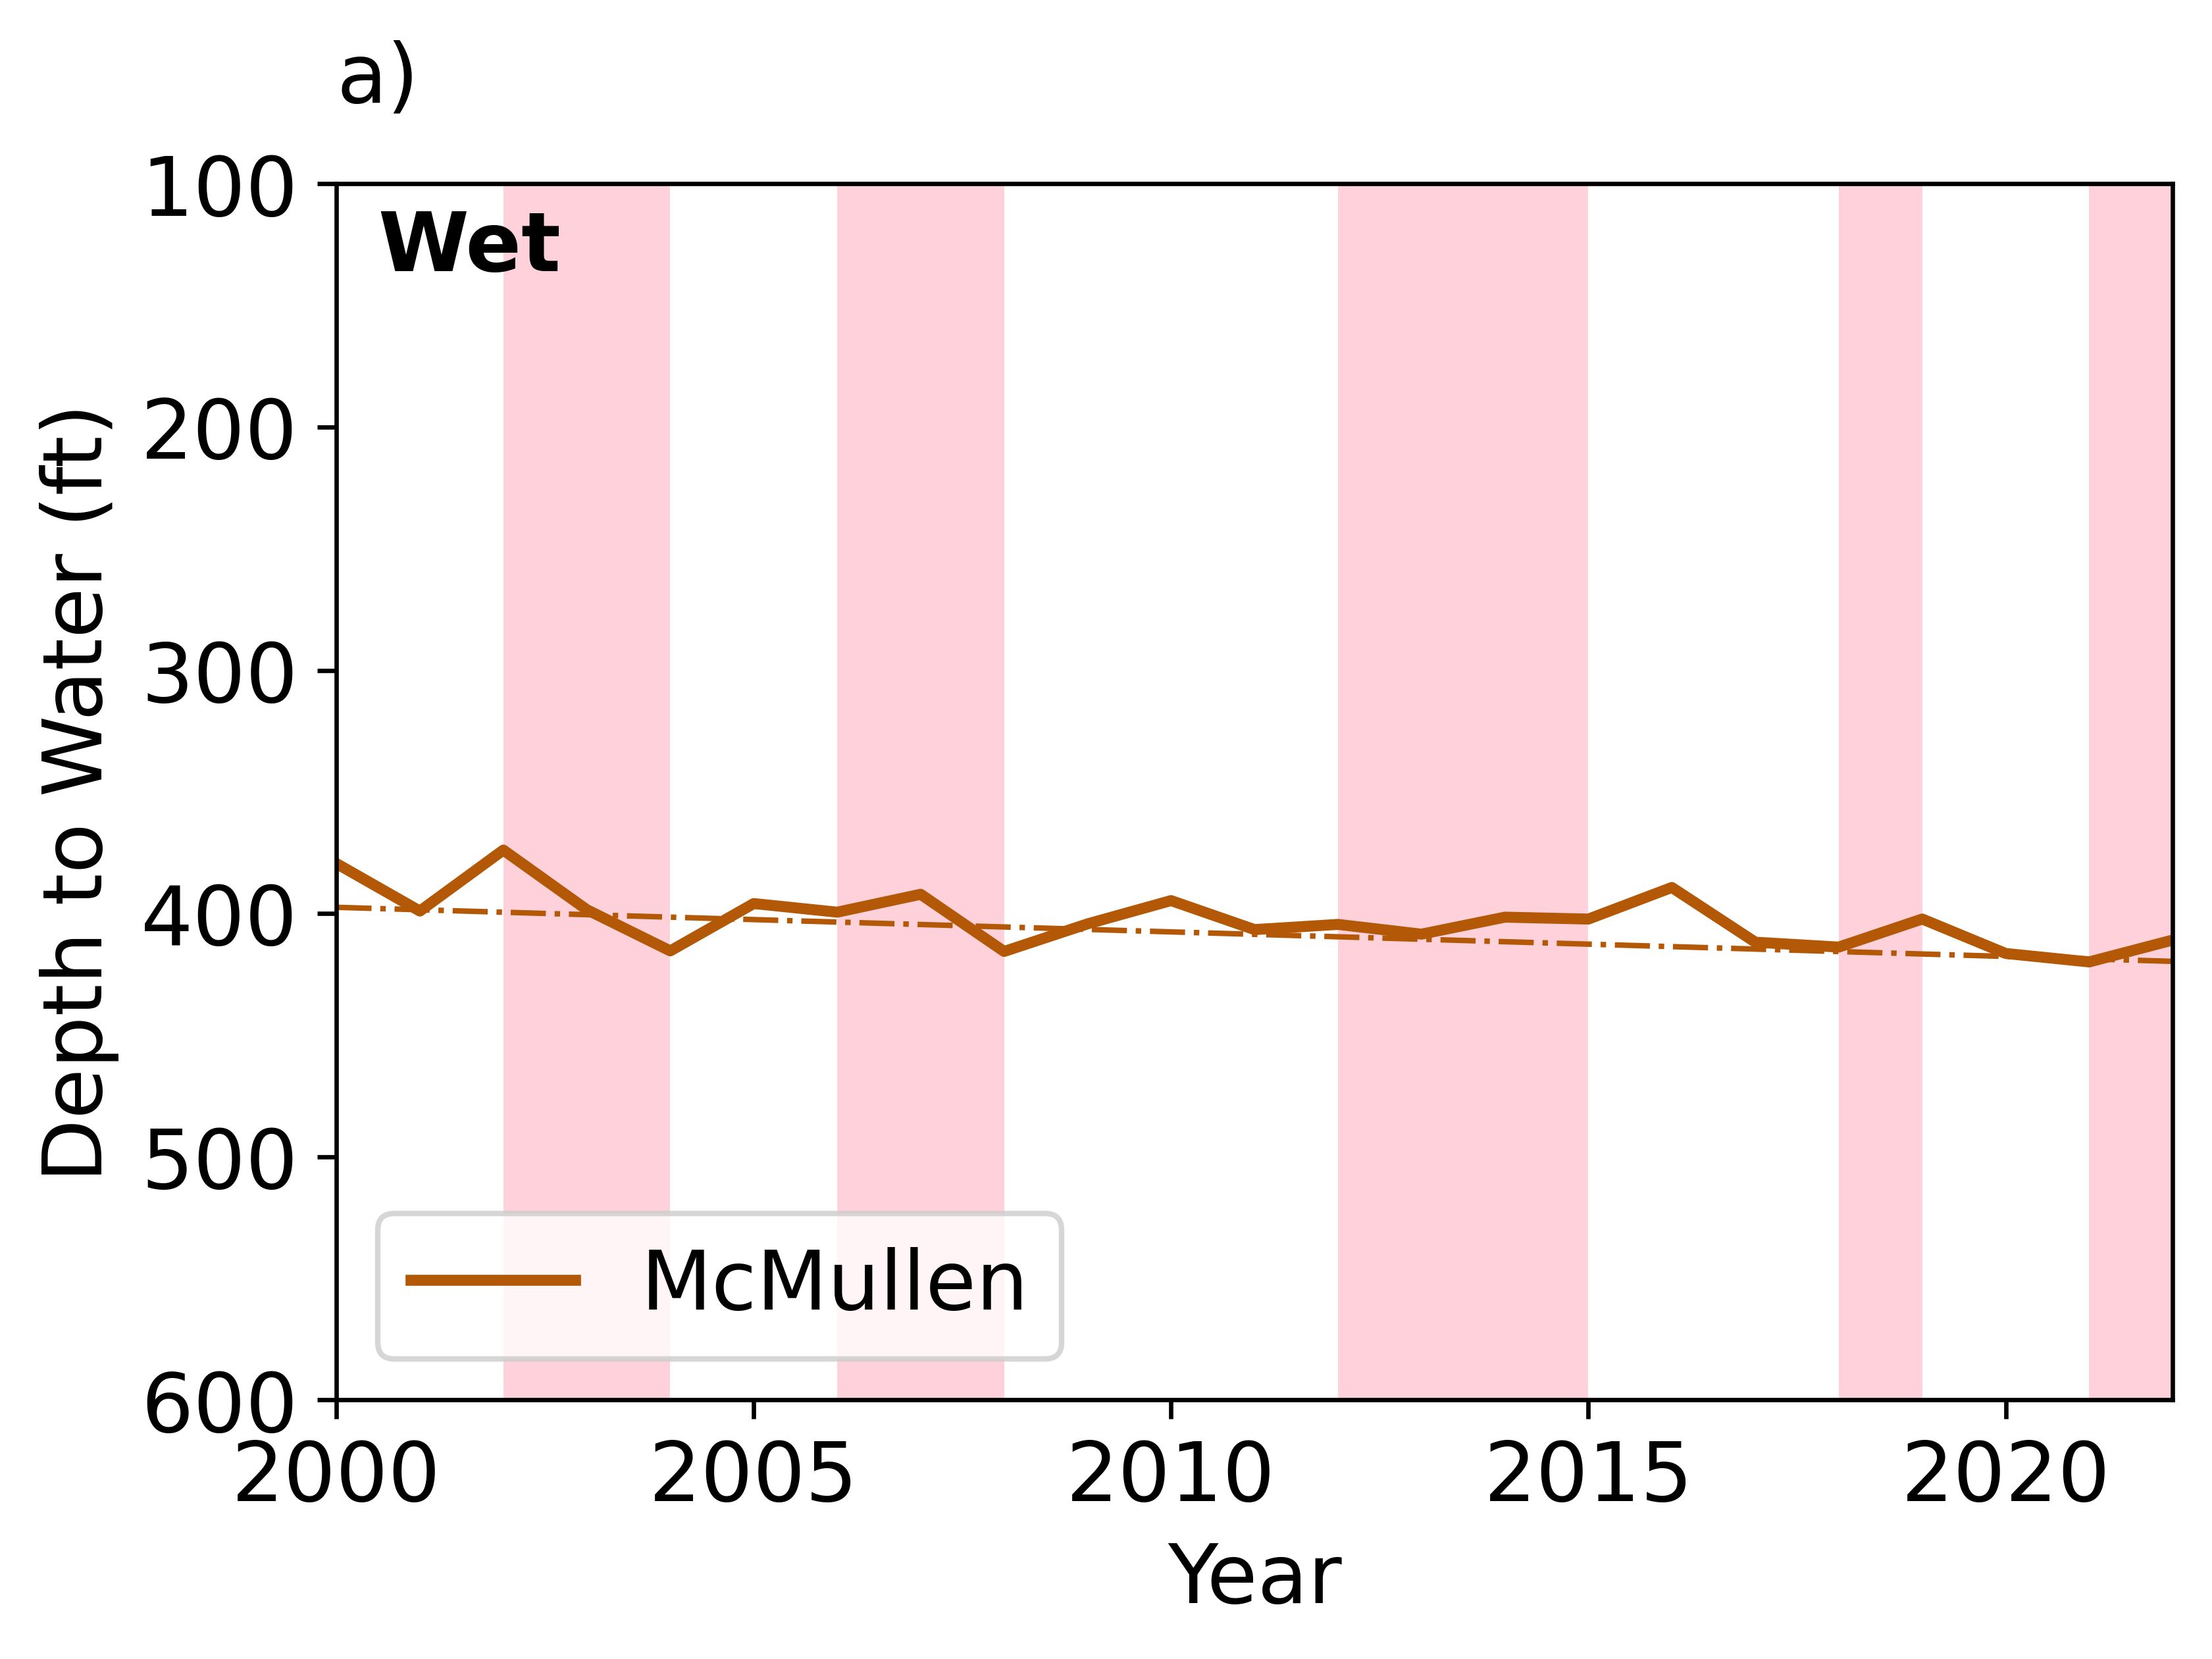

In [73]:
# For Depth to Water for all Case Studies
ds = test
# ds = secondary
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea
betterlabels = ds.columns.tolist()

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats = stats.sort_values(by='slope', ascending=False)
stats1 = stats.transpose()
print(stats)
# stats.to_csv(outputpath+'Stats_'+StudyArea+'.csv')

# -- Data visualization --

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = 100
max_y = 600
fsize = 15

# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Ensure that the labels are integers
ax.set_xticklabels(map(int, xticks))

# Severe Drought Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

# Plotting the data
for i,j in zip(stats1.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()

# Plotting Trendlines
for i,j in zip(stats1.columns,refined_cblind_colors):
        #xf1 = pd.to_datetime(xf1)
        m1 = round(stats1.loc['slope',i], 2)
        yint1 = round(stats1.loc['int',i], 2)
        pval1 = round(stats1.loc['p_val',i], 4)
        yf1 = (m1*xf)+yint1
        ax.plot(xf1, yf1,"-.",color=j, lw=1)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(max_y,min_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='y', labelsize=fsize)
ax.tick_params(axis='x', labelsize = fsize, rotation=0)
fig.set_dpi(600.0)
ax.set_title('a)',loc='left',pad=15, fontsize = fsize)
ax.legend(loc='lower left',fontsize = fsize)
# ax.legend(loc=[1.1,0.5])

# Adding text inside the plot
ax.text(min_yr+0.5, min_y+10, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
# ax.text(min_yr+0.5, max_y-10, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# plt.savefig(figurepath+'/Figure9a', bbox_inches = 'tight')

Analysis for Yuma

In [56]:
StudyArea = 'Yuma'

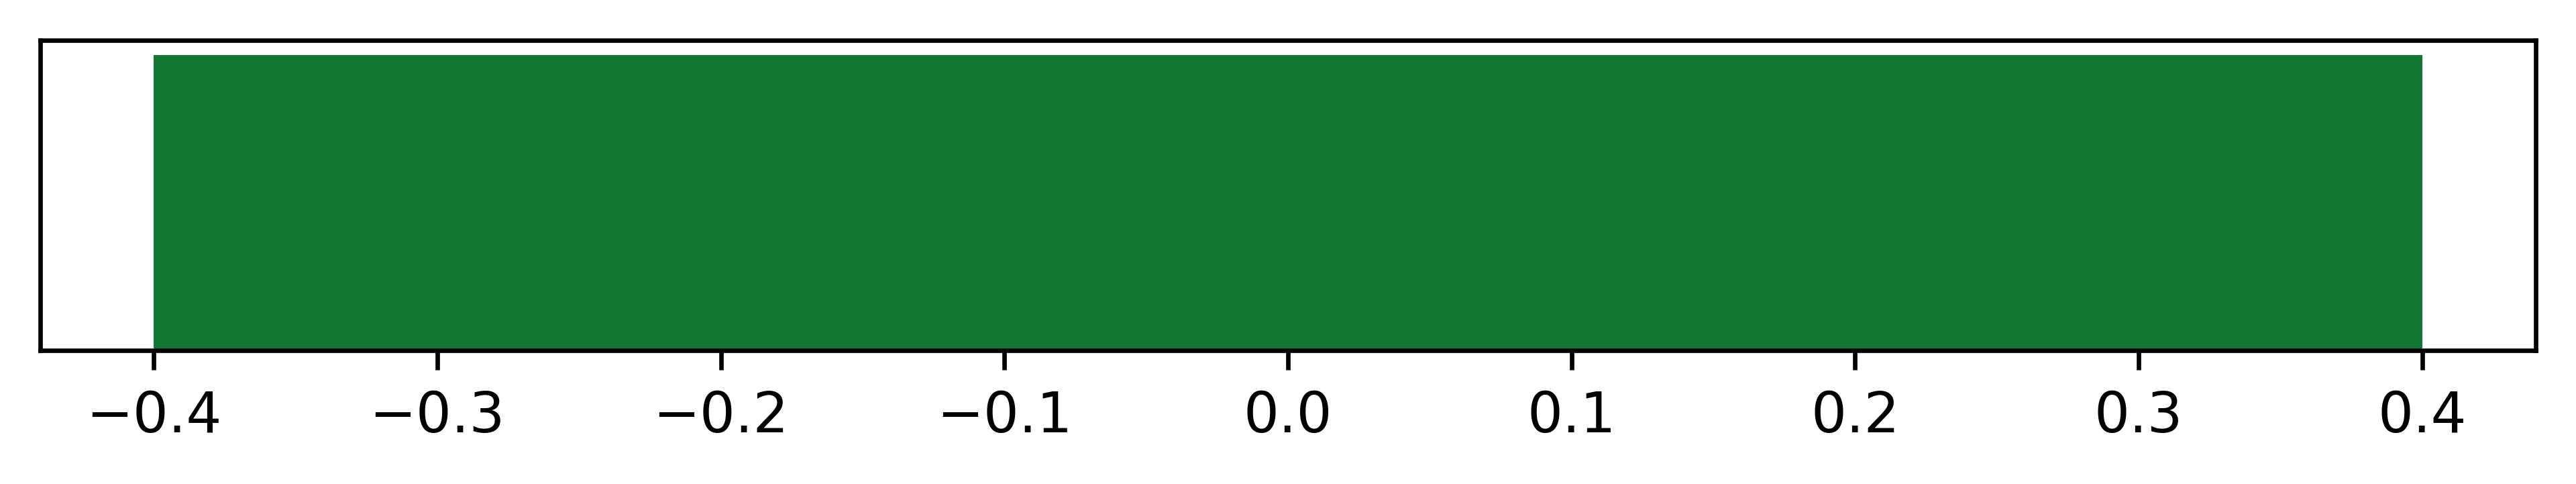

In [57]:
# This is to delete some columns as needed
columns_to_delete = ['Control','GSF/USF','USF'
                     ,'Harquahala'
                     ,'SaltRiver'
                     ,'Douglas'
                     ,'Verde','GilaBend'
                     ,'Tucson','Phoenix'
                     ,'McMullen'
                     ,'RanegrasPlain'
                     ,'Flagstaff'
                     ,'LittleCoR'
                    #  ,'Yuma'
                    ,'Wilcox'
                    ]
df = df_interpolated.drop(columns=columns_to_delete)
refined_cblind_colors = [
                        # '#808080',
                        '#117733']

# Create a bar plot to visualize colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(refined_cblind_colors)), height=1, color=refined_cblind_colors)

# Remove y-axis
ax.set_yticks([])

# Show the plot
plt.show()

In [58]:
# Reorder the dataframe

test = pd.DataFrame()
test['Yuma'] = df['Yuma']
test

Yuma
index      
2000  57.05
2001  76.49
2002  48.99
2003  50.26
2004  51.22
2005  52.12
2006  53.48
2007  60.73
2008  52.40
2009  57.35
2010  57.13
2011  57.85
2012  59.62
2013  59.55
2014  59.78
2015  60.13
2016  62.37
2017  64.13
2018  65.47
2019  64.10
2020  62.19
2021  68.67
2022  70.00

      slope      int  rsq  p_val  std_err  mean   var     sum
Yuma   0.53 -1006.77 0.28   0.01     0.18 59.61 43.60 1371.09


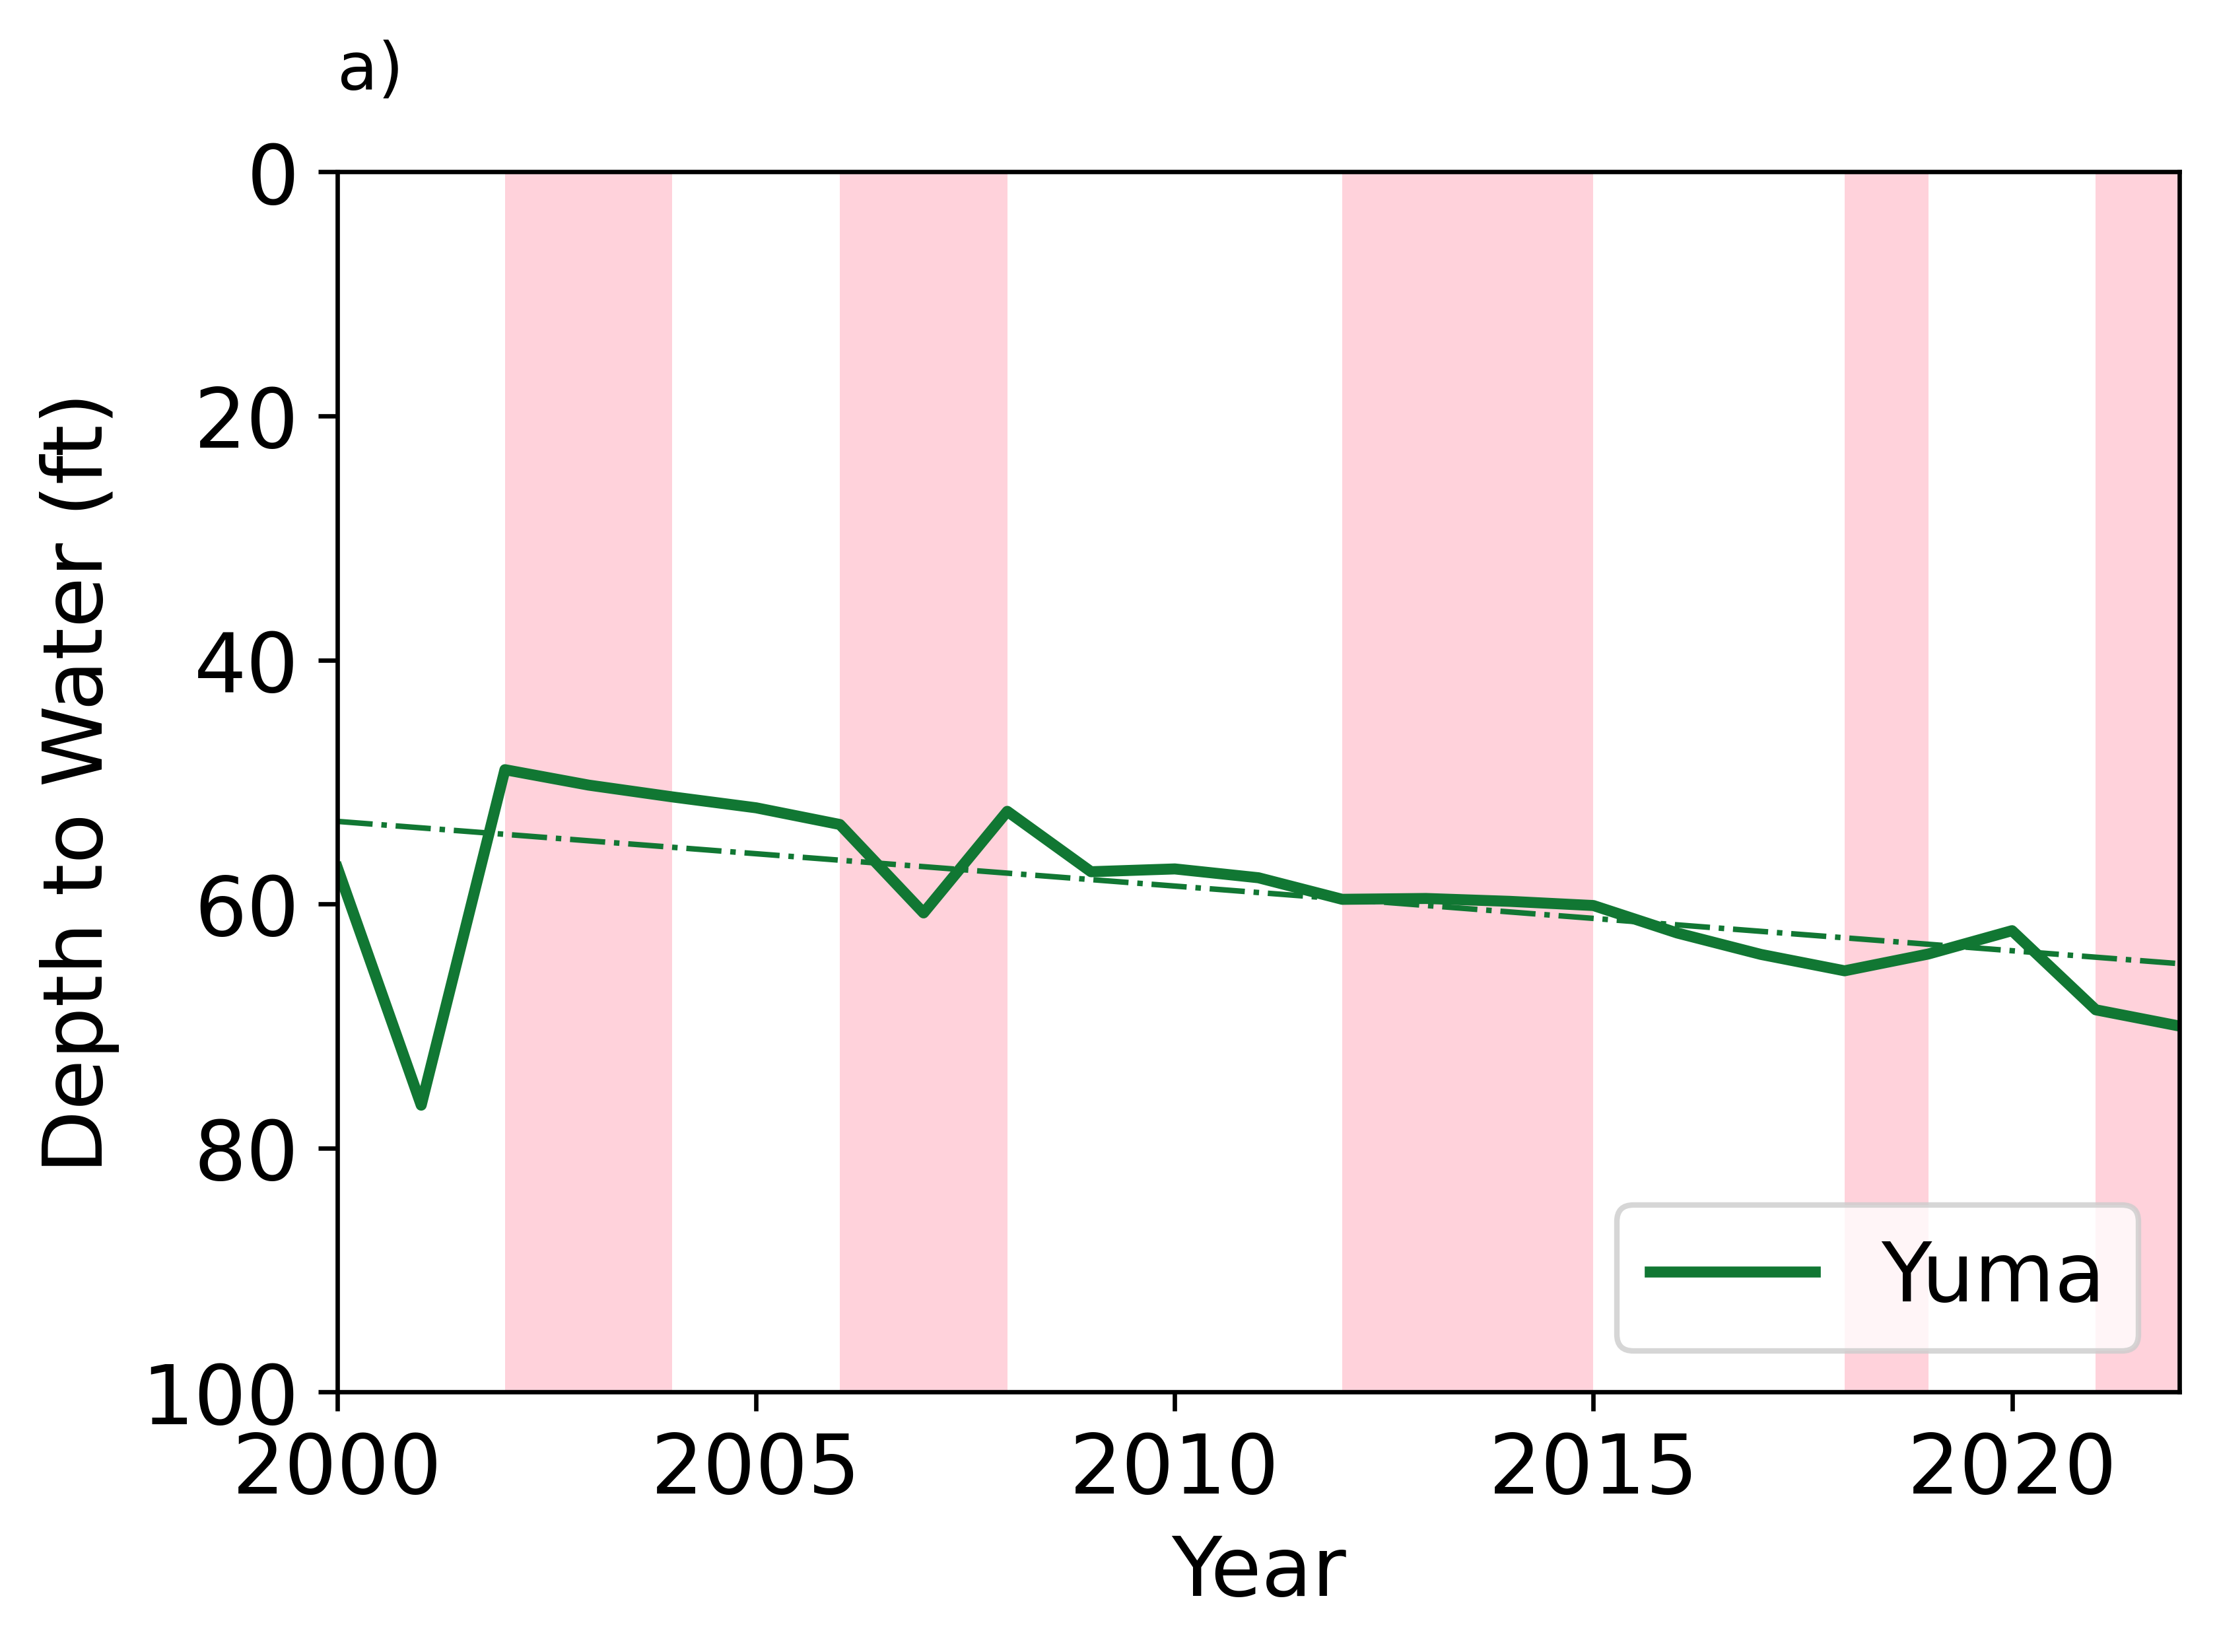

In [59]:
# For Depth to Water for all Case Studies
ds = test
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea
betterlabels = ds.columns.tolist()

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats = stats.sort_values(by='slope', ascending=False)
stats1 = stats.transpose()
print(stats)
# stats.to_csv(outputpath+'Stats_'+StudyArea+'.csv')

# -- Data visualization --

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = 0
max_y = 100
fsize = 15

# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Ensure that the labels are integers
ax.set_xticklabels(map(int, xticks))

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

# Plotting the data
for i,j in zip(stats1.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()

# Plotting Trendlines
for i,j in zip(stats1.columns,refined_cblind_colors):
        #xf1 = pd.to_datetime(xf1)
        m1 = round(stats1.loc['slope',i], 2)
        yint1 = round(stats1.loc['int',i], 2)
        pval1 = round(stats1.loc['p_val',i], 4)
        yf1 = (m1*xf)+yint1
        # ax.plot(xf1, yf1,"-.",color=blind[j], lw=1)
        ax.plot(xf1, yf1,"-.",color=j, lw=1)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(max_y,min_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='y', labelsize=fsize)
ax.tick_params(axis='x', labelsize = fsize, rotation=0)
fig.set_dpi(600.0)
ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='lower right',fontsize = fsize)
# ax.legend(loc=[1.1,0.5])


plt.savefig(figurepath+'/Figure10a', bbox_inches = 'tight')

In [60]:
# Anomaly's
# Need to redo this line for some reason
df = df_interpolated.drop(columns=columns_to_delete)
ds = df.copy()
column_list = df.columns.tolist()
trend_df = df.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        dataframe = ds[i]
        y=np.array(dataframe.values, dtype=float)
        x=np.array(pd.to_datetime(dataframe).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        trend_df[i] = (df.index*slope) + intercept
        dtw_anomalys[i] = df[i] - trend_df[i]

dtw_anomalys.head()

Yuma
index      
2000   3.28
2001  22.18
2002  -5.85
2003  -5.11
2004  -4.68

Text(2000.5, 23, 'Dry')

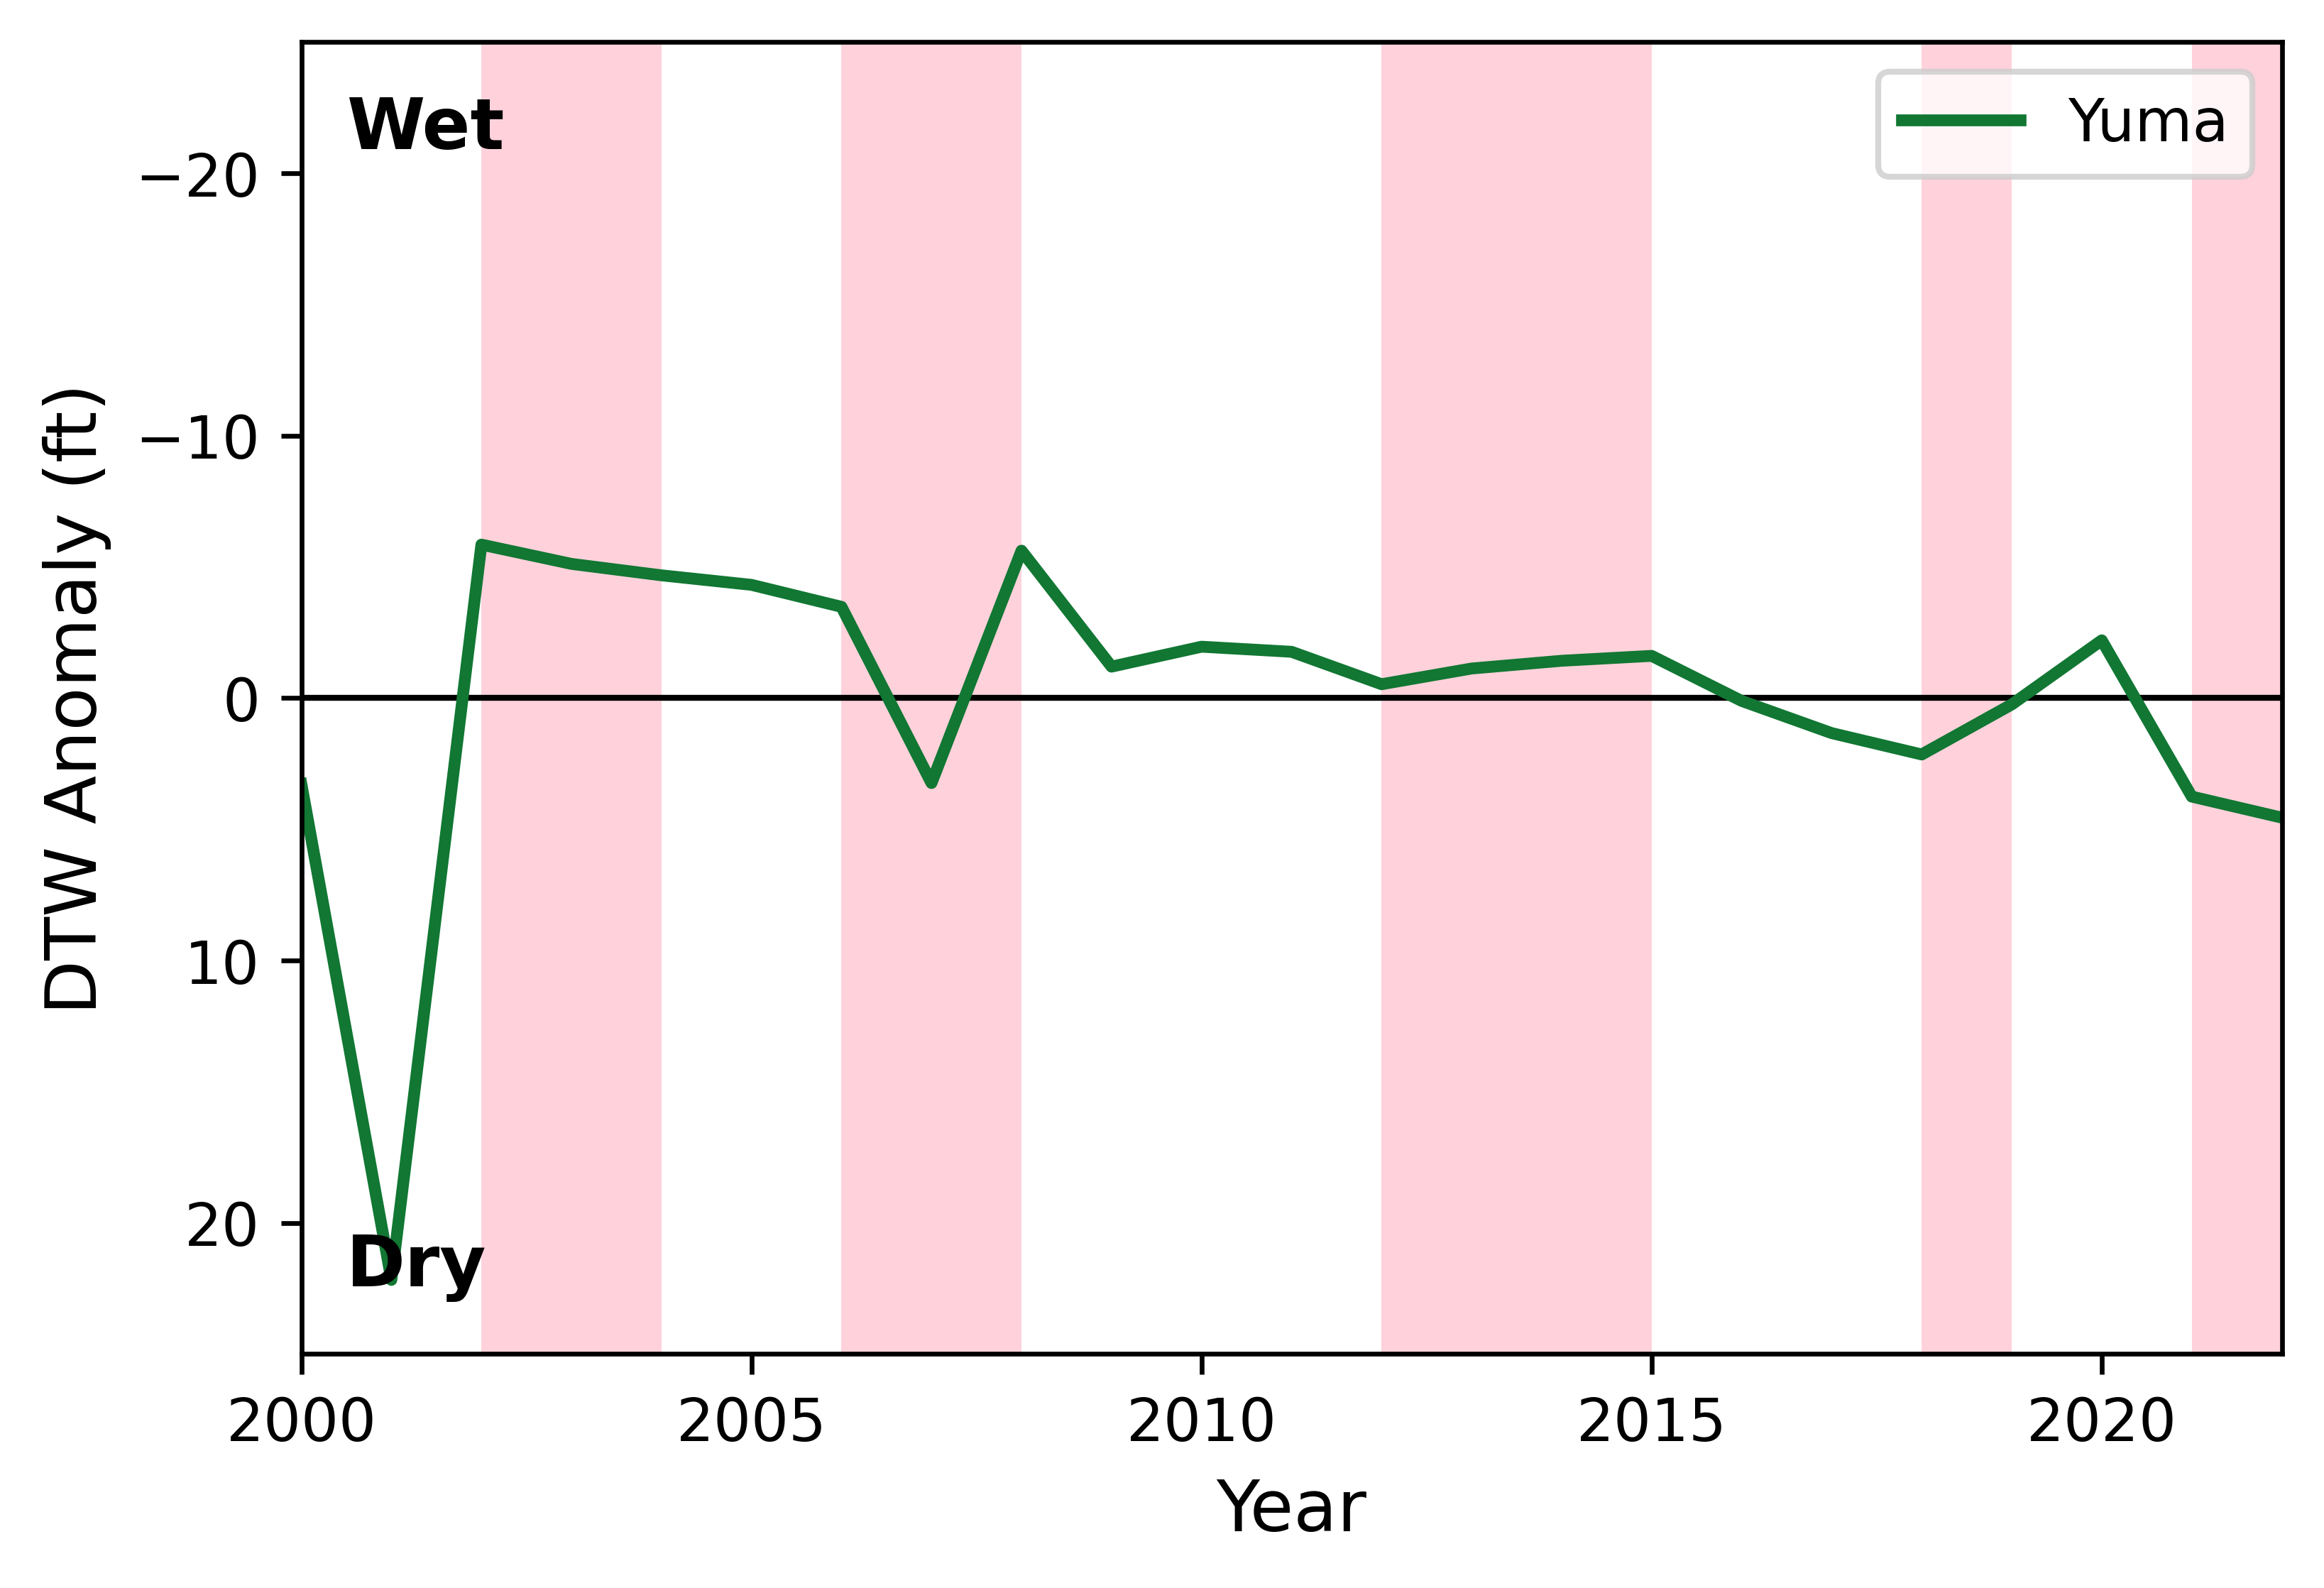

In [61]:
# For Depth to Water by regulation
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ylim = 25
fsize = 12
# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

plt.axhspan(0,0,color='black',lw=1)

for i,j in zip(ds.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(25,-25)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=0)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# Adding text inside the plot
ax.text(min_yr+0.5, 2-ylim, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, ylim-2, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# plt.savefig(figurepath+'/Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

Results for Yuma (2000-2022):
Kendall Correlation coefficient
 Yuma:
  tau = -0.004
  pval = 1.0
Spearman Correlation coefficient
 Yuma:
  rho = -0.017
  pval = 0.9394
Pearson Correlation coefficient
 Yuma:
  rsq = 0.023
  pval = 0.4861



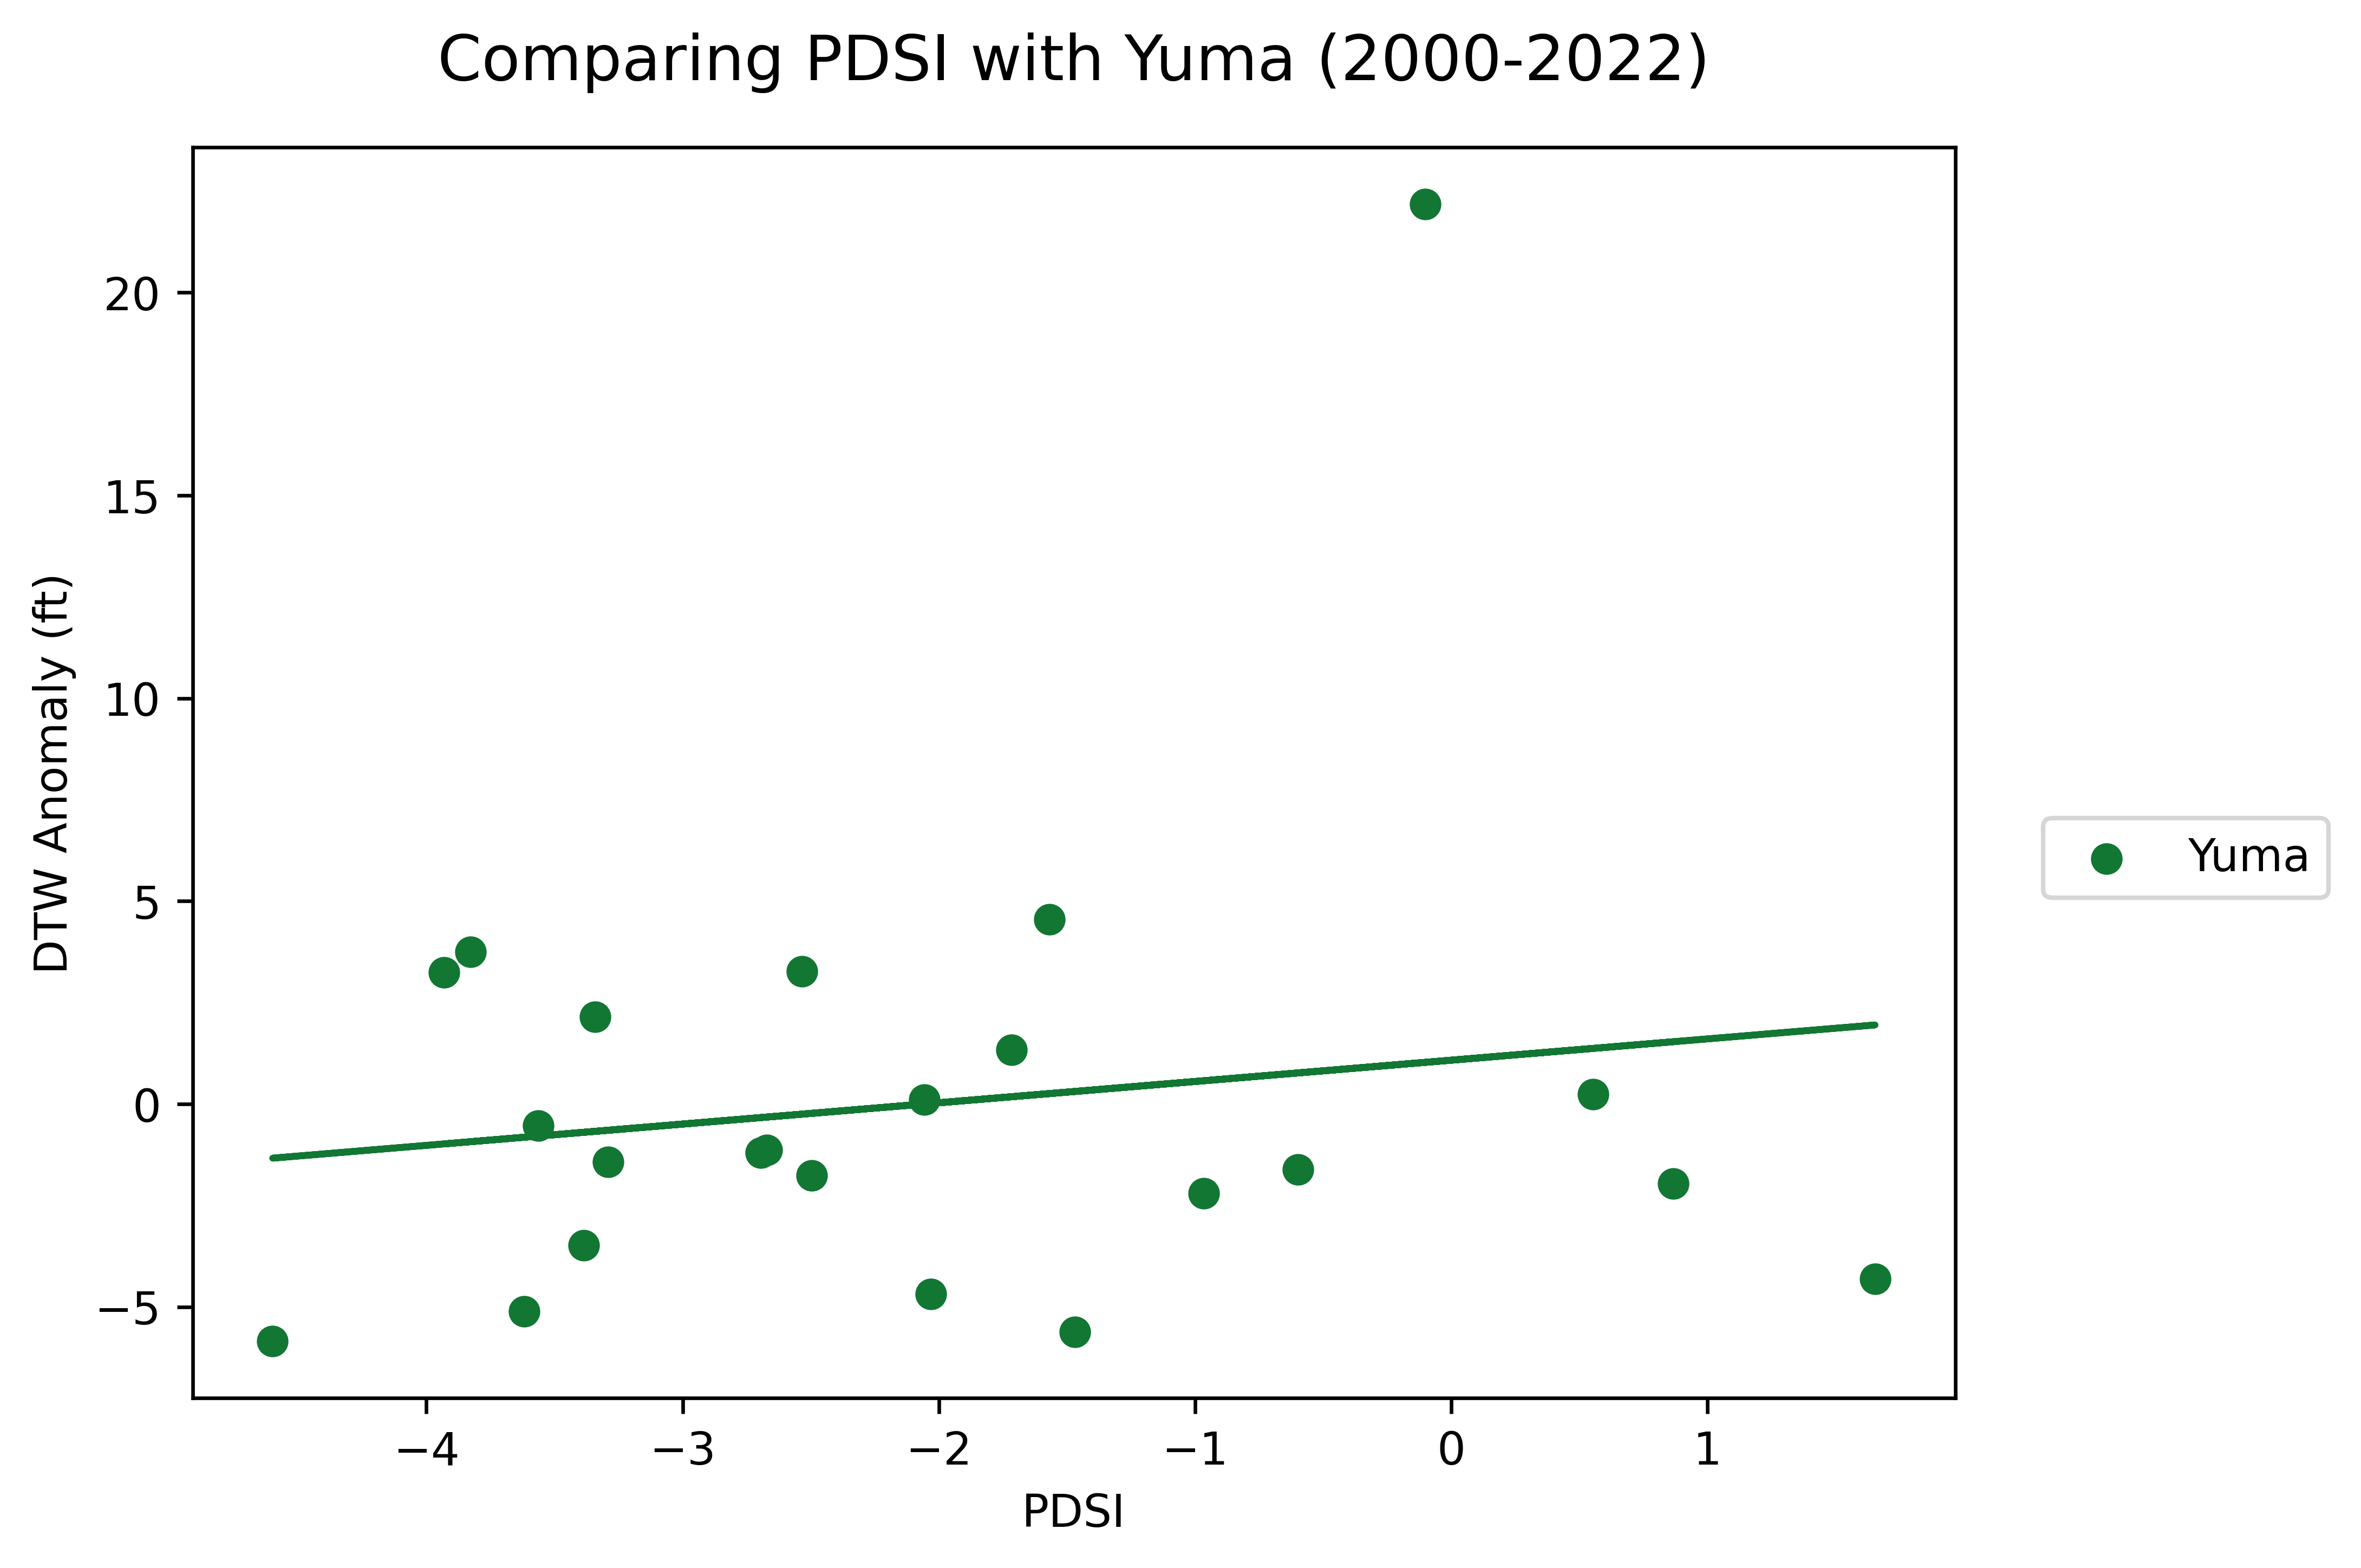

In [62]:
test_name = StudyArea+" ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices
lag = 0
indice = 'PDSI'

vert_axis = "DTW Anomaly (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,refined_cblind_colors,betterlabels,vert_axis)
print(result)

Results for Yuma (2000-2022):
Kendall Correlation coefficient
 Yuma:
  tau = -0.075
  pval = 0.6382
Spearman Correlation coefficient
 Yuma:
  rho = -0.121
  pval = 0.5837
Pearson Correlation coefficient
 Yuma:
  rsq = 0.0
  pval = 0.9566



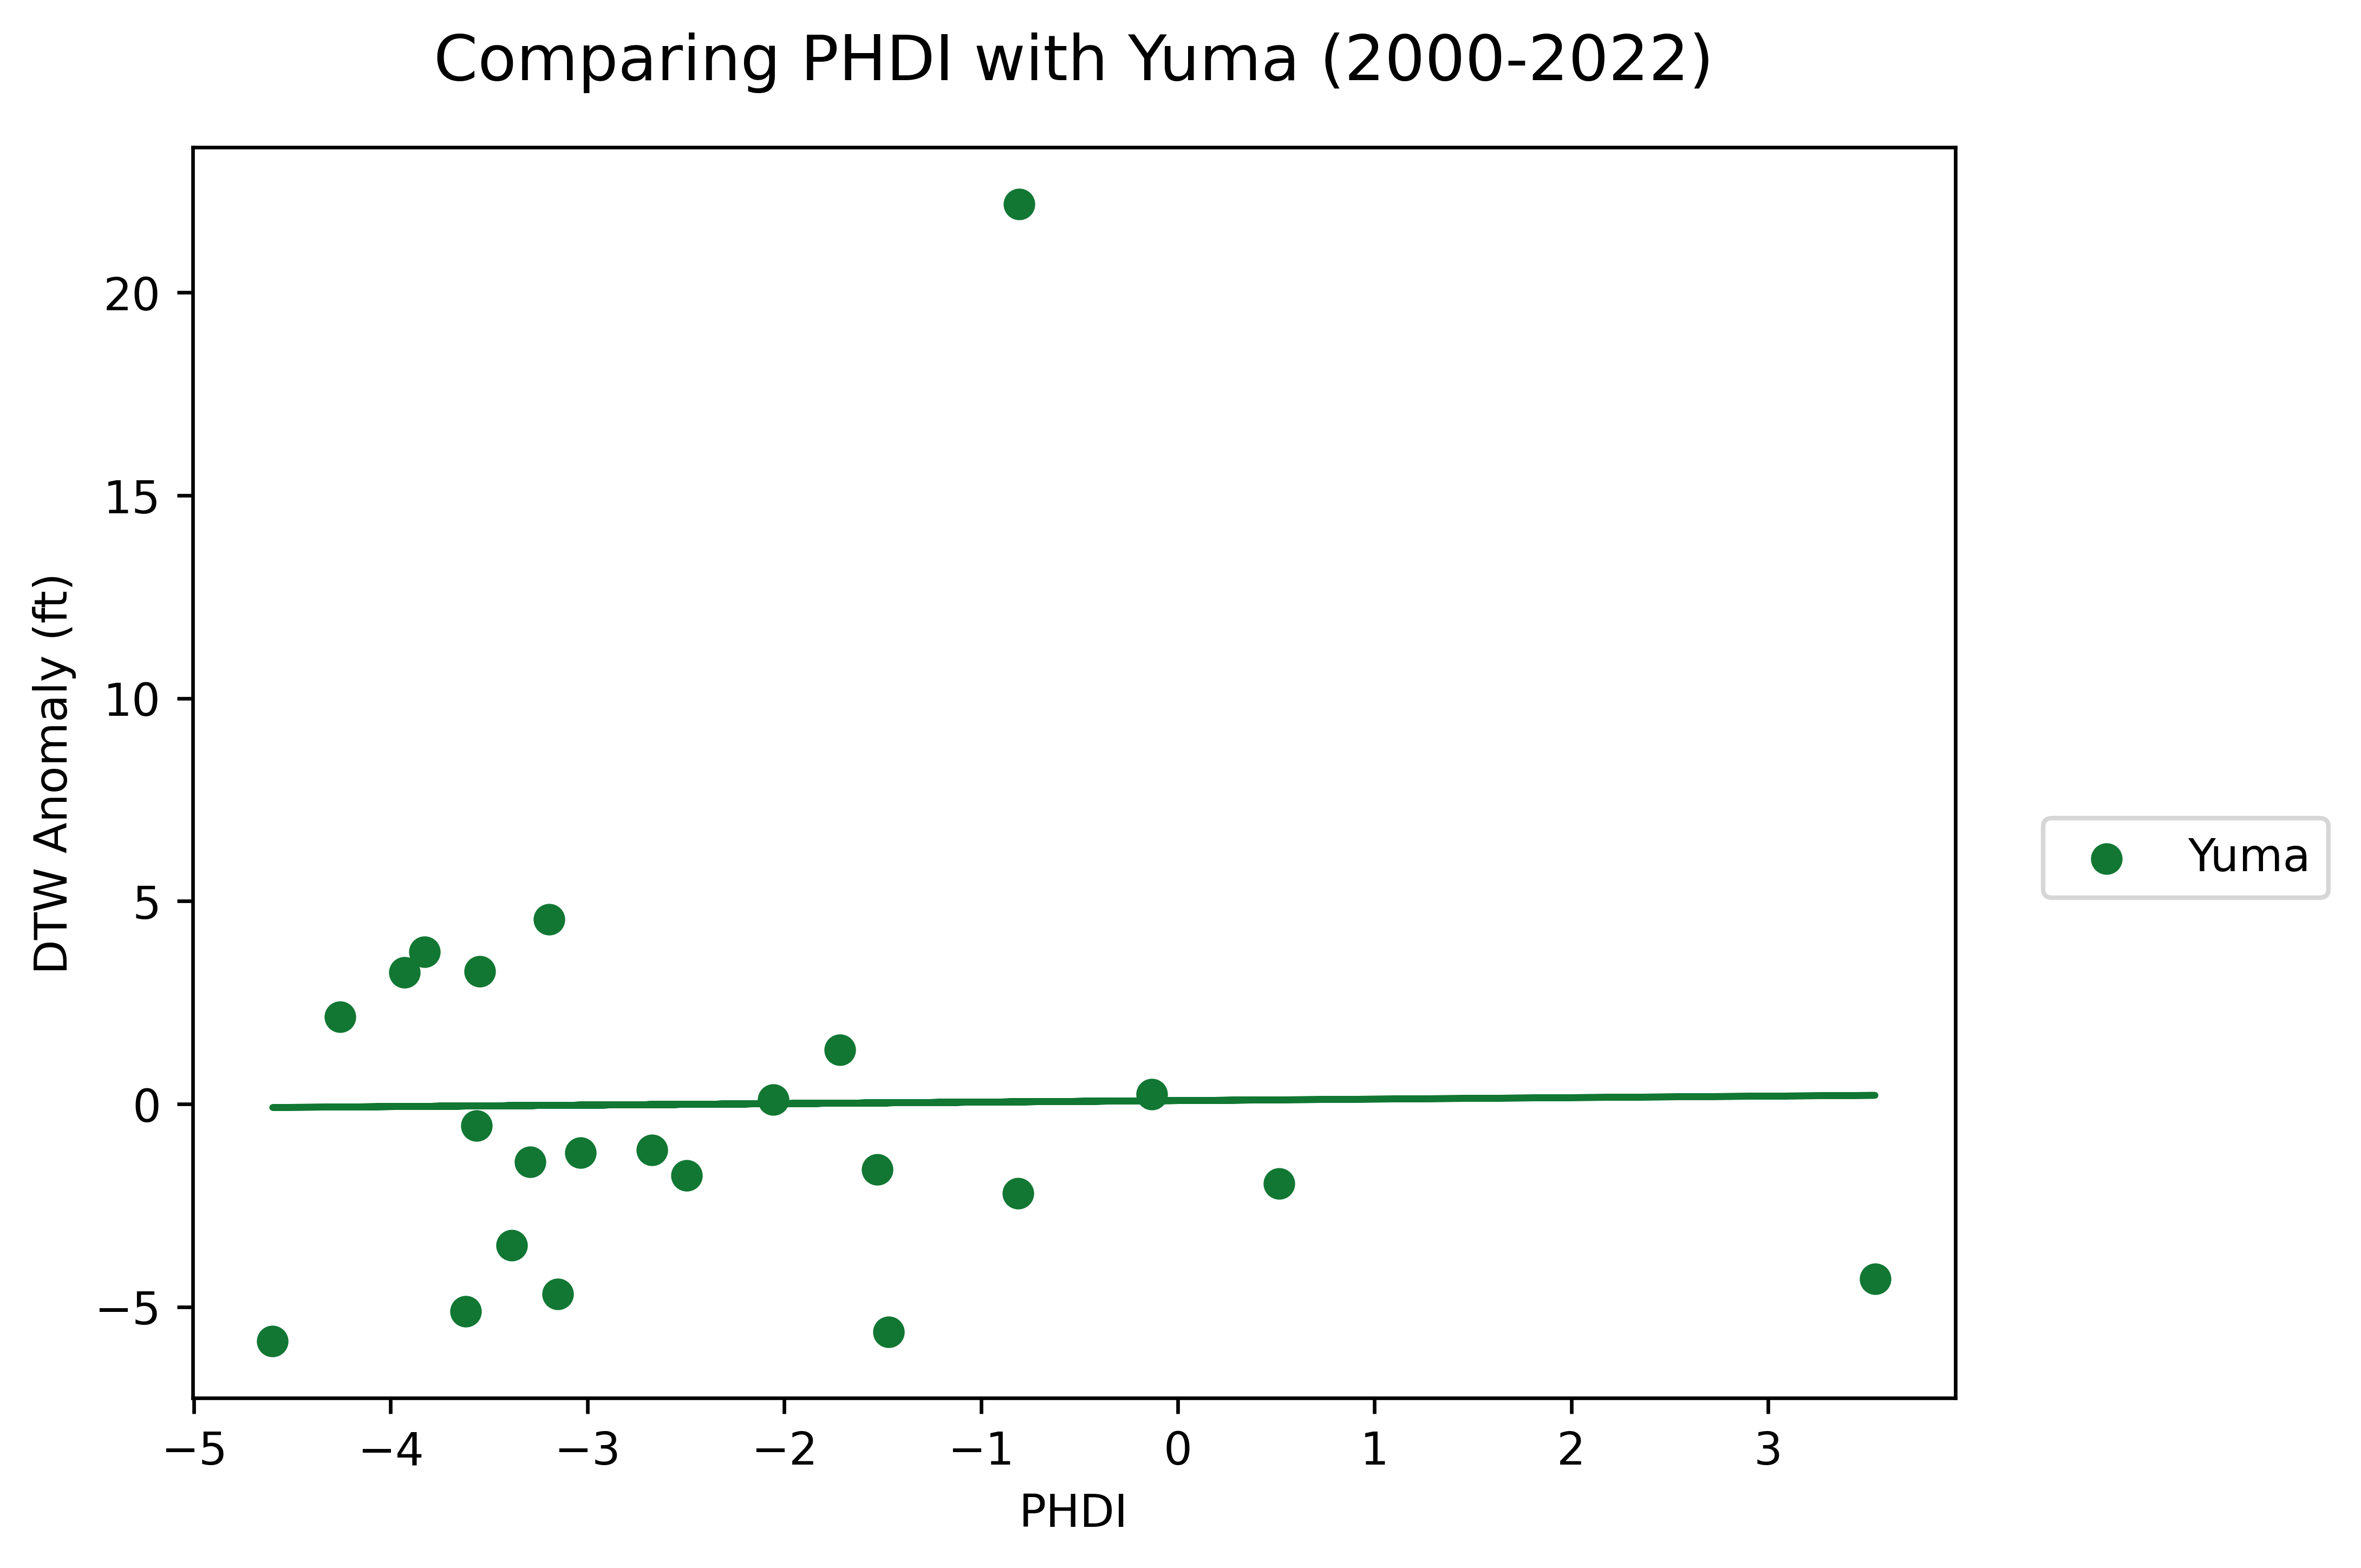

In [63]:
test_name = StudyArea+" ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices
lag = 0
indice = 'PHDI'

vert_axis = "DTW Anomaly (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,refined_cblind_colors,betterlabels,vert_axis)
print(result)

Calculating Max Drawdown (maximum anomaly in the drought period)

In [64]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

Yuma
Status          
Drought 3  -5.11
Drought 4   3.24
Drought 5  -0.53
Drought 6   2.15
Drought 7   3.76
Normal-Wet 22.18

In [65]:
# Reorder the dataframe

test = pd.DataFrame()
test['Yuma'] = dtw_max_anomalies['Yuma']
test

Yuma
Status          
Drought 3  -5.11
Drought 4   3.24
Drought 5  -0.53
Drought 6   2.15
Drought 7   3.76
Normal-Wet 22.18

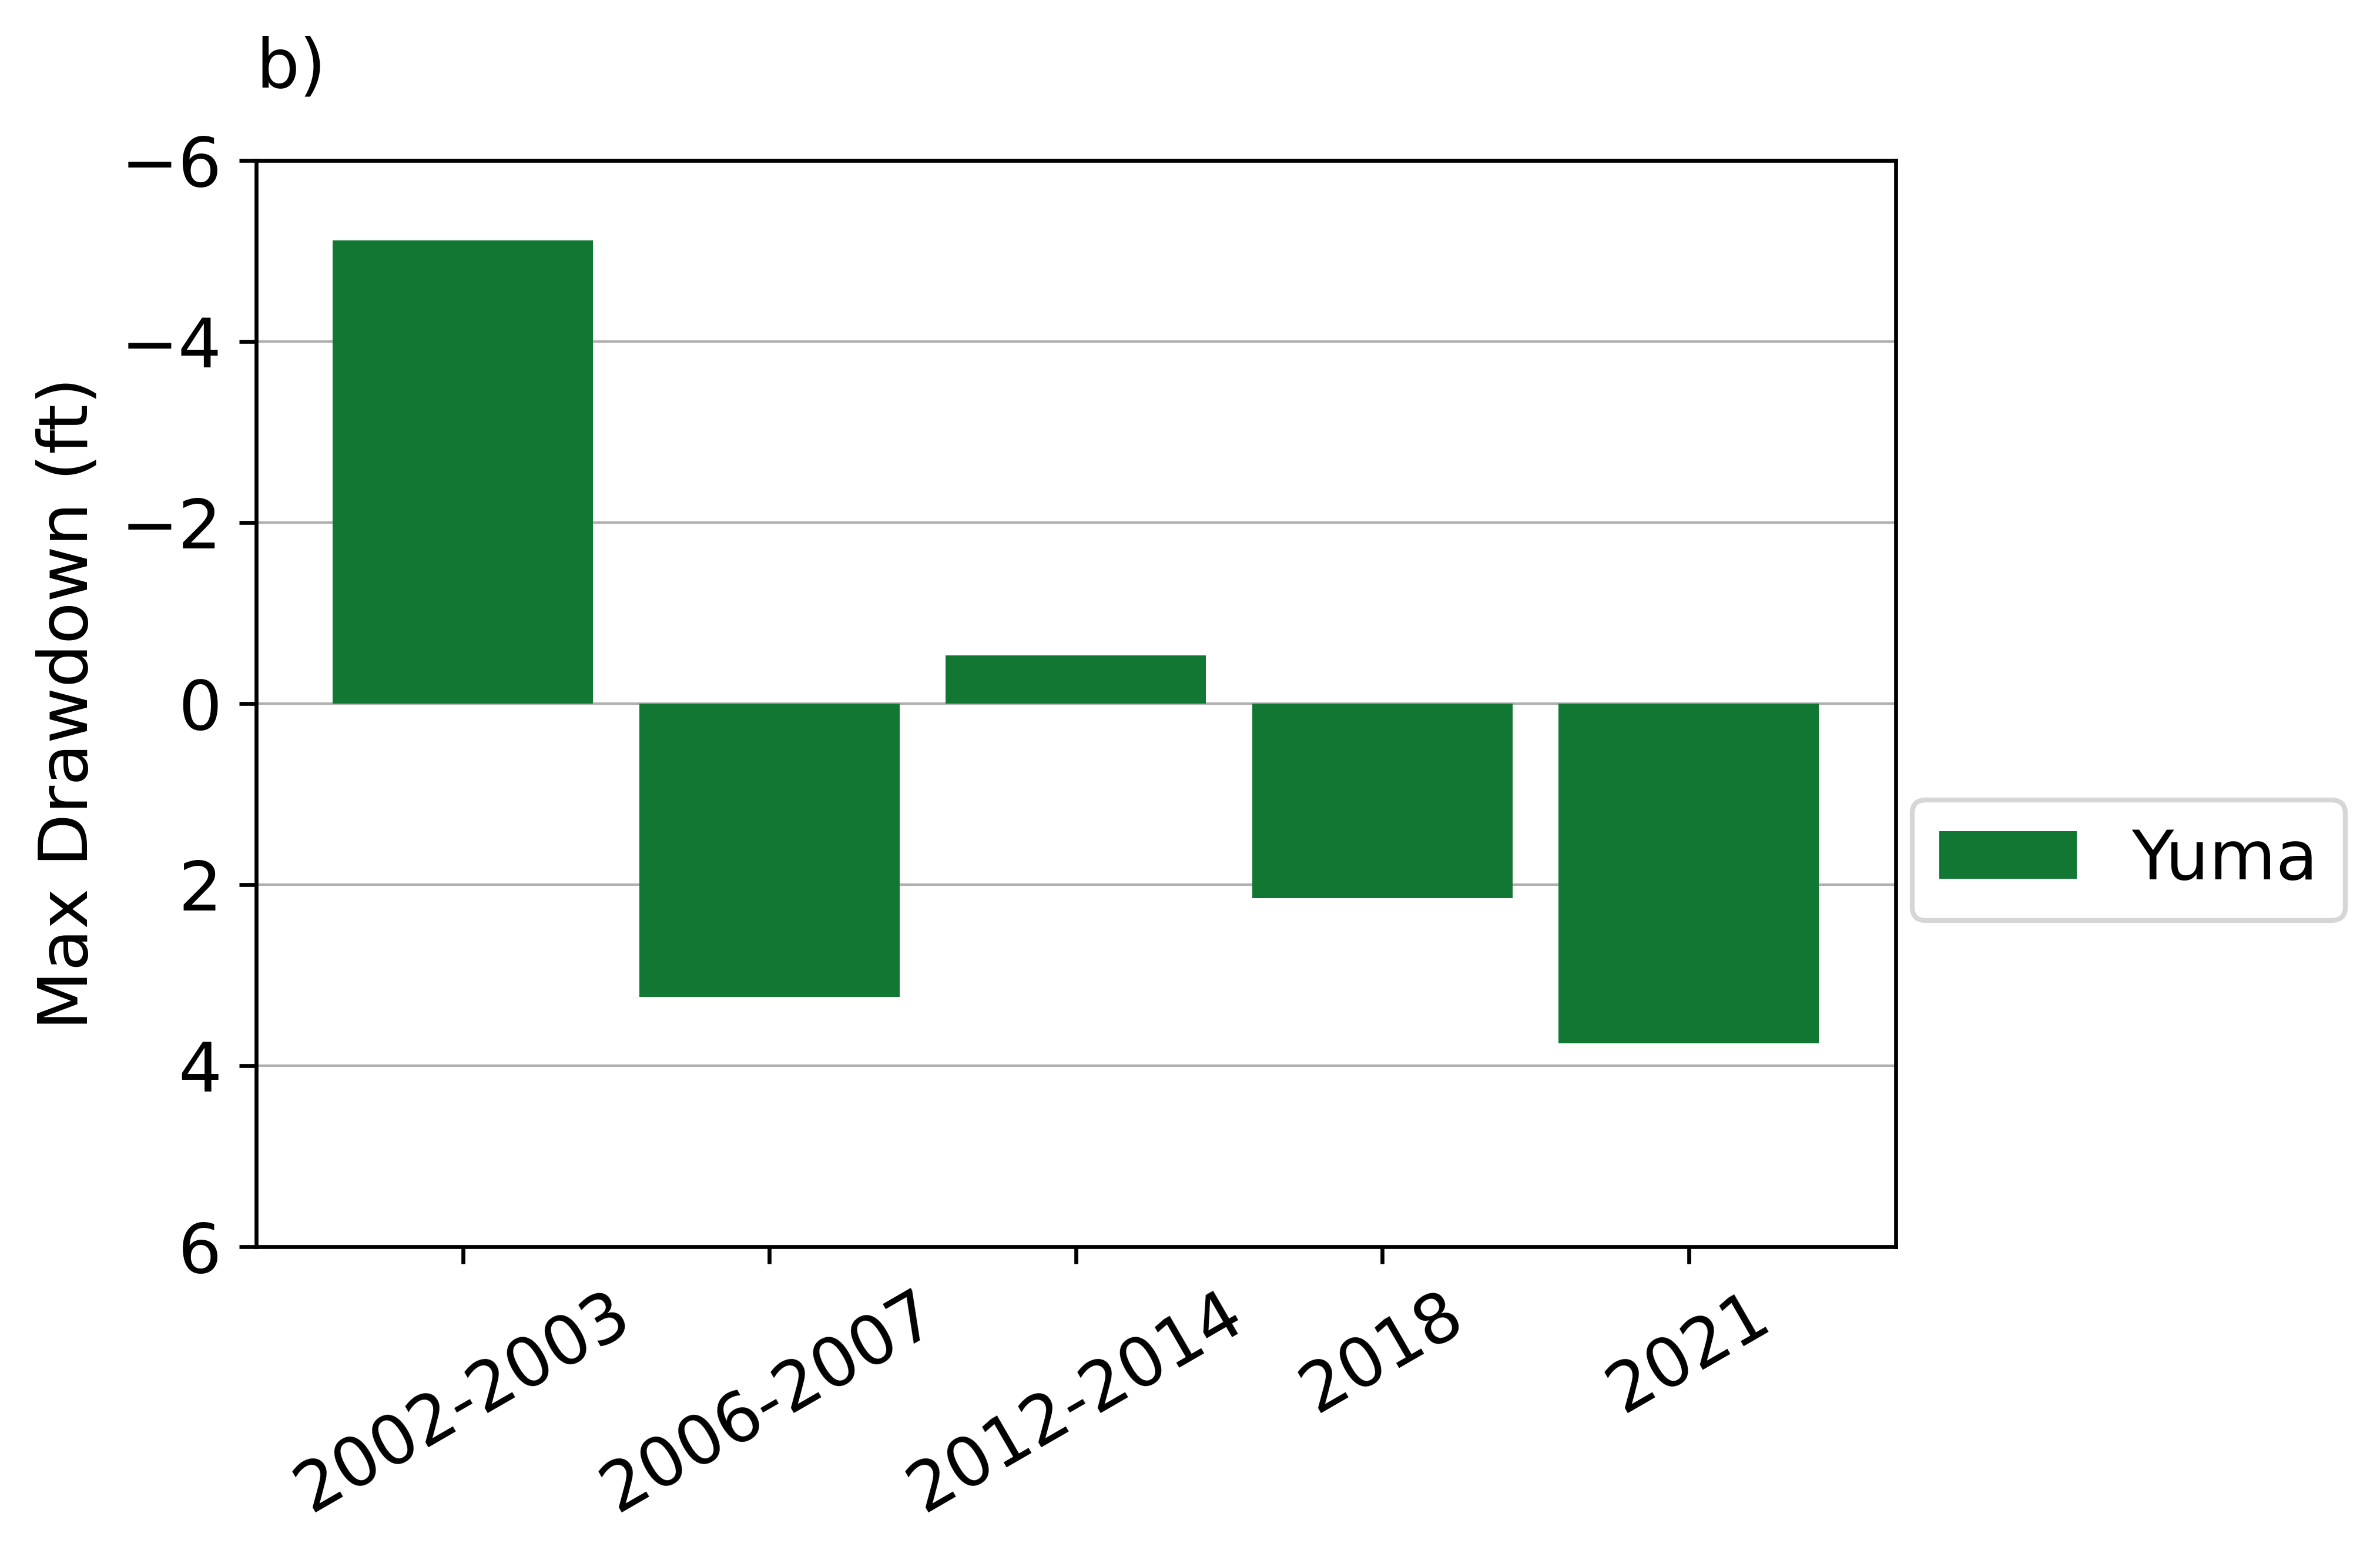

In [66]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period for '+StudyArea

ds = test

ylim = 6

yearlabels = [
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years']

betterlabels = ds.columns.tolist()

ds.index = yearlabels
ds = ds.transpose()

ds.index = betterlabels
del ds['Normal/Wet Years']
ds = ds.transpose()

group_colors =refined_cblind_colors

# horlabel = 'DTW Anomaly (ft)'
vertlabel = 'Max Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
ds.plot(figsize = (6,4),
        kind='bar',
        stacked=False,
        # title=name,
        # color = group_colors,
        color = refined_cblind_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title('b)', fontsize = fsize, pad=15, loc='left')
plt.ylim([ylim,-ylim])
plt.ylabel(vertlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+'/Figure10b', bbox_inches = 'tight')

In [67]:
# New wells

static_geo2['INSTALLED'] = pd.to_datetime(static_geo2['INSTALLED'])
# static_geo2['INSTALLED'].describe()

static_geo2['In_year'] = static_geo2['INSTALLED'].dt.year
# new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col+"_right"], values=["INSTALLED"], dropna=False, aggfunc=len)
new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = new_wells.reset_index()

new_wells.to_csv(outputpath+'/Final_NewWells_'+StudyArea+'.csv')

In [68]:
# To get it formatted correctly
all_columns = wlanalysis_period.columns.tolist()
new_wells2 = pd.read_csv(outputpath+'Final_NewWells_'+StudyArea+'.csv',
                        header=2,
                        names = all_columns
                        # names = [StudyArea]
                        , index_col=0
                        )
new_wells2

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/Output/LocalFinal_NewWells_Yuma.csv'

In [ ]:
new_wells2 = new_wells2.drop(columns=columns_to_delete)
new_wells2.to_csv(outputpath+'/Final_NewWells_'+StudyArea+'.csv')
new_wells2

Yuma
1900.00   NaN
1910.00   NaN
1915.00   NaN
1916.00   NaN
1917.00   NaN
...       ...
2020.00 43.00
2021.00 71.00
2022.00 40.00
2023.00 30.00
2024.00   NaN

[107 rows x 1 columns]

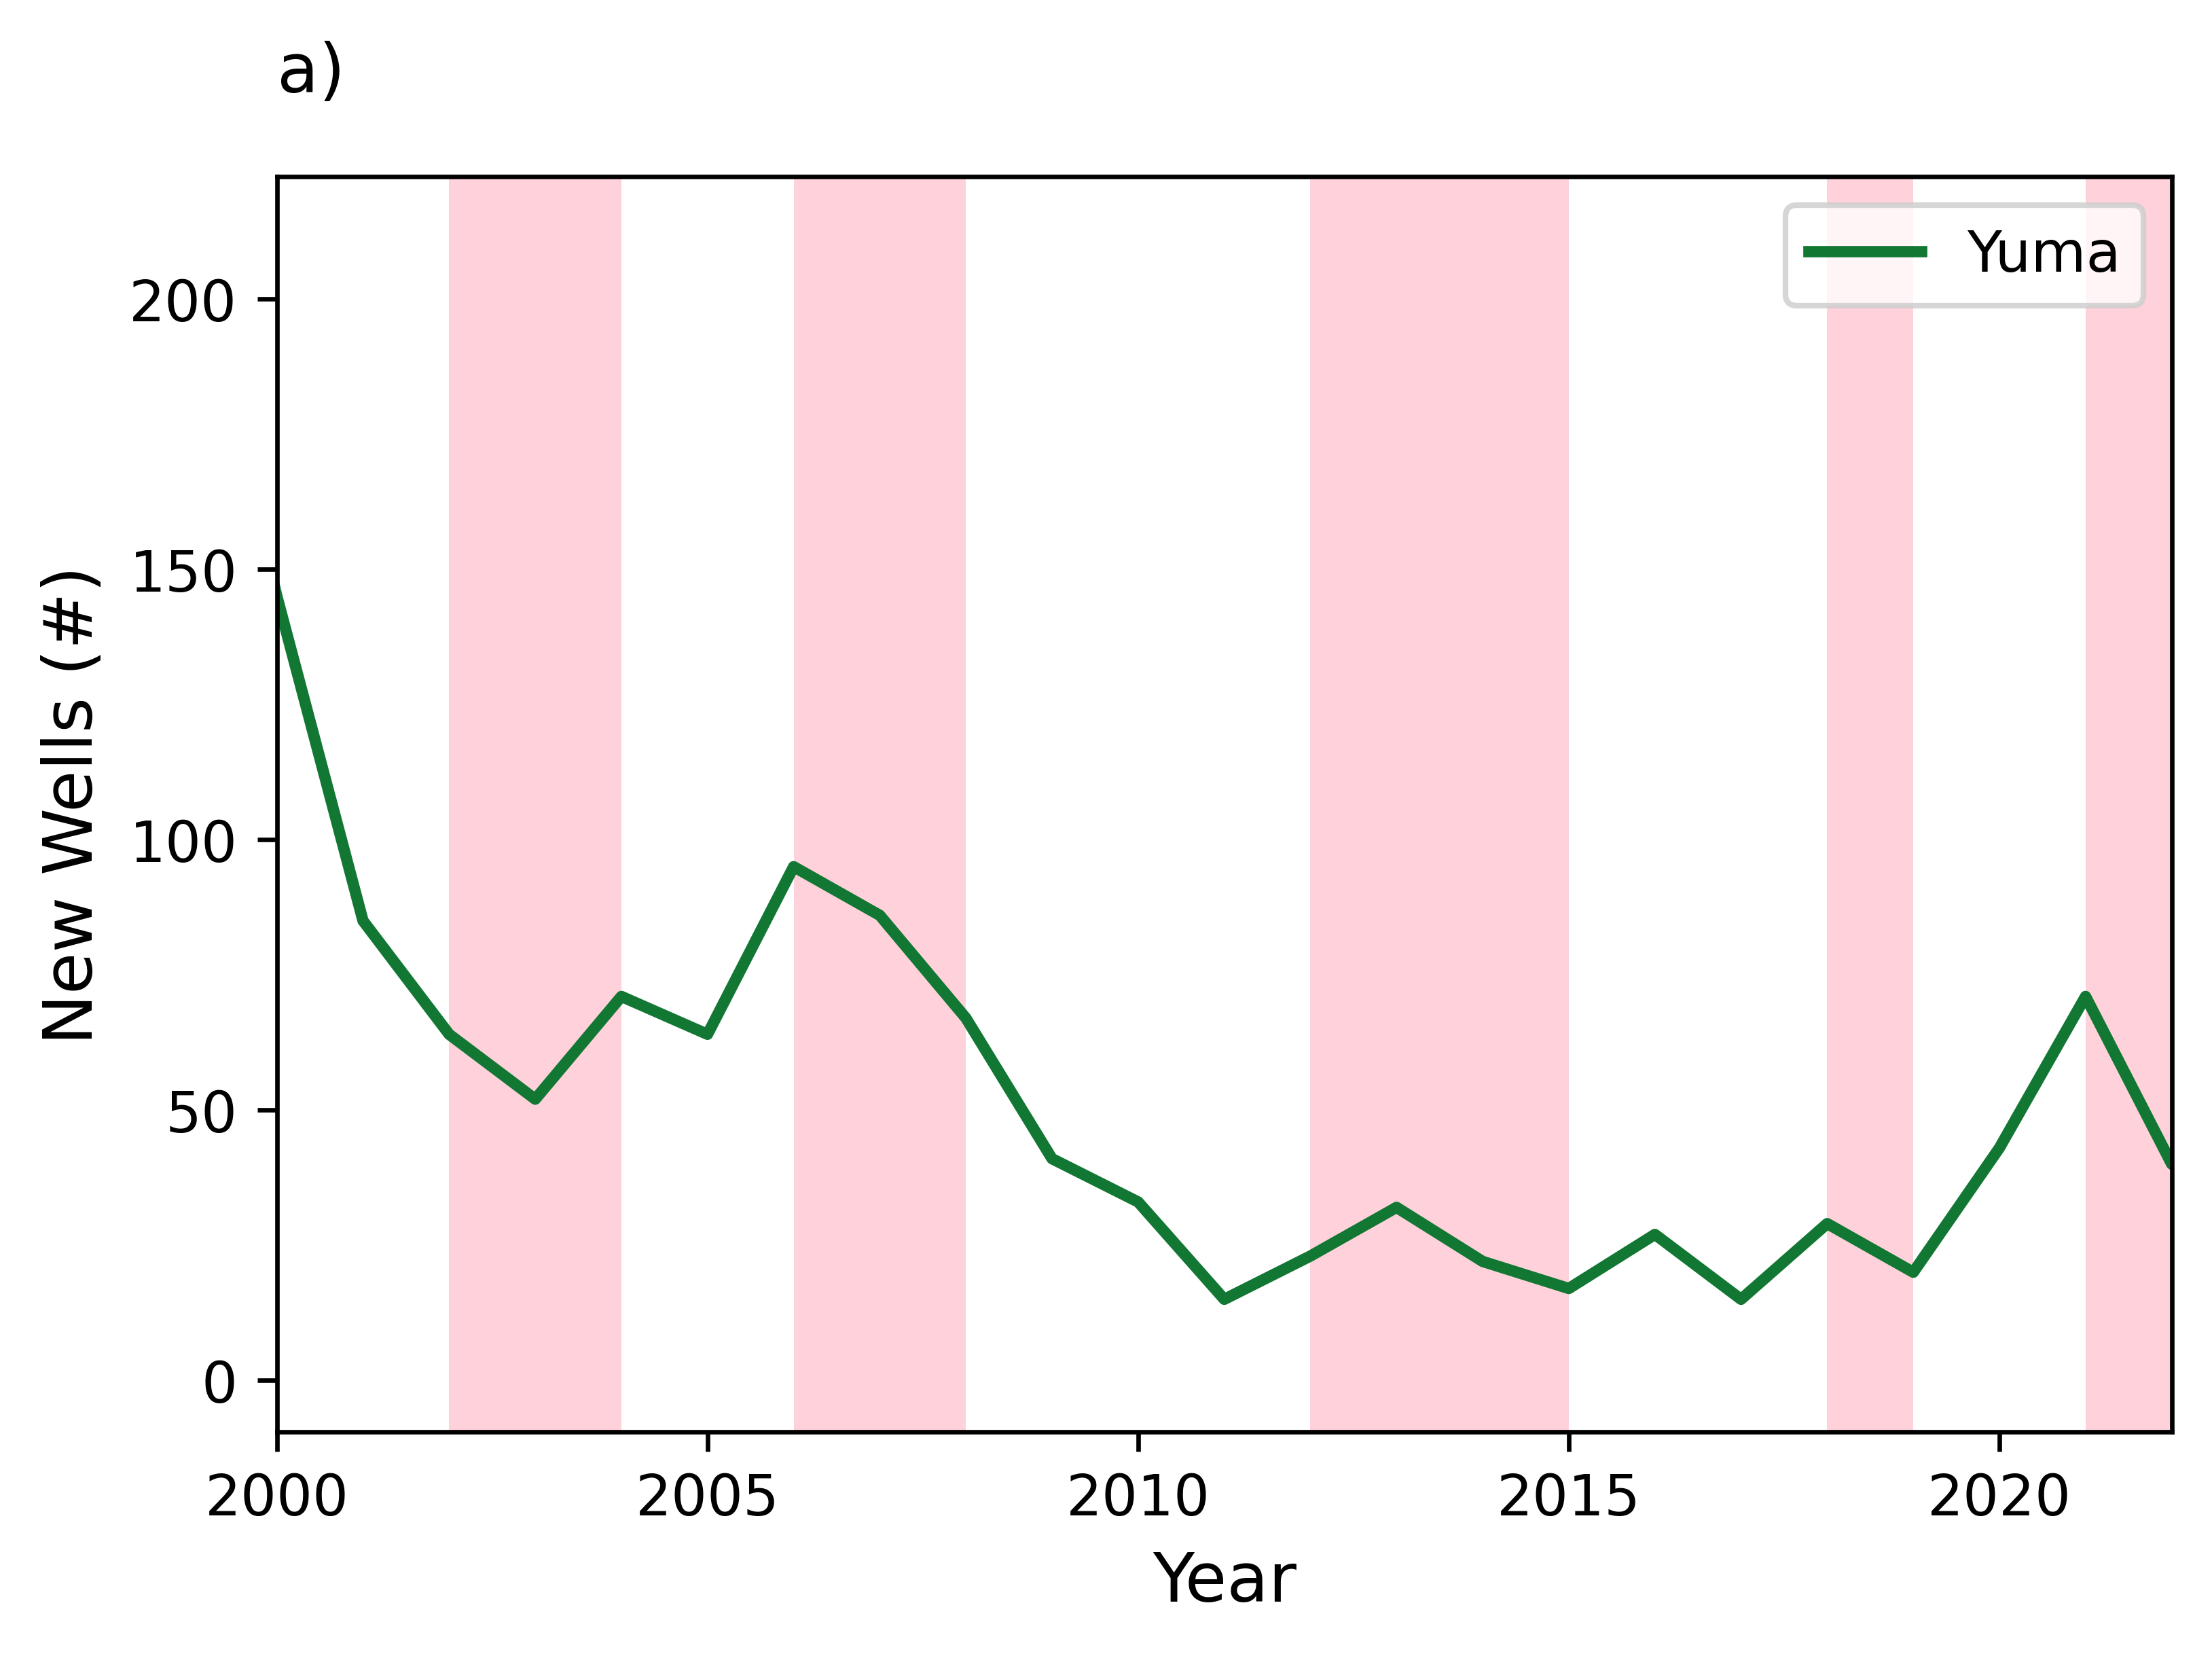

In [ ]:
ds = new_wells2
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = -12
max_y = 15
fsize = 12
# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

for i,j in zip(ds.columns,refined_cblind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel('New Wells (#)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15,fontsize = fsize)
ax.legend(loc='upper right')

